In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch
import numpy as np
import os

# Load dataset
df = pd.read_csv('5c_emotion.csv')
df = df.dropna()
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(data.head())
X = data['text']
y = data['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))

# Create Hugging Face dataset
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load BanglaBERT tokenizer and model
device = torch.device("cuda")
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)

).to(device)

# Tokenize
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    report_to=[]
)

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"\n Evaluation results: {eval_results}")

# Predictions
predictions_output = trainer.predict(dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids


c:\Users\USERAS\anaconda3\envs\resPy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


            text    label
0  খুবই মজার ছিল    happy
1    এটা ঠিক আছে  neutral
2   খুবই আনন্দিত    happy
3  খুবই মজার ছিল    happy
4  তুমি খুব মজার    happy


c:\Users\USERAS\anaconda3\envs\resPy\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exa

{'loss': 1.6202, 'learning_rate': 1.0860711376595167e-07, 'epoch': 0.0}


  0%|          | 41/36822 [00:04<1:04:59,  9.43it/s]

{'loss': 1.6197, 'learning_rate': 2.1721422753190334e-07, 'epoch': 0.0}


  0%|          | 61/36822 [00:06<1:05:04,  9.41it/s]

{'loss': 1.6279, 'learning_rate': 3.2582134129785504e-07, 'epoch': 0.0}


  0%|          | 81/36822 [00:08<1:04:38,  9.47it/s]

{'loss': 1.626, 'learning_rate': 4.344284550638067e-07, 'epoch': 0.01}


  0%|          | 101/36822 [00:11<1:05:35,  9.33it/s]

{'loss': 1.6029, 'learning_rate': 5.430355688297583e-07, 'epoch': 0.01}


  0%|          | 121/36822 [00:13<1:05:48,  9.29it/s]

{'loss': 1.6017, 'learning_rate': 6.516426825957101e-07, 'epoch': 0.01}


  0%|          | 141/36822 [00:15<1:07:00,  9.12it/s]

{'loss': 1.5847, 'learning_rate': 7.602497963616617e-07, 'epoch': 0.01}


  0%|          | 161/36822 [00:17<1:08:21,  8.94it/s]

{'loss': 1.593, 'learning_rate': 8.688569101276134e-07, 'epoch': 0.01}


  0%|          | 181/36822 [00:19<1:06:38,  9.16it/s]

{'loss': 1.5737, 'learning_rate': 9.774640238935651e-07, 'epoch': 0.01}


  1%|          | 201/36822 [00:21<1:05:51,  9.27it/s]

{'loss': 1.5615, 'learning_rate': 1.0860711376595167e-06, 'epoch': 0.02}


  1%|          | 221/36822 [00:24<1:05:28,  9.32it/s]

{'loss': 1.5396, 'learning_rate': 1.1946782514254684e-06, 'epoch': 0.02}


  1%|          | 241/36822 [00:26<1:06:09,  9.21it/s]

{'loss': 1.5275, 'learning_rate': 1.3032853651914202e-06, 'epoch': 0.02}


  1%|          | 261/36822 [00:28<1:05:13,  9.34it/s]

{'loss': 1.5076, 'learning_rate': 1.4118924789573717e-06, 'epoch': 0.02}


  1%|          | 281/36822 [00:30<1:05:37,  9.28it/s]

{'loss': 1.4836, 'learning_rate': 1.5204995927233235e-06, 'epoch': 0.02}


  1%|          | 301/36822 [00:32<1:08:33,  8.88it/s]

{'loss': 1.4402, 'learning_rate': 1.6291067064892752e-06, 'epoch': 0.02}


  1%|          | 321/36822 [00:34<1:05:20,  9.31it/s]

{'loss': 1.4337, 'learning_rate': 1.7377138202552268e-06, 'epoch': 0.03}


  1%|          | 342/36822 [00:37<1:04:29,  9.43it/s]

{'loss': 1.4019, 'learning_rate': 1.8463209340211785e-06, 'epoch': 0.03}


  1%|          | 361/36822 [00:39<1:04:44,  9.39it/s]

{'loss': 1.359, 'learning_rate': 1.9549280477871303e-06, 'epoch': 0.03}


  1%|          | 381/36822 [00:41<1:07:18,  9.02it/s]

{'loss': 1.3218, 'learning_rate': 2.063535161553082e-06, 'epoch': 0.03}


  1%|          | 401/36822 [00:43<1:07:50,  8.95it/s]

{'loss': 1.2905, 'learning_rate': 2.1721422753190333e-06, 'epoch': 0.03}


  1%|          | 421/36822 [00:45<1:11:25,  8.49it/s]

{'loss': 1.2382, 'learning_rate': 2.2807493890849853e-06, 'epoch': 0.03}


  1%|          | 441/36822 [00:47<1:10:29,  8.60it/s]

{'loss': 1.1991, 'learning_rate': 2.389356502850937e-06, 'epoch': 0.04}


  1%|▏         | 461/36822 [00:50<1:07:03,  9.04it/s]

{'loss': 1.177, 'learning_rate': 2.4979636166168884e-06, 'epoch': 0.04}


  1%|▏         | 481/36822 [00:52<1:06:18,  9.13it/s]

{'loss': 1.1547, 'learning_rate': 2.6065707303828403e-06, 'epoch': 0.04}


  1%|▏         | 501/36822 [00:54<1:05:42,  9.21it/s]

{'loss': 1.0846, 'learning_rate': 2.715177844148792e-06, 'epoch': 0.04}


  1%|▏         | 521/36822 [00:56<1:06:19,  9.12it/s]

{'loss': 1.033, 'learning_rate': 2.8237849579147434e-06, 'epoch': 0.04}


  1%|▏         | 541/36822 [00:58<1:07:31,  8.95it/s]

{'loss': 1.014, 'learning_rate': 2.9323920716806954e-06, 'epoch': 0.04}


  2%|▏         | 561/36822 [01:01<1:07:31,  8.95it/s]

{'loss': 0.9792, 'learning_rate': 3.040999185446647e-06, 'epoch': 0.05}


  2%|▏         | 581/36822 [01:03<1:07:40,  8.92it/s]

{'loss': 0.8732, 'learning_rate': 3.1496062992125985e-06, 'epoch': 0.05}


  2%|▏         | 601/36822 [01:05<1:06:05,  9.13it/s]

{'loss': 0.8502, 'learning_rate': 3.2582134129785504e-06, 'epoch': 0.05}


  2%|▏         | 621/36822 [01:07<1:06:15,  9.11it/s]

{'loss': 0.8893, 'learning_rate': 3.366820526744502e-06, 'epoch': 0.05}


  2%|▏         | 641/36822 [01:09<1:06:08,  9.12it/s]

{'loss': 0.7918, 'learning_rate': 3.4754276405104535e-06, 'epoch': 0.05}


  2%|▏         | 661/36822 [01:12<1:07:56,  8.87it/s]

{'loss': 0.6785, 'learning_rate': 3.5840347542764055e-06, 'epoch': 0.05}


  2%|▏         | 681/36822 [01:14<1:08:05,  8.85it/s]

{'loss': 0.6569, 'learning_rate': 3.692641868042357e-06, 'epoch': 0.06}


  2%|▏         | 701/36822 [01:16<1:05:36,  9.18it/s]

{'loss': 0.6785, 'learning_rate': 3.8012489818083085e-06, 'epoch': 0.06}


  2%|▏         | 721/36822 [01:18<1:07:52,  8.86it/s]

{'loss': 0.6188, 'learning_rate': 3.9098560955742605e-06, 'epoch': 0.06}


  2%|▏         | 741/36822 [01:21<1:05:21,  9.20it/s]

{'loss': 0.6138, 'learning_rate': 4.018463209340212e-06, 'epoch': 0.06}


  2%|▏         | 761/36822 [01:23<1:06:33,  9.03it/s]

{'loss': 0.5451, 'learning_rate': 4.127070323106164e-06, 'epoch': 0.06}


  2%|▏         | 781/36822 [01:25<1:07:21,  8.92it/s]

{'loss': 0.5046, 'learning_rate': 4.235677436872115e-06, 'epoch': 0.06}


  2%|▏         | 801/36822 [01:27<1:06:37,  9.01it/s]

{'loss': 0.4824, 'learning_rate': 4.344284550638067e-06, 'epoch': 0.07}


  2%|▏         | 821/36822 [01:29<1:07:56,  8.83it/s]

{'loss': 0.5071, 'learning_rate': 4.452891664404019e-06, 'epoch': 0.07}


  2%|▏         | 841/36822 [01:32<1:06:29,  9.02it/s]

{'loss': 0.4188, 'learning_rate': 4.561498778169971e-06, 'epoch': 0.07}


  2%|▏         | 861/36822 [01:34<1:06:57,  8.95it/s]

{'loss': 0.4565, 'learning_rate': 4.670105891935922e-06, 'epoch': 0.07}


  2%|▏         | 881/36822 [01:36<1:04:44,  9.25it/s]

{'loss': 0.3746, 'learning_rate': 4.778713005701874e-06, 'epoch': 0.07}


  2%|▏         | 901/36822 [01:38<1:05:58,  9.07it/s]

{'loss': 0.4076, 'learning_rate': 4.887320119467825e-06, 'epoch': 0.07}


  3%|▎         | 921/36822 [01:40<1:06:03,  9.06it/s]

{'loss': 0.3421, 'learning_rate': 4.995927233233777e-06, 'epoch': 0.07}


  3%|▎         | 941/36822 [01:42<1:06:49,  8.95it/s]

{'loss': 0.4498, 'learning_rate': 5.104534346999729e-06, 'epoch': 0.08}


  3%|▎         | 961/36822 [01:45<1:05:26,  9.13it/s]

{'loss': 0.3355, 'learning_rate': 5.213141460765681e-06, 'epoch': 0.08}


  3%|▎         | 982/36822 [01:47<1:05:33,  9.11it/s]

{'loss': 0.3223, 'learning_rate': 5.321748574531632e-06, 'epoch': 0.08}


  3%|▎         | 1001/36822 [01:49<1:06:03,  9.04it/s]

{'loss': 0.3499, 'learning_rate': 5.430355688297584e-06, 'epoch': 0.08}


  3%|▎         | 1021/36822 [01:51<1:05:37,  9.09it/s]

{'loss': 0.3091, 'learning_rate': 5.538962802063535e-06, 'epoch': 0.08}


  3%|▎         | 1041/36822 [01:54<1:05:31,  9.10it/s]

{'loss': 0.2701, 'learning_rate': 5.647569915829487e-06, 'epoch': 0.08}


  3%|▎         | 1061/36822 [01:56<1:06:52,  8.91it/s]

{'loss': 0.2474, 'learning_rate': 5.756177029595439e-06, 'epoch': 0.09}


  3%|▎         | 1081/36822 [01:58<1:08:50,  8.65it/s]

{'loss': 0.3047, 'learning_rate': 5.864784143361391e-06, 'epoch': 0.09}


  3%|▎         | 1101/36822 [02:00<1:06:11,  8.99it/s]

{'loss': 0.2933, 'learning_rate': 5.973391257127342e-06, 'epoch': 0.09}


  3%|▎         | 1121/36822 [02:02<1:05:07,  9.14it/s]

{'loss': 0.2275, 'learning_rate': 6.081998370893294e-06, 'epoch': 0.09}


  3%|▎         | 1141/36822 [02:04<1:05:30,  9.08it/s]

{'loss': 0.2877, 'learning_rate': 6.190605484659245e-06, 'epoch': 0.09}


  3%|▎         | 1161/36822 [02:07<1:04:36,  9.20it/s]

{'loss': 0.1833, 'learning_rate': 6.299212598425197e-06, 'epoch': 0.09}


  3%|▎         | 1181/36822 [02:09<1:05:36,  9.05it/s]

{'loss': 0.1702, 'learning_rate': 6.407819712191149e-06, 'epoch': 0.1}


  3%|▎         | 1201/36822 [02:11<1:06:42,  8.90it/s]

{'loss': 0.1823, 'learning_rate': 6.516426825957101e-06, 'epoch': 0.1}


  3%|▎         | 1221/36822 [02:13<1:08:16,  8.69it/s]

{'loss': 0.1646, 'learning_rate': 6.625033939723052e-06, 'epoch': 0.1}


  3%|▎         | 1241/36822 [02:15<1:06:17,  8.94it/s]

{'loss': 0.2133, 'learning_rate': 6.733641053489004e-06, 'epoch': 0.1}


  3%|▎         | 1261/36822 [02:18<1:05:02,  9.11it/s]

{'loss': 0.1518, 'learning_rate': 6.8422481672549555e-06, 'epoch': 0.1}


  3%|▎         | 1281/36822 [02:20<1:05:25,  9.05it/s]

{'loss': 0.1259, 'learning_rate': 6.950855281020907e-06, 'epoch': 0.1}


  4%|▎         | 1301/36822 [02:22<1:06:47,  8.86it/s]

{'loss': 0.1842, 'learning_rate': 7.059462394786859e-06, 'epoch': 0.11}


  4%|▎         | 1321/36822 [02:24<1:05:42,  9.00it/s]

{'loss': 0.2044, 'learning_rate': 7.168069508552811e-06, 'epoch': 0.11}


  4%|▎         | 1341/36822 [02:27<1:05:34,  9.02it/s]

{'loss': 0.1372, 'learning_rate': 7.2766766223187625e-06, 'epoch': 0.11}


  4%|▎         | 1361/36822 [02:29<1:06:27,  8.89it/s]

{'loss': 0.2539, 'learning_rate': 7.385283736084714e-06, 'epoch': 0.11}


  4%|▍         | 1381/36822 [02:31<1:04:33,  9.15it/s]

{'loss': 0.1494, 'learning_rate': 7.4938908498506655e-06, 'epoch': 0.11}


  4%|▍         | 1401/36822 [02:33<1:04:38,  9.13it/s]

{'loss': 0.2263, 'learning_rate': 7.602497963616617e-06, 'epoch': 0.11}


  4%|▍         | 1421/36822 [02:35<1:06:20,  8.89it/s]

{'loss': 0.2157, 'learning_rate': 7.711105077382569e-06, 'epoch': 0.12}


  4%|▍         | 1441/36822 [02:37<1:04:29,  9.14it/s]

{'loss': 0.2125, 'learning_rate': 7.819712191148521e-06, 'epoch': 0.12}


  4%|▍         | 1461/36822 [02:40<1:07:19,  8.75it/s]

{'loss': 0.1444, 'learning_rate': 7.928319304914472e-06, 'epoch': 0.12}


  4%|▍         | 1481/36822 [02:42<1:04:43,  9.10it/s]

{'loss': 0.1076, 'learning_rate': 8.036926418680424e-06, 'epoch': 0.12}


  4%|▍         | 1501/36822 [02:44<1:04:42,  9.10it/s]

{'loss': 0.2723, 'learning_rate': 8.145533532446376e-06, 'epoch': 0.12}


  4%|▍         | 1521/36822 [02:46<1:03:12,  9.31it/s]

{'loss': 0.1911, 'learning_rate': 8.254140646212327e-06, 'epoch': 0.12}


  4%|▍         | 1541/36822 [02:48<1:05:08,  9.03it/s]

{'loss': 0.1598, 'learning_rate': 8.36274775997828e-06, 'epoch': 0.13}


  4%|▍         | 1561/36822 [02:51<1:06:44,  8.81it/s]

{'loss': 0.1021, 'learning_rate': 8.47135487374423e-06, 'epoch': 0.13}


  4%|▍         | 1581/36822 [02:53<1:05:47,  8.93it/s]

{'loss': 0.1434, 'learning_rate': 8.579961987510183e-06, 'epoch': 0.13}


  4%|▍         | 1601/36822 [02:55<1:04:52,  9.05it/s]

{'loss': 0.1459, 'learning_rate': 8.688569101276133e-06, 'epoch': 0.13}


  4%|▍         | 1621/36822 [02:57<1:07:30,  8.69it/s]

{'loss': 0.1769, 'learning_rate': 8.797176215042086e-06, 'epoch': 0.13}


  4%|▍         | 1641/36822 [03:00<1:04:54,  9.03it/s]

{'loss': 0.2969, 'learning_rate': 8.905783328808038e-06, 'epoch': 0.13}


  5%|▍         | 1661/36822 [03:02<1:04:46,  9.05it/s]

{'loss': 0.0823, 'learning_rate': 9.014390442573989e-06, 'epoch': 0.14}


  5%|▍         | 1681/36822 [03:04<1:05:51,  8.89it/s]

{'loss': 0.1188, 'learning_rate': 9.122997556339941e-06, 'epoch': 0.14}


  5%|▍         | 1701/36822 [03:06<1:04:03,  9.14it/s]

{'loss': 0.1178, 'learning_rate': 9.231604670105892e-06, 'epoch': 0.14}


  5%|▍         | 1721/36822 [03:08<1:07:01,  8.73it/s]

{'loss': 0.1066, 'learning_rate': 9.340211783871844e-06, 'epoch': 0.14}


  5%|▍         | 1741/36822 [03:11<1:06:01,  8.85it/s]

{'loss': 0.1902, 'learning_rate': 9.448818897637797e-06, 'epoch': 0.14}


  5%|▍         | 1761/36822 [03:13<1:06:13,  8.82it/s]

{'loss': 0.2019, 'learning_rate': 9.557426011403747e-06, 'epoch': 0.14}


  5%|▍         | 1781/36822 [03:15<1:05:23,  8.93it/s]

{'loss': 0.1326, 'learning_rate': 9.6660331251697e-06, 'epoch': 0.15}


  5%|▍         | 1801/36822 [03:17<1:05:44,  8.88it/s]

{'loss': 0.1254, 'learning_rate': 9.77464023893565e-06, 'epoch': 0.15}


  5%|▍         | 1821/36822 [03:19<1:05:37,  8.89it/s]

{'loss': 0.2323, 'learning_rate': 9.883247352701603e-06, 'epoch': 0.15}


  5%|▍         | 1841/36822 [03:22<1:03:59,  9.11it/s]

{'loss': 0.0992, 'learning_rate': 9.991854466467553e-06, 'epoch': 0.15}


  5%|▌         | 1861/36822 [03:24<1:05:33,  8.89it/s]

{'loss': 0.3253, 'learning_rate': 1.0100461580233508e-05, 'epoch': 0.15}


  5%|▌         | 1881/36822 [03:26<1:07:43,  8.60it/s]

{'loss': 0.2238, 'learning_rate': 1.0209068693999458e-05, 'epoch': 0.15}


  5%|▌         | 1901/36822 [03:28<1:03:32,  9.16it/s]

{'loss': 0.1656, 'learning_rate': 1.031767580776541e-05, 'epoch': 0.15}


  5%|▌         | 1921/36822 [03:30<1:03:29,  9.16it/s]

{'loss': 0.1348, 'learning_rate': 1.0426282921531361e-05, 'epoch': 0.16}


  5%|▌         | 1941/36822 [03:33<1:03:53,  9.10it/s]

{'loss': 0.0506, 'learning_rate': 1.0534890035297314e-05, 'epoch': 0.16}


  5%|▌         | 1961/36822 [03:35<1:03:28,  9.15it/s]

{'loss': 0.1303, 'learning_rate': 1.0643497149063264e-05, 'epoch': 0.16}


  5%|▌         | 1981/36822 [03:37<1:05:35,  8.85it/s]

{'loss': 0.2245, 'learning_rate': 1.0752104262829217e-05, 'epoch': 0.16}


  5%|▌         | 2001/36822 [03:39<1:05:13,  8.90it/s]

{'loss': 0.1207, 'learning_rate': 1.0860711376595168e-05, 'epoch': 0.16}


  5%|▌         | 2021/36822 [03:42<1:04:44,  8.96it/s]

{'loss': 0.1267, 'learning_rate': 1.096931849036112e-05, 'epoch': 0.16}


  6%|▌         | 2041/36822 [03:44<1:06:41,  8.69it/s]

{'loss': 0.0585, 'learning_rate': 1.107792560412707e-05, 'epoch': 0.17}


  6%|▌         | 2061/36822 [03:46<1:03:55,  9.06it/s]

{'loss': 0.1086, 'learning_rate': 1.1186532717893025e-05, 'epoch': 0.17}


  6%|▌         | 2081/36822 [03:48<1:04:30,  8.98it/s]

{'loss': 0.2133, 'learning_rate': 1.1295139831658974e-05, 'epoch': 0.17}


  6%|▌         | 2101/36822 [03:50<1:02:57,  9.19it/s]

{'loss': 0.1494, 'learning_rate': 1.1403746945424928e-05, 'epoch': 0.17}


  6%|▌         | 2121/36822 [03:53<1:02:26,  9.26it/s]

{'loss': 0.0988, 'learning_rate': 1.1512354059190878e-05, 'epoch': 0.17}


  6%|▌         | 2141/36822 [03:55<1:03:30,  9.10it/s]

{'loss': 0.2261, 'learning_rate': 1.162096117295683e-05, 'epoch': 0.17}


  6%|▌         | 2161/36822 [03:57<1:04:10,  9.00it/s]

{'loss': 0.1302, 'learning_rate': 1.1729568286722782e-05, 'epoch': 0.18}


  6%|▌         | 2181/36822 [03:59<1:04:35,  8.94it/s]

{'loss': 0.2227, 'learning_rate': 1.1838175400488734e-05, 'epoch': 0.18}


  6%|▌         | 2201/36822 [04:01<1:04:54,  8.89it/s]

{'loss': 0.1409, 'learning_rate': 1.1946782514254685e-05, 'epoch': 0.18}


  6%|▌         | 2221/36822 [04:04<1:03:42,  9.05it/s]

{'loss': 0.1322, 'learning_rate': 1.2055389628020637e-05, 'epoch': 0.18}


  6%|▌         | 2241/36822 [04:06<1:03:00,  9.15it/s]

{'loss': 0.1297, 'learning_rate': 1.2163996741786588e-05, 'epoch': 0.18}


  6%|▌         | 2261/36822 [04:08<1:04:28,  8.93it/s]

{'loss': 0.1515, 'learning_rate': 1.227260385555254e-05, 'epoch': 0.18}


  6%|▌         | 2281/36822 [04:10<1:04:40,  8.90it/s]

{'loss': 0.2332, 'learning_rate': 1.238121096931849e-05, 'epoch': 0.19}


  6%|▌         | 2301/36822 [04:12<1:04:52,  8.87it/s]

{'loss': 0.1131, 'learning_rate': 1.2489818083084443e-05, 'epoch': 0.19}


  6%|▋         | 2321/36822 [04:15<1:03:07,  9.11it/s]

{'loss': 0.1259, 'learning_rate': 1.2598425196850394e-05, 'epoch': 0.19}


  6%|▋         | 2341/36822 [04:17<1:03:07,  9.10it/s]

{'loss': 0.1534, 'learning_rate': 1.2707032310616348e-05, 'epoch': 0.19}


  6%|▋         | 2361/36822 [04:19<1:03:09,  9.09it/s]

{'loss': 0.1031, 'learning_rate': 1.2815639424382299e-05, 'epoch': 0.19}


  6%|▋         | 2381/36822 [04:21<1:03:40,  9.01it/s]

{'loss': 0.0774, 'learning_rate': 1.2924246538148251e-05, 'epoch': 0.19}


  7%|▋         | 2401/36822 [04:23<1:04:04,  8.95it/s]

{'loss': 0.1201, 'learning_rate': 1.3032853651914202e-05, 'epoch': 0.2}


  7%|▋         | 2421/36822 [04:26<1:04:53,  8.83it/s]

{'loss': 0.1389, 'learning_rate': 1.3141460765680154e-05, 'epoch': 0.2}


  7%|▋         | 2441/36822 [04:28<1:03:50,  8.97it/s]

{'loss': 0.1603, 'learning_rate': 1.3250067879446105e-05, 'epoch': 0.2}


  7%|▋         | 2461/36822 [04:30<1:03:53,  8.96it/s]

{'loss': 0.2036, 'learning_rate': 1.3358674993212057e-05, 'epoch': 0.2}


  7%|▋         | 2481/36822 [04:32<1:04:57,  8.81it/s]

{'loss': 0.1201, 'learning_rate': 1.3467282106978008e-05, 'epoch': 0.2}


  7%|▋         | 2501/36822 [04:34<1:02:14,  9.19it/s]

{'loss': 0.0374, 'learning_rate': 1.357588922074396e-05, 'epoch': 0.2}


  7%|▋         | 2521/36822 [04:37<1:02:13,  9.19it/s]

{'loss': 0.1818, 'learning_rate': 1.3684496334509911e-05, 'epoch': 0.21}


  7%|▋         | 2541/36822 [04:39<1:05:27,  8.73it/s]

{'loss': 0.1388, 'learning_rate': 1.3793103448275863e-05, 'epoch': 0.21}


  7%|▋         | 2561/36822 [04:41<1:03:58,  8.93it/s]

{'loss': 0.159, 'learning_rate': 1.3901710562041814e-05, 'epoch': 0.21}


  7%|▋         | 2581/36822 [04:43<1:02:31,  9.13it/s]

{'loss': 0.2667, 'learning_rate': 1.4010317675807768e-05, 'epoch': 0.21}


  7%|▋         | 2601/36822 [04:45<1:02:31,  9.12it/s]

{'loss': 0.2423, 'learning_rate': 1.4118924789573719e-05, 'epoch': 0.21}


  7%|▋         | 2621/36822 [04:48<1:02:40,  9.09it/s]

{'loss': 0.1413, 'learning_rate': 1.4227531903339671e-05, 'epoch': 0.21}


  7%|▋         | 2641/36822 [04:50<1:03:10,  9.02it/s]

{'loss': 0.0746, 'learning_rate': 1.4336139017105622e-05, 'epoch': 0.22}


  7%|▋         | 2661/36822 [04:52<1:02:20,  9.13it/s]

{'loss': 0.2652, 'learning_rate': 1.4444746130871574e-05, 'epoch': 0.22}


  7%|▋         | 2681/36822 [04:54<1:02:37,  9.09it/s]

{'loss': 0.0625, 'learning_rate': 1.4553353244637525e-05, 'epoch': 0.22}


  7%|▋         | 2701/36822 [04:56<1:03:59,  8.89it/s]

{'loss': 0.0813, 'learning_rate': 1.4661960358403477e-05, 'epoch': 0.22}


  7%|▋         | 2721/36822 [04:59<1:03:05,  9.01it/s]

{'loss': 0.0767, 'learning_rate': 1.4770567472169428e-05, 'epoch': 0.22}


  7%|▋         | 2741/36822 [05:01<1:01:49,  9.19it/s]

{'loss': 0.1295, 'learning_rate': 1.487917458593538e-05, 'epoch': 0.22}


  7%|▋         | 2761/36822 [05:03<1:02:36,  9.07it/s]

{'loss': 0.1792, 'learning_rate': 1.4987781699701331e-05, 'epoch': 0.22}


  8%|▊         | 2781/36822 [05:05<1:04:02,  8.86it/s]

{'loss': 0.0547, 'learning_rate': 1.5096388813467283e-05, 'epoch': 0.23}


  8%|▊         | 2801/36822 [05:07<1:03:38,  8.91it/s]

{'loss': 0.1734, 'learning_rate': 1.5204995927233234e-05, 'epoch': 0.23}


  8%|▊         | 2821/36822 [05:10<1:02:52,  9.01it/s]

{'loss': 0.2516, 'learning_rate': 1.5313603040999187e-05, 'epoch': 0.23}


  8%|▊         | 2841/36822 [05:12<1:03:38,  8.90it/s]

{'loss': 0.1166, 'learning_rate': 1.5422210154765137e-05, 'epoch': 0.23}


  8%|▊         | 2861/36822 [05:14<1:02:40,  9.03it/s]

{'loss': 0.2258, 'learning_rate': 1.553081726853109e-05, 'epoch': 0.23}


  8%|▊         | 2881/36822 [05:16<1:01:47,  9.16it/s]

{'loss': 0.0916, 'learning_rate': 1.5639424382297042e-05, 'epoch': 0.23}


  8%|▊         | 2901/36822 [05:19<1:02:54,  8.99it/s]

{'loss': 0.1011, 'learning_rate': 1.5748031496062993e-05, 'epoch': 0.24}


  8%|▊         | 2921/36822 [05:21<1:01:29,  9.19it/s]

{'loss': 0.1854, 'learning_rate': 1.5856638609828943e-05, 'epoch': 0.24}


  8%|▊         | 2941/36822 [05:23<1:02:41,  9.01it/s]

{'loss': 0.1108, 'learning_rate': 1.5965245723594897e-05, 'epoch': 0.24}


  8%|▊         | 2961/36822 [05:25<1:03:38,  8.87it/s]

{'loss': 0.17, 'learning_rate': 1.6073852837360848e-05, 'epoch': 0.24}


  8%|▊         | 2981/36822 [05:27<1:01:24,  9.19it/s]

{'loss': 0.0781, 'learning_rate': 1.6182459951126802e-05, 'epoch': 0.24}


  8%|▊         | 3001/36822 [05:30<1:01:20,  9.19it/s]

{'loss': 0.1248, 'learning_rate': 1.6291067064892753e-05, 'epoch': 0.24}


  8%|▊         | 3021/36822 [05:32<1:01:15,  9.20it/s]

{'loss': 0.1734, 'learning_rate': 1.6399674178658704e-05, 'epoch': 0.25}


  8%|▊         | 3041/36822 [05:34<1:01:41,  9.13it/s]

{'loss': 0.1235, 'learning_rate': 1.6508281292424654e-05, 'epoch': 0.25}


  8%|▊         | 3061/36822 [05:36<1:02:45,  8.97it/s]

{'loss': 0.0711, 'learning_rate': 1.661688840619061e-05, 'epoch': 0.25}


  8%|▊         | 3081/36822 [05:38<1:05:04,  8.64it/s]

{'loss': 0.0972, 'learning_rate': 1.672549551995656e-05, 'epoch': 0.25}


  8%|▊         | 3101/36822 [05:41<1:02:35,  8.98it/s]

{'loss': 0.1636, 'learning_rate': 1.683410263372251e-05, 'epoch': 0.25}


  8%|▊         | 3121/36822 [05:43<1:01:58,  9.06it/s]

{'loss': 0.1488, 'learning_rate': 1.694270974748846e-05, 'epoch': 0.25}


  9%|▊         | 3141/36822 [05:45<1:02:32,  8.98it/s]

{'loss': 0.127, 'learning_rate': 1.7051316861254415e-05, 'epoch': 0.26}


  9%|▊         | 3161/36822 [05:47<1:01:49,  9.07it/s]

{'loss': 0.0686, 'learning_rate': 1.7159923975020365e-05, 'epoch': 0.26}


  9%|▊         | 3181/36822 [05:49<1:05:08,  8.61it/s]

{'loss': 0.037, 'learning_rate': 1.726853108878632e-05, 'epoch': 0.26}


  9%|▊         | 3201/36822 [05:52<1:05:29,  8.56it/s]

{'loss': 0.3013, 'learning_rate': 1.7377138202552267e-05, 'epoch': 0.26}


  9%|▊         | 3221/36822 [05:54<1:01:28,  9.11it/s]

{'loss': 0.0762, 'learning_rate': 1.748574531631822e-05, 'epoch': 0.26}


  9%|▉         | 3241/36822 [05:56<1:04:34,  8.67it/s]

{'loss': 0.1306, 'learning_rate': 1.759435243008417e-05, 'epoch': 0.26}


  9%|▉         | 3261/36822 [05:58<1:02:04,  9.01it/s]

{'loss': 0.1628, 'learning_rate': 1.7702959543850126e-05, 'epoch': 0.27}


  9%|▉         | 3281/36822 [06:01<1:02:16,  8.98it/s]

{'loss': 0.1508, 'learning_rate': 1.7811566657616076e-05, 'epoch': 0.27}


  9%|▉         | 3301/36822 [06:03<1:04:52,  8.61it/s]

{'loss': 0.1678, 'learning_rate': 1.7920173771382027e-05, 'epoch': 0.27}


  9%|▉         | 3321/36822 [06:05<1:01:13,  9.12it/s]

{'loss': 0.0637, 'learning_rate': 1.8028780885147978e-05, 'epoch': 0.27}


  9%|▉         | 3341/36822 [06:07<1:03:58,  8.72it/s]

{'loss': 0.2866, 'learning_rate': 1.813738799891393e-05, 'epoch': 0.27}


  9%|▉         | 3361/36822 [06:10<1:03:40,  8.76it/s]

{'loss': 0.1298, 'learning_rate': 1.8245995112679882e-05, 'epoch': 0.27}


  9%|▉         | 3381/36822 [06:12<1:02:27,  8.92it/s]

{'loss': 0.1356, 'learning_rate': 1.8354602226445833e-05, 'epoch': 0.28}


  9%|▉         | 3401/36822 [06:14<1:00:46,  9.17it/s]

{'loss': 0.1599, 'learning_rate': 1.8463209340211784e-05, 'epoch': 0.28}


  9%|▉         | 3421/36822 [06:16<1:03:39,  8.75it/s]

{'loss': 0.1154, 'learning_rate': 1.8571816453977738e-05, 'epoch': 0.28}


  9%|▉         | 3441/36822 [06:18<1:02:11,  8.94it/s]

{'loss': 0.1308, 'learning_rate': 1.868042356774369e-05, 'epoch': 0.28}


  9%|▉         | 3461/36822 [06:21<1:03:09,  8.80it/s]

{'loss': 0.1519, 'learning_rate': 1.8789030681509643e-05, 'epoch': 0.28}


  9%|▉         | 3481/36822 [06:23<1:01:49,  8.99it/s]

{'loss': 0.1027, 'learning_rate': 1.8897637795275593e-05, 'epoch': 0.28}


 10%|▉         | 3501/36822 [06:25<1:01:20,  9.05it/s]

{'loss': 0.1303, 'learning_rate': 1.9006244909041544e-05, 'epoch': 0.29}


 10%|▉         | 3521/36822 [06:27<1:01:14,  9.06it/s]

{'loss': 0.0427, 'learning_rate': 1.9114852022807495e-05, 'epoch': 0.29}


 10%|▉         | 3541/36822 [06:29<1:02:21,  8.90it/s]

{'loss': 0.1219, 'learning_rate': 1.922345913657345e-05, 'epoch': 0.29}


 10%|▉         | 3561/36822 [06:32<1:02:22,  8.89it/s]

{'loss': 0.237, 'learning_rate': 1.93320662503394e-05, 'epoch': 0.29}


 10%|▉         | 3581/36822 [06:34<1:01:38,  8.99it/s]

{'loss': 0.1639, 'learning_rate': 1.944067336410535e-05, 'epoch': 0.29}


 10%|▉         | 3601/36822 [06:36<1:02:00,  8.93it/s]

{'loss': 0.0925, 'learning_rate': 1.95492804778713e-05, 'epoch': 0.29}


 10%|▉         | 3621/36822 [06:38<1:03:10,  8.76it/s]

{'loss': 0.1201, 'learning_rate': 1.9657887591637255e-05, 'epoch': 0.29}


 10%|▉         | 3641/36822 [06:41<1:01:12,  9.04it/s]

{'loss': 0.0756, 'learning_rate': 1.9766494705403206e-05, 'epoch': 0.3}


 10%|▉         | 3661/36822 [06:43<1:00:14,  9.17it/s]

{'loss': 0.2637, 'learning_rate': 1.987510181916916e-05, 'epoch': 0.3}


 10%|▉         | 3681/36822 [06:45<1:02:33,  8.83it/s]

{'loss': 0.1467, 'learning_rate': 1.9983708932935107e-05, 'epoch': 0.3}


 10%|█         | 3701/36822 [06:47<59:47,  9.23it/s]  

{'loss': 0.0584, 'learning_rate': 1.9989740185280186e-05, 'epoch': 0.3}


 10%|█         | 3721/36822 [06:49<1:02:26,  8.84it/s]

{'loss': 0.1426, 'learning_rate': 1.9977669815021575e-05, 'epoch': 0.3}


 10%|█         | 3741/36822 [06:52<1:01:29,  8.97it/s]

{'loss': 0.079, 'learning_rate': 1.996559944476297e-05, 'epoch': 0.3}


 10%|█         | 3761/36822 [06:54<1:01:13,  9.00it/s]

{'loss': 0.0592, 'learning_rate': 1.995352907450436e-05, 'epoch': 0.31}


 10%|█         | 3781/36822 [06:56<1:00:56,  9.04it/s]

{'loss': 0.2079, 'learning_rate': 1.9941458704245754e-05, 'epoch': 0.31}


 10%|█         | 3801/36822 [06:58<1:01:01,  9.02it/s]

{'loss': 0.1173, 'learning_rate': 1.9929388333987148e-05, 'epoch': 0.31}


 10%|█         | 3821/36822 [07:00<59:53,  9.18it/s]  

{'loss': 0.1529, 'learning_rate': 1.991731796372854e-05, 'epoch': 0.31}


 10%|█         | 3841/36822 [07:02<1:00:16,  9.12it/s]

{'loss': 0.158, 'learning_rate': 1.990524759346993e-05, 'epoch': 0.31}


 10%|█         | 3861/36822 [07:05<1:01:34,  8.92it/s]

{'loss': 0.1379, 'learning_rate': 1.9893177223211323e-05, 'epoch': 0.31}


 11%|█         | 3881/36822 [07:07<59:47,  9.18it/s]  

{'loss': 0.0968, 'learning_rate': 1.9881106852952716e-05, 'epoch': 0.32}


 11%|█         | 3901/36822 [07:09<1:01:02,  8.99it/s]

{'loss': 0.2022, 'learning_rate': 1.986903648269411e-05, 'epoch': 0.32}


 11%|█         | 3921/36822 [07:11<1:00:50,  9.01it/s]

{'loss': 0.0992, 'learning_rate': 1.98569661124355e-05, 'epoch': 0.32}


 11%|█         | 3941/36822 [07:14<59:29,  9.21it/s]  

{'loss': 0.0917, 'learning_rate': 1.9844895742176892e-05, 'epoch': 0.32}


 11%|█         | 3961/36822 [07:16<59:42,  9.17it/s]  

{'loss': 0.1134, 'learning_rate': 1.9832825371918285e-05, 'epoch': 0.32}


 11%|█         | 3981/36822 [07:18<1:00:59,  8.97it/s]

{'loss': 0.1473, 'learning_rate': 1.982075500165968e-05, 'epoch': 0.32}


 11%|█         | 4001/36822 [07:20<1:00:48,  9.00it/s]

{'loss': 0.1347, 'learning_rate': 1.9808684631401068e-05, 'epoch': 0.33}


 11%|█         | 4021/36822 [07:22<1:00:06,  9.09it/s]

{'loss': 0.1054, 'learning_rate': 1.979661426114246e-05, 'epoch': 0.33}


 11%|█         | 4041/36822 [07:25<1:01:43,  8.85it/s]

{'loss': 0.0891, 'learning_rate': 1.9784543890883854e-05, 'epoch': 0.33}


 11%|█         | 4061/36822 [07:27<1:01:00,  8.95it/s]

{'loss': 0.1886, 'learning_rate': 1.9772473520625247e-05, 'epoch': 0.33}


 11%|█         | 4081/36822 [07:29<59:41,  9.14it/s]  

{'loss': 0.3113, 'learning_rate': 1.9760403150366637e-05, 'epoch': 0.33}


 11%|█         | 4101/36822 [07:31<1:01:05,  8.93it/s]

{'loss': 0.1258, 'learning_rate': 1.974833278010803e-05, 'epoch': 0.33}


 11%|█         | 4121/36822 [07:33<1:01:10,  8.91it/s]

{'loss': 0.1682, 'learning_rate': 1.9736262409849423e-05, 'epoch': 0.34}


 11%|█         | 4141/36822 [07:35<59:33,  9.15it/s]  

{'loss': 0.1222, 'learning_rate': 1.9724192039590816e-05, 'epoch': 0.34}


 11%|█▏        | 4161/36822 [07:38<1:02:20,  8.73it/s]

{'loss': 0.0742, 'learning_rate': 1.971212166933221e-05, 'epoch': 0.34}


 11%|█▏        | 4181/36822 [07:40<1:02:31,  8.70it/s]

{'loss': 0.0558, 'learning_rate': 1.9700051299073602e-05, 'epoch': 0.34}


 11%|█▏        | 4201/36822 [07:42<58:54,  9.23it/s]  

{'loss': 0.2404, 'learning_rate': 1.9687980928814995e-05, 'epoch': 0.34}


 11%|█▏        | 4221/36822 [07:44<59:28,  9.14it/s]  

{'loss': 0.0518, 'learning_rate': 1.9675910558556385e-05, 'epoch': 0.34}


 12%|█▏        | 4241/36822 [07:47<59:13,  9.17it/s]  

{'loss': 0.22, 'learning_rate': 1.9663840188297778e-05, 'epoch': 0.35}


 12%|█▏        | 4261/36822 [07:49<1:01:15,  8.86it/s]

{'loss': 0.0755, 'learning_rate': 1.965176981803917e-05, 'epoch': 0.35}


 12%|█▏        | 4281/36822 [07:51<1:01:16,  8.85it/s]

{'loss': 0.1434, 'learning_rate': 1.9639699447780564e-05, 'epoch': 0.35}


 12%|█▏        | 4301/36822 [07:53<1:00:26,  8.97it/s]

{'loss': 0.1331, 'learning_rate': 1.9627629077521954e-05, 'epoch': 0.35}


 12%|█▏        | 4321/36822 [07:55<59:48,  9.06it/s]  

{'loss': 0.1486, 'learning_rate': 1.9615558707263347e-05, 'epoch': 0.35}


 12%|█▏        | 4341/36822 [07:58<59:28,  9.10it/s]

{'loss': 0.1048, 'learning_rate': 1.960348833700474e-05, 'epoch': 0.35}


 12%|█▏        | 4361/36822 [08:00<59:49,  9.04it/s]  

{'loss': 0.1907, 'learning_rate': 1.959141796674613e-05, 'epoch': 0.36}


 12%|█▏        | 4381/36822 [08:02<59:10,  9.14it/s]  

{'loss': 0.1173, 'learning_rate': 1.9579347596487523e-05, 'epoch': 0.36}


 12%|█▏        | 4401/36822 [08:04<1:00:47,  8.89it/s]

{'loss': 0.1374, 'learning_rate': 1.9567277226228916e-05, 'epoch': 0.36}


 12%|█▏        | 4421/36822 [08:06<1:01:21,  8.80it/s]

{'loss': 0.117, 'learning_rate': 1.955520685597031e-05, 'epoch': 0.36}


 12%|█▏        | 4441/36822 [08:09<1:00:44,  8.89it/s]

{'loss': 0.1093, 'learning_rate': 1.95431364857117e-05, 'epoch': 0.36}


 12%|█▏        | 4461/36822 [08:11<59:19,  9.09it/s]  

{'loss': 0.1479, 'learning_rate': 1.953106611545309e-05, 'epoch': 0.36}


 12%|█▏        | 4481/36822 [08:13<1:00:37,  8.89it/s]

{'loss': 0.1977, 'learning_rate': 1.9518995745194485e-05, 'epoch': 0.36}


 12%|█▏        | 4501/36822 [08:15<58:34,  9.20it/s]  

{'loss': 0.164, 'learning_rate': 1.9506925374935878e-05, 'epoch': 0.37}


 12%|█▏        | 4521/36822 [08:17<59:22,  9.07it/s]  

{'loss': 0.1679, 'learning_rate': 1.949485500467727e-05, 'epoch': 0.37}


 12%|█▏        | 4541/36822 [08:20<59:25,  9.05it/s]  

{'loss': 0.0346, 'learning_rate': 1.9482784634418664e-05, 'epoch': 0.37}


 12%|█▏        | 4561/36822 [08:22<1:01:15,  8.78it/s]

{'loss': 0.0978, 'learning_rate': 1.9470714264160057e-05, 'epoch': 0.37}


 12%|█▏        | 4581/36822 [08:24<1:00:10,  8.93it/s]

{'loss': 0.1638, 'learning_rate': 1.9458643893901447e-05, 'epoch': 0.37}


 12%|█▏        | 4601/36822 [08:26<58:16,  9.22it/s]  

{'loss': 0.2194, 'learning_rate': 1.944657352364284e-05, 'epoch': 0.37}


 13%|█▎        | 4621/36822 [08:28<1:00:01,  8.94it/s]

{'loss': 0.222, 'learning_rate': 1.9434503153384233e-05, 'epoch': 0.38}


 13%|█▎        | 4641/36822 [08:31<59:46,  8.97it/s]  

{'loss': 0.1409, 'learning_rate': 1.9422432783125626e-05, 'epoch': 0.38}


 13%|█▎        | 4661/36822 [08:33<1:00:53,  8.80it/s]

{'loss': 0.1025, 'learning_rate': 1.9410362412867015e-05, 'epoch': 0.38}


 13%|█▎        | 4681/36822 [08:35<59:10,  9.05it/s]  

{'loss': 0.1047, 'learning_rate': 1.939829204260841e-05, 'epoch': 0.38}


 13%|█▎        | 4701/36822 [08:37<1:01:12,  8.75it/s]

{'loss': 0.1217, 'learning_rate': 1.93862216723498e-05, 'epoch': 0.38}


 13%|█▎        | 4721/36822 [08:40<59:15,  9.03it/s]  

{'loss': 0.1878, 'learning_rate': 1.9374151302091195e-05, 'epoch': 0.38}


 13%|█▎        | 4741/36822 [08:42<59:19,  9.01it/s]

{'loss': 0.1236, 'learning_rate': 1.9362080931832584e-05, 'epoch': 0.39}


 13%|█▎        | 4761/36822 [08:44<58:04,  9.20it/s]

{'loss': 0.1158, 'learning_rate': 1.9350010561573977e-05, 'epoch': 0.39}


 13%|█▎        | 4781/36822 [08:46<59:09,  9.03it/s]

{'loss': 0.0963, 'learning_rate': 1.933794019131537e-05, 'epoch': 0.39}


 13%|█▎        | 4801/36822 [08:48<58:19,  9.15it/s]

{'loss': 0.1082, 'learning_rate': 1.9325869821056764e-05, 'epoch': 0.39}


 13%|█▎        | 4821/36822 [08:51<58:51,  9.06it/s]  

{'loss': 0.1301, 'learning_rate': 1.9313799450798153e-05, 'epoch': 0.39}


 13%|█▎        | 4841/36822 [08:53<58:41,  9.08it/s]

{'loss': 0.1776, 'learning_rate': 1.9301729080539546e-05, 'epoch': 0.39}


 13%|█▎        | 4861/36822 [08:55<59:38,  8.93it/s]  

{'loss': 0.1356, 'learning_rate': 1.928965871028094e-05, 'epoch': 0.4}


 13%|█▎        | 4881/36822 [08:57<58:12,  9.14it/s]

{'loss': 0.146, 'learning_rate': 1.9277588340022332e-05, 'epoch': 0.4}


 13%|█▎        | 4901/36822 [08:59<58:33,  9.09it/s]  

{'loss': 0.1439, 'learning_rate': 1.9265517969763725e-05, 'epoch': 0.4}


 13%|█▎        | 4921/36822 [09:02<58:33,  9.08it/s]

{'loss': 0.1124, 'learning_rate': 1.925344759950512e-05, 'epoch': 0.4}


 13%|█▎        | 4941/36822 [09:04<1:00:43,  8.75it/s]

{'loss': 0.0145, 'learning_rate': 1.9241377229246508e-05, 'epoch': 0.4}


 13%|█▎        | 4961/36822 [09:06<58:50,  9.02it/s]  

{'loss': 0.2805, 'learning_rate': 1.92293068589879e-05, 'epoch': 0.4}


 14%|█▎        | 4981/36822 [09:08<1:00:01,  8.84it/s]

{'loss': 0.1265, 'learning_rate': 1.9217236488729294e-05, 'epoch': 0.41}


 14%|█▎        | 5001/36822 [09:10<58:39,  9.04it/s]  

{'loss': 0.1706, 'learning_rate': 1.9205166118470687e-05, 'epoch': 0.41}


 14%|█▎        | 5021/36822 [09:13<59:09,  8.96it/s]  

{'loss': 0.1011, 'learning_rate': 1.9193095748212077e-05, 'epoch': 0.41}


 14%|█▎        | 5041/36822 [09:15<58:07,  9.11it/s]

{'loss': 0.0814, 'learning_rate': 1.918102537795347e-05, 'epoch': 0.41}


 14%|█▎        | 5061/36822 [09:17<58:40,  9.02it/s]  

{'loss': 0.1959, 'learning_rate': 1.9168955007694863e-05, 'epoch': 0.41}


 14%|█▍        | 5081/36822 [09:19<59:38,  8.87it/s]

{'loss': 0.1411, 'learning_rate': 1.9156884637436256e-05, 'epoch': 0.41}


 14%|█▍        | 5101/36822 [09:21<58:33,  9.03it/s]  

{'loss': 0.1765, 'learning_rate': 1.9144814267177646e-05, 'epoch': 0.42}


 14%|█▍        | 5121/36822 [09:24<58:26,  9.04it/s]  

{'loss': 0.0549, 'learning_rate': 1.913274389691904e-05, 'epoch': 0.42}


 14%|█▍        | 5141/36822 [09:26<57:58,  9.11it/s]

{'loss': 0.1345, 'learning_rate': 1.9120673526660432e-05, 'epoch': 0.42}


 14%|█▍        | 5161/36822 [09:28<56:43,  9.30it/s]

{'loss': 0.238, 'learning_rate': 1.9108603156401825e-05, 'epoch': 0.42}


 14%|█▍        | 5181/36822 [09:30<59:49,  8.81it/s]

{'loss': 0.1035, 'learning_rate': 1.9096532786143215e-05, 'epoch': 0.42}


 14%|█▍        | 5201/36822 [09:32<58:13,  9.05it/s]  

{'loss': 0.0988, 'learning_rate': 1.9084462415884608e-05, 'epoch': 0.42}


 14%|█▍        | 5221/36822 [09:34<57:36,  9.14it/s]

{'loss': 0.1132, 'learning_rate': 1.9072392045626e-05, 'epoch': 0.43}


 14%|█▍        | 5240/36822 [09:36<57:43,  9.12it/s]

{'loss': 0.1337, 'learning_rate': 1.9060321675367394e-05, 'epoch': 0.43}


 14%|█▍        | 5261/36822 [09:39<57:20,  9.17it/s]  

{'loss': 0.112, 'learning_rate': 1.9048251305108784e-05, 'epoch': 0.43}


 14%|█▍        | 5281/36822 [09:41<56:45,  9.26it/s]

{'loss': 0.0772, 'learning_rate': 1.903618093485018e-05, 'epoch': 0.43}


 14%|█▍        | 5301/36822 [09:43<58:11,  9.03it/s]

{'loss': 0.1908, 'learning_rate': 1.902411056459157e-05, 'epoch': 0.43}


 14%|█▍        | 5321/36822 [09:46<57:26,  9.14it/s]

{'loss': 0.0678, 'learning_rate': 1.9012040194332963e-05, 'epoch': 0.43}


 15%|█▍        | 5341/36822 [09:48<58:19,  9.00it/s]

{'loss': 0.1243, 'learning_rate': 1.8999969824074356e-05, 'epoch': 0.44}


 15%|█▍        | 5361/36822 [09:50<1:00:36,  8.65it/s]

{'loss': 0.2412, 'learning_rate': 1.898789945381575e-05, 'epoch': 0.44}


 15%|█▍        | 5381/36822 [09:52<58:52,  8.90it/s]  

{'loss': 0.1953, 'learning_rate': 1.897582908355714e-05, 'epoch': 0.44}


 15%|█▍        | 5401/36822 [09:54<56:55,  9.20it/s]

{'loss': 0.0931, 'learning_rate': 1.8963758713298532e-05, 'epoch': 0.44}


 15%|█▍        | 5421/36822 [09:57<56:49,  9.21it/s]

{'loss': 0.1258, 'learning_rate': 1.8951688343039925e-05, 'epoch': 0.44}


 15%|█▍        | 5441/36822 [09:59<58:01,  9.01it/s]

{'loss': 0.1823, 'learning_rate': 1.8939617972781318e-05, 'epoch': 0.44}


 15%|█▍        | 5461/36822 [10:01<58:43,  8.90it/s]

{'loss': 0.1394, 'learning_rate': 1.8927547602522708e-05, 'epoch': 0.44}


 15%|█▍        | 5481/36822 [10:03<57:52,  9.03it/s]

{'loss': 0.1655, 'learning_rate': 1.89154772322641e-05, 'epoch': 0.45}


 15%|█▍        | 5501/36822 [10:05<57:56,  9.01it/s]  

{'loss': 0.1359, 'learning_rate': 1.8903406862005494e-05, 'epoch': 0.45}


 15%|█▍        | 5521/36822 [10:08<57:22,  9.09it/s]

{'loss': 0.1652, 'learning_rate': 1.8891336491746887e-05, 'epoch': 0.45}


 15%|█▌        | 5541/36822 [10:10<57:35,  9.05it/s]

{'loss': 0.183, 'learning_rate': 1.8879266121488276e-05, 'epoch': 0.45}


 15%|█▌        | 5561/36822 [10:12<58:24,  8.92it/s]  

{'loss': 0.0618, 'learning_rate': 1.886719575122967e-05, 'epoch': 0.45}


 15%|█▌        | 5581/36822 [10:14<57:06,  9.12it/s]

{'loss': 0.1122, 'learning_rate': 1.8855125380971063e-05, 'epoch': 0.45}


 15%|█▌        | 5601/36822 [10:16<56:47,  9.16it/s]

{'loss': 0.1477, 'learning_rate': 1.8843055010712456e-05, 'epoch': 0.46}


 15%|█▌        | 5621/36822 [10:18<57:24,  9.06it/s]

{'loss': 0.1726, 'learning_rate': 1.8830984640453845e-05, 'epoch': 0.46}


 15%|█▌        | 5641/36822 [10:21<58:23,  8.90it/s]

{'loss': 0.0923, 'learning_rate': 1.881891427019524e-05, 'epoch': 0.46}


 15%|█▌        | 5661/36822 [10:23<57:02,  9.11it/s]

{'loss': 0.1048, 'learning_rate': 1.8806843899936635e-05, 'epoch': 0.46}


 15%|█▌        | 5681/36822 [10:25<56:49,  9.13it/s]

{'loss': 0.0971, 'learning_rate': 1.8794773529678025e-05, 'epoch': 0.46}


 15%|█▌        | 5701/36822 [10:27<56:33,  9.17it/s]

{'loss': 0.1794, 'learning_rate': 1.8782703159419418e-05, 'epoch': 0.46}


 16%|█▌        | 5721/36822 [10:29<56:47,  9.13it/s]

{'loss': 0.0662, 'learning_rate': 1.877063278916081e-05, 'epoch': 0.47}


 16%|█▌        | 5741/36822 [10:32<57:13,  9.05it/s]  

{'loss': 0.2113, 'learning_rate': 1.87585624189022e-05, 'epoch': 0.47}


 16%|█▌        | 5761/36822 [10:34<57:12,  9.05it/s]

{'loss': 0.0805, 'learning_rate': 1.8746492048643593e-05, 'epoch': 0.47}


 16%|█▌        | 5781/36822 [10:36<56:16,  9.19it/s]

{'loss': 0.1055, 'learning_rate': 1.8734421678384986e-05, 'epoch': 0.47}


 16%|█▌        | 5801/36822 [10:38<56:31,  9.15it/s]

{'loss': 0.1098, 'learning_rate': 1.872235130812638e-05, 'epoch': 0.47}


 16%|█▌        | 5821/36822 [10:40<56:23,  9.16it/s]

{'loss': 0.1972, 'learning_rate': 1.871028093786777e-05, 'epoch': 0.47}


 16%|█▌        | 5841/36822 [10:43<57:10,  9.03it/s]

{'loss': 0.1727, 'learning_rate': 1.8698210567609162e-05, 'epoch': 0.48}


 16%|█▌        | 5861/36822 [10:45<56:11,  9.18it/s]

{'loss': 0.1579, 'learning_rate': 1.8686140197350555e-05, 'epoch': 0.48}


 16%|█▌        | 5881/36822 [10:47<59:06,  8.73it/s]

{'loss': 0.1397, 'learning_rate': 1.867406982709195e-05, 'epoch': 0.48}


 16%|█▌        | 5901/36822 [10:49<57:26,  8.97it/s]

{'loss': 0.1225, 'learning_rate': 1.8661999456833338e-05, 'epoch': 0.48}


 16%|█▌        | 5921/36822 [10:51<56:07,  9.18it/s]

{'loss': 0.1678, 'learning_rate': 1.864992908657473e-05, 'epoch': 0.48}


 16%|█▌        | 5941/36822 [10:53<58:07,  8.85it/s]

{'loss': 0.0916, 'learning_rate': 1.8637858716316124e-05, 'epoch': 0.48}


 16%|█▌        | 5961/36822 [10:56<58:59,  8.72it/s]

{'loss': 0.1381, 'learning_rate': 1.8625788346057517e-05, 'epoch': 0.49}


 16%|█▌        | 5981/36822 [10:58<1:00:01,  8.56it/s]

{'loss': 0.1062, 'learning_rate': 1.8613717975798907e-05, 'epoch': 0.49}


 16%|█▋        | 6001/36822 [11:00<59:55,  8.57it/s]  

{'loss': 0.0591, 'learning_rate': 1.86016476055403e-05, 'epoch': 0.49}


 16%|█▋        | 6021/36822 [11:03<59:44,  8.59it/s]  

{'loss': 0.191, 'learning_rate': 1.8589577235281693e-05, 'epoch': 0.49}


 16%|█▋        | 6041/36822 [11:05<1:00:55,  8.42it/s]

{'loss': 0.1034, 'learning_rate': 1.8577506865023086e-05, 'epoch': 0.49}


 16%|█▋        | 6061/36822 [11:07<57:59,  8.84it/s]  

{'loss': 0.12, 'learning_rate': 1.856543649476448e-05, 'epoch': 0.49}


 17%|█▋        | 6081/36822 [11:09<58:05,  8.82it/s]

{'loss': 0.227, 'learning_rate': 1.8553366124505872e-05, 'epoch': 0.5}


 17%|█▋        | 6101/36822 [11:12<57:55,  8.84it/s]

{'loss': 0.0949, 'learning_rate': 1.8541295754247265e-05, 'epoch': 0.5}


 17%|█▋        | 6121/36822 [11:14<57:04,  8.96it/s]  

{'loss': 0.0667, 'learning_rate': 1.8529225383988655e-05, 'epoch': 0.5}


 17%|█▋        | 6141/36822 [11:16<57:40,  8.87it/s]

{'loss': 0.1596, 'learning_rate': 1.8517155013730048e-05, 'epoch': 0.5}


 17%|█▋        | 6161/36822 [11:18<57:53,  8.83it/s]  

{'loss': 0.1466, 'learning_rate': 1.850508464347144e-05, 'epoch': 0.5}


 17%|█▋        | 6181/36822 [11:21<1:00:27,  8.45it/s]

{'loss': 0.1303, 'learning_rate': 1.8493014273212834e-05, 'epoch': 0.5}


 17%|█▋        | 6201/36822 [11:23<55:21,  9.22it/s]  

{'loss': 0.1213, 'learning_rate': 1.8480943902954224e-05, 'epoch': 0.51}


 17%|█▋        | 6221/36822 [11:25<57:51,  8.81it/s]

{'loss': 0.1029, 'learning_rate': 1.8468873532695617e-05, 'epoch': 0.51}


 17%|█▋        | 6241/36822 [11:27<56:28,  9.02it/s]

{'loss': 0.1478, 'learning_rate': 1.845680316243701e-05, 'epoch': 0.51}


 17%|█▋        | 6261/36822 [11:30<56:43,  8.98it/s]

{'loss': 0.1562, 'learning_rate': 1.8444732792178403e-05, 'epoch': 0.51}


 17%|█▋        | 6281/36822 [11:32<55:52,  9.11it/s]

{'loss': 0.0694, 'learning_rate': 1.8432662421919793e-05, 'epoch': 0.51}


 17%|█▋        | 6301/36822 [11:34<56:02,  9.08it/s]

{'loss': 0.0705, 'learning_rate': 1.8420592051661186e-05, 'epoch': 0.51}


 17%|█▋        | 6321/36822 [11:36<54:30,  9.33it/s]

{'loss': 0.1744, 'learning_rate': 1.840852168140258e-05, 'epoch': 0.51}


 17%|█▋        | 6341/36822 [11:38<53:46,  9.45it/s]

{'loss': 0.1455, 'learning_rate': 1.839645131114397e-05, 'epoch': 0.52}


 17%|█▋        | 6361/36822 [11:40<53:43,  9.45it/s]

{'loss': 0.09, 'learning_rate': 1.838438094088536e-05, 'epoch': 0.52}


 17%|█▋        | 6381/36822 [11:43<55:14,  9.19it/s]

{'loss': 0.0813, 'learning_rate': 1.8372310570626755e-05, 'epoch': 0.52}


 17%|█▋        | 6401/36822 [11:45<54:57,  9.23it/s]

{'loss': 0.0468, 'learning_rate': 1.8360240200368148e-05, 'epoch': 0.52}


 17%|█▋        | 6421/36822 [11:47<55:57,  9.05it/s]

{'loss': 0.1748, 'learning_rate': 1.8348169830109537e-05, 'epoch': 0.52}


 17%|█▋        | 6441/36822 [11:49<57:38,  8.78it/s]

{'loss': 0.1252, 'learning_rate': 1.8336099459850934e-05, 'epoch': 0.52}


 18%|█▊        | 6461/36822 [11:51<56:01,  9.03it/s]

{'loss': 0.1804, 'learning_rate': 1.8324029089592327e-05, 'epoch': 0.53}


 18%|█▊        | 6481/36822 [11:53<55:03,  9.18it/s]

{'loss': 0.0561, 'learning_rate': 1.8311958719333717e-05, 'epoch': 0.53}


 18%|█▊        | 6501/36822 [11:56<54:49,  9.22it/s]

{'loss': 0.1448, 'learning_rate': 1.829988834907511e-05, 'epoch': 0.53}


 18%|█▊        | 6521/36822 [11:58<57:54,  8.72it/s]

{'loss': 0.0703, 'learning_rate': 1.8287817978816503e-05, 'epoch': 0.53}


 18%|█▊        | 6541/36822 [12:00<55:31,  9.09it/s]

{'loss': 0.0632, 'learning_rate': 1.8275747608557896e-05, 'epoch': 0.53}


 18%|█▊        | 6561/36822 [12:02<55:26,  9.10it/s]

{'loss': 0.2152, 'learning_rate': 1.8263677238299285e-05, 'epoch': 0.53}


 18%|█▊        | 6581/36822 [12:04<54:20,  9.28it/s]

{'loss': 0.1487, 'learning_rate': 1.825160686804068e-05, 'epoch': 0.54}


 18%|█▊        | 6601/36822 [12:07<55:51,  9.02it/s]

{'loss': 0.1897, 'learning_rate': 1.823953649778207e-05, 'epoch': 0.54}


 18%|█▊        | 6621/36822 [12:09<55:47,  9.02it/s]

{'loss': 0.1559, 'learning_rate': 1.8227466127523465e-05, 'epoch': 0.54}


 18%|█▊        | 6641/36822 [12:11<54:26,  9.24it/s]

{'loss': 0.223, 'learning_rate': 1.8215395757264854e-05, 'epoch': 0.54}


 18%|█▊        | 6661/36822 [12:13<56:01,  8.97it/s]

{'loss': 0.1324, 'learning_rate': 1.8203325387006247e-05, 'epoch': 0.54}


 18%|█▊        | 6681/36822 [12:15<55:34,  9.04it/s]

{'loss': 0.1762, 'learning_rate': 1.819125501674764e-05, 'epoch': 0.54}


 18%|█▊        | 6701/36822 [12:18<55:26,  9.05it/s]

{'loss': 0.1962, 'learning_rate': 1.8179184646489034e-05, 'epoch': 0.55}


 18%|█▊        | 6721/36822 [12:20<55:08,  9.10it/s]

{'loss': 0.0751, 'learning_rate': 1.8167114276230423e-05, 'epoch': 0.55}


 18%|█▊        | 6741/36822 [12:22<54:48,  9.15it/s]

{'loss': 0.1101, 'learning_rate': 1.8155043905971816e-05, 'epoch': 0.55}


 18%|█▊        | 6761/36822 [12:24<54:41,  9.16it/s]

{'loss': 0.1174, 'learning_rate': 1.814297353571321e-05, 'epoch': 0.55}


 18%|█▊        | 6781/36822 [12:26<55:43,  8.98it/s]

{'loss': 0.1209, 'learning_rate': 1.8130903165454602e-05, 'epoch': 0.55}


 18%|█▊        | 6801/36822 [12:28<55:39,  8.99it/s]

{'loss': 0.0937, 'learning_rate': 1.8118832795195992e-05, 'epoch': 0.55}


 19%|█▊        | 6821/36822 [12:31<56:58,  8.78it/s]

{'loss': 0.1915, 'learning_rate': 1.810676242493739e-05, 'epoch': 0.56}


 19%|█▊        | 6841/36822 [12:33<55:11,  9.05it/s]

{'loss': 0.166, 'learning_rate': 1.8094692054678778e-05, 'epoch': 0.56}


 19%|█▊        | 6861/36822 [12:35<55:29,  9.00it/s]

{'loss': 0.1061, 'learning_rate': 1.808262168442017e-05, 'epoch': 0.56}


 19%|█▊        | 6881/36822 [12:37<54:33,  9.15it/s]

{'loss': 0.0993, 'learning_rate': 1.8070551314161564e-05, 'epoch': 0.56}


 19%|█▊        | 6901/36822 [12:39<53:56,  9.24it/s]

{'loss': 0.1078, 'learning_rate': 1.8058480943902957e-05, 'epoch': 0.56}


 19%|█▉        | 6921/36822 [12:42<54:40,  9.11it/s]

{'loss': 0.131, 'learning_rate': 1.8046410573644347e-05, 'epoch': 0.56}


 19%|█▉        | 6941/36822 [12:44<53:49,  9.25it/s]

{'loss': 0.087, 'learning_rate': 1.803434020338574e-05, 'epoch': 0.57}


 19%|█▉        | 6961/36822 [12:46<55:18,  9.00it/s]

{'loss': 0.1278, 'learning_rate': 1.8022269833127133e-05, 'epoch': 0.57}


 19%|█▉        | 6981/36822 [12:48<54:59,  9.04it/s]

{'loss': 0.1871, 'learning_rate': 1.8010199462868526e-05, 'epoch': 0.57}


 19%|█▉        | 7001/36822 [12:50<55:02,  9.03it/s]

{'loss': 0.1522, 'learning_rate': 1.7998129092609916e-05, 'epoch': 0.57}


 19%|█▉        | 7021/36822 [12:52<54:34,  9.10it/s]

{'loss': 0.1899, 'learning_rate': 1.798605872235131e-05, 'epoch': 0.57}


 19%|█▉        | 7041/36822 [12:55<53:57,  9.20it/s]

{'loss': 0.094, 'learning_rate': 1.7973988352092702e-05, 'epoch': 0.57}


 19%|█▉        | 7061/36822 [12:57<55:47,  8.89it/s]

{'loss': 0.1252, 'learning_rate': 1.7961917981834095e-05, 'epoch': 0.58}


 19%|█▉        | 7081/36822 [12:59<54:59,  9.01it/s]

{'loss': 0.0965, 'learning_rate': 1.7949847611575485e-05, 'epoch': 0.58}


 19%|█▉        | 7101/36822 [13:01<56:02,  8.84it/s]

{'loss': 0.0738, 'learning_rate': 1.7937777241316878e-05, 'epoch': 0.58}


 19%|█▉        | 7121/36822 [13:04<54:58,  9.00it/s]

{'loss': 0.0895, 'learning_rate': 1.792570687105827e-05, 'epoch': 0.58}


 19%|█▉        | 7141/36822 [13:06<56:09,  8.81it/s]

{'loss': 0.1635, 'learning_rate': 1.7913636500799664e-05, 'epoch': 0.58}


 19%|█▉        | 7161/36822 [13:08<55:14,  8.95it/s]

{'loss': 0.1915, 'learning_rate': 1.7901566130541054e-05, 'epoch': 0.58}


 20%|█▉        | 7181/36822 [13:10<55:29,  8.90it/s]

{'loss': 0.0893, 'learning_rate': 1.7889495760282447e-05, 'epoch': 0.58}


 20%|█▉        | 7201/36822 [13:13<57:30,  8.58it/s]

{'loss': 0.1077, 'learning_rate': 1.787742539002384e-05, 'epoch': 0.59}


 20%|█▉        | 7221/36822 [13:15<56:11,  8.78it/s]

{'loss': 0.0882, 'learning_rate': 1.7865355019765233e-05, 'epoch': 0.59}


 20%|█▉        | 7241/36822 [13:17<55:55,  8.82it/s]

{'loss': 0.0934, 'learning_rate': 1.7853284649506626e-05, 'epoch': 0.59}


 20%|█▉        | 7261/36822 [13:19<54:32,  9.03it/s]

{'loss': 0.1567, 'learning_rate': 1.784121427924802e-05, 'epoch': 0.59}


 20%|█▉        | 7281/36822 [13:21<53:42,  9.17it/s]

{'loss': 0.1562, 'learning_rate': 1.782914390898941e-05, 'epoch': 0.59}


 20%|█▉        | 7301/36822 [13:24<55:07,  8.93it/s]

{'loss': 0.1469, 'learning_rate': 1.7817073538730802e-05, 'epoch': 0.59}


 20%|█▉        | 7321/36822 [13:26<56:42,  8.67it/s]

{'loss': 0.0962, 'learning_rate': 1.7805003168472195e-05, 'epoch': 0.6}


 20%|█▉        | 7341/36822 [13:28<55:58,  8.78it/s]

{'loss': 0.0883, 'learning_rate': 1.7792932798213588e-05, 'epoch': 0.6}


 20%|█▉        | 7361/36822 [13:30<54:03,  9.08it/s]

{'loss': 0.1922, 'learning_rate': 1.7780862427954978e-05, 'epoch': 0.6}


 20%|██        | 7381/36822 [13:33<53:11,  9.22it/s]

{'loss': 0.1649, 'learning_rate': 1.776879205769637e-05, 'epoch': 0.6}


 20%|██        | 7401/36822 [13:35<54:26,  9.01it/s]

{'loss': 0.094, 'learning_rate': 1.7756721687437764e-05, 'epoch': 0.6}


 20%|██        | 7421/36822 [13:37<54:09,  9.05it/s]

{'loss': 0.1048, 'learning_rate': 1.7744651317179157e-05, 'epoch': 0.6}


 20%|██        | 7441/36822 [13:39<52:03,  9.41it/s]

{'loss': 0.1831, 'learning_rate': 1.7732580946920546e-05, 'epoch': 0.61}


 20%|██        | 7461/36822 [13:41<52:01,  9.41it/s]

{'loss': 0.1081, 'learning_rate': 1.772051057666194e-05, 'epoch': 0.61}


 20%|██        | 7481/36822 [13:43<54:17,  9.01it/s]

{'loss': 0.1129, 'learning_rate': 1.7708440206403333e-05, 'epoch': 0.61}


 20%|██        | 7501/36822 [13:46<53:06,  9.20it/s]

{'loss': 0.1438, 'learning_rate': 1.7696369836144726e-05, 'epoch': 0.61}


 20%|██        | 7521/36822 [13:48<52:59,  9.22it/s]

{'loss': 0.1933, 'learning_rate': 1.7684299465886115e-05, 'epoch': 0.61}


 20%|██        | 7541/36822 [13:50<51:57,  9.39it/s]

{'loss': 0.0803, 'learning_rate': 1.767222909562751e-05, 'epoch': 0.61}


 21%|██        | 7561/36822 [13:52<53:45,  9.07it/s]

{'loss': 0.1918, 'learning_rate': 1.76601587253689e-05, 'epoch': 0.62}


 21%|██        | 7581/36822 [13:54<53:05,  9.18it/s]

{'loss': 0.0723, 'learning_rate': 1.7648088355110295e-05, 'epoch': 0.62}


 21%|██        | 7601/36822 [13:56<54:16,  8.97it/s]

{'loss': 0.1198, 'learning_rate': 1.7636017984851688e-05, 'epoch': 0.62}


 21%|██        | 7621/36822 [13:59<54:31,  8.93it/s]

{'loss': 0.1537, 'learning_rate': 1.762394761459308e-05, 'epoch': 0.62}


 21%|██        | 7641/36822 [14:01<52:19,  9.29it/s]

{'loss': 0.2345, 'learning_rate': 1.7611877244334474e-05, 'epoch': 0.62}


 21%|██        | 7661/36822 [14:03<53:31,  9.08it/s]

{'loss': 0.1623, 'learning_rate': 1.7599806874075863e-05, 'epoch': 0.62}


 21%|██        | 7682/36822 [14:05<51:56,  9.35it/s]

{'loss': 0.0732, 'learning_rate': 1.7587736503817256e-05, 'epoch': 0.63}


 21%|██        | 7701/36822 [14:07<55:17,  8.78it/s]

{'loss': 0.0871, 'learning_rate': 1.757566613355865e-05, 'epoch': 0.63}


 21%|██        | 7721/36822 [14:09<54:24,  8.91it/s]

{'loss': 0.2033, 'learning_rate': 1.756359576330004e-05, 'epoch': 0.63}


 21%|██        | 7741/36822 [14:12<53:33,  9.05it/s]

{'loss': 0.1494, 'learning_rate': 1.7551525393041432e-05, 'epoch': 0.63}


 21%|██        | 7761/36822 [14:14<52:29,  9.23it/s]

{'loss': 0.0782, 'learning_rate': 1.7539455022782825e-05, 'epoch': 0.63}


 21%|██        | 7781/36822 [14:16<53:29,  9.05it/s]

{'loss': 0.1607, 'learning_rate': 1.752738465252422e-05, 'epoch': 0.63}


 21%|██        | 7801/36822 [14:18<54:08,  8.93it/s]

{'loss': 0.1741, 'learning_rate': 1.7515314282265608e-05, 'epoch': 0.64}


 21%|██        | 7821/36822 [14:20<53:48,  8.98it/s]

{'loss': 0.0909, 'learning_rate': 1.7503243912007e-05, 'epoch': 0.64}


 21%|██▏       | 7841/36822 [14:23<53:15,  9.07it/s]

{'loss': 0.2091, 'learning_rate': 1.7491173541748394e-05, 'epoch': 0.64}


 21%|██▏       | 7861/36822 [14:25<55:22,  8.72it/s]

{'loss': 0.1282, 'learning_rate': 1.7479103171489787e-05, 'epoch': 0.64}


 21%|██▏       | 7881/36822 [14:27<53:11,  9.07it/s]

{'loss': 0.1501, 'learning_rate': 1.7467032801231177e-05, 'epoch': 0.64}


 21%|██▏       | 7901/36822 [14:29<49:57,  9.65it/s]

{'loss': 0.142, 'learning_rate': 1.745496243097257e-05, 'epoch': 0.64}


 22%|██▏       | 7921/36822 [14:31<52:57,  9.09it/s]

{'loss': 0.061, 'learning_rate': 1.7442892060713963e-05, 'epoch': 0.65}


 22%|██▏       | 7941/36822 [14:33<51:41,  9.31it/s]

{'loss': 0.0898, 'learning_rate': 1.7430821690455356e-05, 'epoch': 0.65}


 22%|██▏       | 7961/36822 [14:36<54:17,  8.86it/s]

{'loss': 0.1182, 'learning_rate': 1.741875132019675e-05, 'epoch': 0.65}


 22%|██▏       | 7981/36822 [14:38<51:03,  9.42it/s]

{'loss': 0.1267, 'learning_rate': 1.7406680949938142e-05, 'epoch': 0.65}


 22%|██▏       | 8001/36822 [14:40<53:17,  9.01it/s]

{'loss': 0.1864, 'learning_rate': 1.7394610579679535e-05, 'epoch': 0.65}


 22%|██▏       | 8021/36822 [14:42<52:46,  9.09it/s]

{'loss': 0.1079, 'learning_rate': 1.7382540209420925e-05, 'epoch': 0.65}


 22%|██▏       | 8041/36822 [14:44<51:08,  9.38it/s]

{'loss': 0.1162, 'learning_rate': 1.7370469839162318e-05, 'epoch': 0.66}


 22%|██▏       | 8061/36822 [14:46<51:00,  9.40it/s]

{'loss': 0.0686, 'learning_rate': 1.735839946890371e-05, 'epoch': 0.66}


 22%|██▏       | 8081/36822 [14:48<52:30,  9.12it/s]

{'loss': 0.0536, 'learning_rate': 1.7346329098645104e-05, 'epoch': 0.66}


 22%|██▏       | 8101/36822 [14:50<49:08,  9.74it/s]

{'loss': 0.1662, 'learning_rate': 1.7334258728386494e-05, 'epoch': 0.66}


 22%|██▏       | 8121/36822 [14:53<49:22,  9.69it/s]

{'loss': 0.1002, 'learning_rate': 1.7322188358127887e-05, 'epoch': 0.66}


 22%|██▏       | 8141/36822 [14:55<49:41,  9.62it/s]

{'loss': 0.0868, 'learning_rate': 1.731011798786928e-05, 'epoch': 0.66}


 22%|██▏       | 8161/36822 [14:57<50:27,  9.47it/s]

{'loss': 0.068, 'learning_rate': 1.7298047617610673e-05, 'epoch': 0.66}


 22%|██▏       | 8181/36822 [14:59<48:30,  9.84it/s]

{'loss': 0.1079, 'learning_rate': 1.7285977247352063e-05, 'epoch': 0.67}


 22%|██▏       | 8201/36822 [15:01<50:35,  9.43it/s]

{'loss': 0.1933, 'learning_rate': 1.7273906877093456e-05, 'epoch': 0.67}


 22%|██▏       | 8221/36822 [15:03<51:02,  9.34it/s]

{'loss': 0.0593, 'learning_rate': 1.726183650683485e-05, 'epoch': 0.67}


 22%|██▏       | 8241/36822 [15:05<49:51,  9.55it/s]

{'loss': 0.1061, 'learning_rate': 1.7249766136576242e-05, 'epoch': 0.67}


 22%|██▏       | 8261/36822 [15:07<52:31,  9.06it/s]

{'loss': 0.0708, 'learning_rate': 1.723769576631763e-05, 'epoch': 0.67}


 22%|██▏       | 8281/36822 [15:09<51:21,  9.26it/s]

{'loss': 0.1385, 'learning_rate': 1.7225625396059025e-05, 'epoch': 0.67}


 23%|██▎       | 8301/36822 [15:11<50:27,  9.42it/s]

{'loss': 0.1364, 'learning_rate': 1.7213555025800418e-05, 'epoch': 0.68}


 23%|██▎       | 8322/36822 [15:14<49:53,  9.52it/s]

{'loss': 0.1381, 'learning_rate': 1.7201484655541807e-05, 'epoch': 0.68}


 23%|██▎       | 8341/36822 [15:16<50:22,  9.42it/s]

{'loss': 0.0951, 'learning_rate': 1.7189414285283204e-05, 'epoch': 0.68}


 23%|██▎       | 8361/36822 [15:18<51:06,  9.28it/s]

{'loss': 0.1803, 'learning_rate': 1.7177343915024597e-05, 'epoch': 0.68}


 23%|██▎       | 8381/36822 [15:20<52:13,  9.08it/s]

{'loss': 0.1443, 'learning_rate': 1.7165273544765987e-05, 'epoch': 0.68}


 23%|██▎       | 8401/36822 [15:22<52:14,  9.07it/s]

{'loss': 0.1517, 'learning_rate': 1.715320317450738e-05, 'epoch': 0.68}


 23%|██▎       | 8421/36822 [15:24<52:40,  8.99it/s]

{'loss': 0.1087, 'learning_rate': 1.7141132804248773e-05, 'epoch': 0.69}


 23%|██▎       | 8441/36822 [15:27<51:19,  9.22it/s]

{'loss': 0.0567, 'learning_rate': 1.7129062433990166e-05, 'epoch': 0.69}


 23%|██▎       | 8461/36822 [15:29<52:14,  9.05it/s]

{'loss': 0.1003, 'learning_rate': 1.7116992063731556e-05, 'epoch': 0.69}


 23%|██▎       | 8481/36822 [15:31<51:22,  9.19it/s]

{'loss': 0.0649, 'learning_rate': 1.710492169347295e-05, 'epoch': 0.69}


 23%|██▎       | 8501/36822 [15:33<51:52,  9.10it/s]

{'loss': 0.2146, 'learning_rate': 1.709285132321434e-05, 'epoch': 0.69}


 23%|██▎       | 8521/36822 [15:35<52:54,  8.92it/s]

{'loss': 0.0954, 'learning_rate': 1.7080780952955735e-05, 'epoch': 0.69}


 23%|██▎       | 8541/36822 [15:37<53:11,  8.86it/s]

{'loss': 0.1232, 'learning_rate': 1.7068710582697124e-05, 'epoch': 0.7}


 23%|██▎       | 8561/36822 [15:40<51:55,  9.07it/s]

{'loss': 0.1446, 'learning_rate': 1.7056640212438517e-05, 'epoch': 0.7}


 23%|██▎       | 8581/36822 [15:42<53:03,  8.87it/s]

{'loss': 0.1651, 'learning_rate': 1.704456984217991e-05, 'epoch': 0.7}


 23%|██▎       | 8601/36822 [15:44<52:30,  8.96it/s]

{'loss': 0.144, 'learning_rate': 1.7032499471921304e-05, 'epoch': 0.7}


 23%|██▎       | 8621/36822 [15:46<49:55,  9.41it/s]

{'loss': 0.0601, 'learning_rate': 1.7020429101662693e-05, 'epoch': 0.7}


 23%|██▎       | 8641/36822 [15:48<51:59,  9.03it/s]

{'loss': 0.1621, 'learning_rate': 1.7008358731404086e-05, 'epoch': 0.7}


 24%|██▎       | 8661/36822 [15:51<52:16,  8.98it/s]

{'loss': 0.1099, 'learning_rate': 1.699628836114548e-05, 'epoch': 0.71}


 24%|██▎       | 8681/36822 [15:53<53:38,  8.74it/s]

{'loss': 0.0994, 'learning_rate': 1.6984217990886872e-05, 'epoch': 0.71}


 24%|██▎       | 8701/36822 [15:55<52:52,  8.86it/s]

{'loss': 0.1936, 'learning_rate': 1.6972147620628262e-05, 'epoch': 0.71}


 24%|██▎       | 8721/36822 [15:57<53:01,  8.83it/s]

{'loss': 0.0885, 'learning_rate': 1.696007725036966e-05, 'epoch': 0.71}


 24%|██▎       | 8741/36822 [15:59<51:00,  9.18it/s]

{'loss': 0.1095, 'learning_rate': 1.6948006880111048e-05, 'epoch': 0.71}


 24%|██▍       | 8761/36822 [16:02<53:33,  8.73it/s]

{'loss': 0.1188, 'learning_rate': 1.693593650985244e-05, 'epoch': 0.71}


 24%|██▍       | 8781/36822 [16:04<52:57,  8.82it/s]

{'loss': 0.1237, 'learning_rate': 1.6923866139593834e-05, 'epoch': 0.72}


 24%|██▍       | 8801/36822 [16:06<53:54,  8.66it/s]

{'loss': 0.1582, 'learning_rate': 1.6911795769335227e-05, 'epoch': 0.72}


 24%|██▍       | 8821/36822 [16:09<51:10,  9.12it/s]

{'loss': 0.0783, 'learning_rate': 1.6899725399076617e-05, 'epoch': 0.72}


 24%|██▍       | 8841/36822 [16:11<51:52,  8.99it/s]

{'loss': 0.2151, 'learning_rate': 1.688765502881801e-05, 'epoch': 0.72}


 24%|██▍       | 8861/36822 [16:13<52:02,  8.95it/s]

{'loss': 0.1489, 'learning_rate': 1.6875584658559403e-05, 'epoch': 0.72}


 24%|██▍       | 8881/36822 [16:15<51:58,  8.96it/s]

{'loss': 0.1646, 'learning_rate': 1.6863514288300796e-05, 'epoch': 0.72}


 24%|██▍       | 8901/36822 [16:17<52:53,  8.80it/s]

{'loss': 0.0887, 'learning_rate': 1.6851443918042186e-05, 'epoch': 0.73}


 24%|██▍       | 8922/36822 [16:20<49:14,  9.44it/s]

{'loss': 0.2021, 'learning_rate': 1.683937354778358e-05, 'epoch': 0.73}


 24%|██▍       | 8941/36822 [16:22<51:23,  9.04it/s]

{'loss': 0.053, 'learning_rate': 1.6827303177524972e-05, 'epoch': 0.73}


 24%|██▍       | 8961/36822 [16:24<49:55,  9.30it/s]

{'loss': 0.1958, 'learning_rate': 1.6815232807266365e-05, 'epoch': 0.73}


 24%|██▍       | 8981/36822 [16:26<50:15,  9.23it/s]

{'loss': 0.1463, 'learning_rate': 1.6803162437007755e-05, 'epoch': 0.73}


 24%|██▍       | 9001/36822 [16:28<49:42,  9.33it/s]

{'loss': 0.1237, 'learning_rate': 1.6791092066749148e-05, 'epoch': 0.73}


 24%|██▍       | 9021/36822 [16:30<50:07,  9.24it/s]

{'loss': 0.1203, 'learning_rate': 1.677902169649054e-05, 'epoch': 0.73}


 25%|██▍       | 9041/36822 [16:33<49:41,  9.32it/s]

{'loss': 0.0689, 'learning_rate': 1.6766951326231934e-05, 'epoch': 0.74}


 25%|██▍       | 9061/36822 [16:35<51:29,  8.98it/s]

{'loss': 0.1068, 'learning_rate': 1.6754880955973324e-05, 'epoch': 0.74}


 25%|██▍       | 9081/36822 [16:37<55:23,  8.35it/s]

{'loss': 0.0858, 'learning_rate': 1.6742810585714717e-05, 'epoch': 0.74}


 25%|██▍       | 9101/36822 [16:39<50:23,  9.17it/s]

{'loss': 0.1692, 'learning_rate': 1.673074021545611e-05, 'epoch': 0.74}


 25%|██▍       | 9121/36822 [16:41<47:13,  9.78it/s]

{'loss': 0.1572, 'learning_rate': 1.6718669845197503e-05, 'epoch': 0.74}


 25%|██▍       | 9141/36822 [16:44<49:30,  9.32it/s]

{'loss': 0.1021, 'learning_rate': 1.6706599474938896e-05, 'epoch': 0.74}


 25%|██▍       | 9161/36822 [16:46<52:58,  8.70it/s]

{'loss': 0.2093, 'learning_rate': 1.669452910468029e-05, 'epoch': 0.75}


 25%|██▍       | 9181/36822 [16:48<51:14,  8.99it/s]

{'loss': 0.1191, 'learning_rate': 1.668245873442168e-05, 'epoch': 0.75}


 25%|██▍       | 9201/36822 [16:50<53:49,  8.55it/s]

{'loss': 0.1056, 'learning_rate': 1.6670388364163072e-05, 'epoch': 0.75}


 25%|██▌       | 9221/36822 [16:53<51:53,  8.86it/s]

{'loss': 0.185, 'learning_rate': 1.6658317993904465e-05, 'epoch': 0.75}


 25%|██▌       | 9241/36822 [16:55<50:59,  9.02it/s]

{'loss': 0.1201, 'learning_rate': 1.6646247623645858e-05, 'epoch': 0.75}


 25%|██▌       | 9261/36822 [16:57<48:34,  9.46it/s]

{'loss': 0.1028, 'learning_rate': 1.6634177253387248e-05, 'epoch': 0.75}


 25%|██▌       | 9282/36822 [16:59<48:07,  9.54it/s]

{'loss': 0.236, 'learning_rate': 1.662210688312864e-05, 'epoch': 0.76}


 25%|██▌       | 9301/36822 [17:01<52:33,  8.73it/s]

{'loss': 0.1206, 'learning_rate': 1.6610036512870034e-05, 'epoch': 0.76}


 25%|██▌       | 9321/36822 [17:03<49:38,  9.23it/s]

{'loss': 0.1295, 'learning_rate': 1.6597966142611427e-05, 'epoch': 0.76}


 25%|██▌       | 9341/36822 [17:06<49:56,  9.17it/s]

{'loss': 0.0615, 'learning_rate': 1.6585895772352817e-05, 'epoch': 0.76}


 25%|██▌       | 9361/36822 [17:08<50:02,  9.15it/s]

{'loss': 0.085, 'learning_rate': 1.657382540209421e-05, 'epoch': 0.76}


 25%|██▌       | 9381/36822 [17:10<50:28,  9.06it/s]

{'loss': 0.0685, 'learning_rate': 1.6561755031835603e-05, 'epoch': 0.76}


 26%|██▌       | 9401/36822 [17:12<52:16,  8.74it/s]

{'loss': 0.1438, 'learning_rate': 1.6549684661576996e-05, 'epoch': 0.77}


 26%|██▌       | 9421/36822 [17:14<51:06,  8.94it/s]

{'loss': 0.0483, 'learning_rate': 1.6537614291318385e-05, 'epoch': 0.77}


 26%|██▌       | 9441/36822 [17:17<50:50,  8.98it/s]

{'loss': 0.2, 'learning_rate': 1.652554392105978e-05, 'epoch': 0.77}


 26%|██▌       | 9461/36822 [17:19<49:35,  9.20it/s]

{'loss': 0.1515, 'learning_rate': 1.651347355080117e-05, 'epoch': 0.77}


 26%|██▌       | 9481/36822 [17:21<49:06,  9.28it/s]

{'loss': 0.2682, 'learning_rate': 1.6501403180542565e-05, 'epoch': 0.77}


 26%|██▌       | 9501/36822 [17:23<49:43,  9.16it/s]

{'loss': 0.1192, 'learning_rate': 1.6489332810283958e-05, 'epoch': 0.77}


 26%|██▌       | 9521/36822 [17:25<51:13,  8.88it/s]

{'loss': 0.2245, 'learning_rate': 1.647726244002535e-05, 'epoch': 0.78}


 26%|██▌       | 9541/36822 [17:27<48:52,  9.30it/s]

{'loss': 0.0693, 'learning_rate': 1.6465192069766744e-05, 'epoch': 0.78}


 26%|██▌       | 9561/36822 [17:30<48:42,  9.33it/s]

{'loss': 0.0263, 'learning_rate': 1.6453121699508133e-05, 'epoch': 0.78}


 26%|██▌       | 9581/36822 [17:32<51:21,  8.84it/s]

{'loss': 0.1362, 'learning_rate': 1.6441051329249527e-05, 'epoch': 0.78}


 26%|██▌       | 9601/36822 [17:34<48:47,  9.30it/s]

{'loss': 0.1122, 'learning_rate': 1.642898095899092e-05, 'epoch': 0.78}


 26%|██▌       | 9621/36822 [17:36<49:07,  9.23it/s]

{'loss': 0.0836, 'learning_rate': 1.6416910588732313e-05, 'epoch': 0.78}


 26%|██▌       | 9641/36822 [17:38<49:19,  9.18it/s]

{'loss': 0.5061, 'learning_rate': 1.6404840218473702e-05, 'epoch': 0.79}


 26%|██▌       | 9661/36822 [17:40<50:08,  9.03it/s]

{'loss': 0.1874, 'learning_rate': 1.6392769848215095e-05, 'epoch': 0.79}


 26%|██▋       | 9681/36822 [17:43<50:00,  9.05it/s]

{'loss': 0.0877, 'learning_rate': 1.638069947795649e-05, 'epoch': 0.79}


 26%|██▋       | 9701/36822 [17:45<51:41,  8.74it/s]

{'loss': 0.0601, 'learning_rate': 1.6368629107697878e-05, 'epoch': 0.79}


 26%|██▋       | 9721/36822 [17:47<50:14,  8.99it/s]

{'loss': 0.0859, 'learning_rate': 1.635655873743927e-05, 'epoch': 0.79}


 26%|██▋       | 9741/36822 [17:49<49:43,  9.08it/s]

{'loss': 0.2186, 'learning_rate': 1.6344488367180664e-05, 'epoch': 0.79}


 27%|██▋       | 9761/36822 [17:51<49:40,  9.08it/s]

{'loss': 0.1681, 'learning_rate': 1.6332417996922057e-05, 'epoch': 0.8}


 27%|██▋       | 9781/36822 [17:54<48:58,  9.20it/s]

{'loss': 0.0983, 'learning_rate': 1.6320347626663447e-05, 'epoch': 0.8}


 27%|██▋       | 9801/36822 [17:56<49:07,  9.17it/s]

{'loss': 0.1291, 'learning_rate': 1.630827725640484e-05, 'epoch': 0.8}


 27%|██▋       | 9821/36822 [17:58<49:15,  9.14it/s]

{'loss': 0.1534, 'learning_rate': 1.6296206886146233e-05, 'epoch': 0.8}


 27%|██▋       | 9841/36822 [18:00<50:09,  8.97it/s]

{'loss': 0.1129, 'learning_rate': 1.6284136515887626e-05, 'epoch': 0.8}


 27%|██▋       | 9861/36822 [18:03<49:09,  9.14it/s]

{'loss': 0.0812, 'learning_rate': 1.6272066145629016e-05, 'epoch': 0.8}


 27%|██▋       | 9881/36822 [18:05<49:28,  9.08it/s]

{'loss': 0.1088, 'learning_rate': 1.6259995775370412e-05, 'epoch': 0.8}


 27%|██▋       | 9901/36822 [18:07<51:40,  8.68it/s]

{'loss': 0.1189, 'learning_rate': 1.6247925405111805e-05, 'epoch': 0.81}


 27%|██▋       | 9921/36822 [18:09<46:59,  9.54it/s]

{'loss': 0.1861, 'learning_rate': 1.6235855034853195e-05, 'epoch': 0.81}


 27%|██▋       | 9941/36822 [18:11<50:20,  8.90it/s]

{'loss': 0.0797, 'learning_rate': 1.6223784664594588e-05, 'epoch': 0.81}


 27%|██▋       | 9961/36822 [18:13<46:23,  9.65it/s]

{'loss': 0.1115, 'learning_rate': 1.621171429433598e-05, 'epoch': 0.81}


 27%|██▋       | 9981/36822 [18:16<46:56,  9.53it/s]

{'loss': 0.1846, 'learning_rate': 1.6199643924077374e-05, 'epoch': 0.81}


 27%|██▋       | 10001/36822 [18:18<50:17,  8.89it/s]

{'loss': 0.1579, 'learning_rate': 1.6187573553818764e-05, 'epoch': 0.81}


 27%|██▋       | 10021/36822 [18:20<49:11,  9.08it/s]

{'loss': 0.1009, 'learning_rate': 1.6175503183560157e-05, 'epoch': 0.82}


 27%|██▋       | 10041/36822 [18:22<47:29,  9.40it/s]

{'loss': 0.1543, 'learning_rate': 1.616343281330155e-05, 'epoch': 0.82}


 27%|██▋       | 10061/36822 [18:24<49:45,  8.96it/s]

{'loss': 0.2224, 'learning_rate': 1.6151362443042943e-05, 'epoch': 0.82}


 27%|██▋       | 10081/36822 [18:26<48:35,  9.17it/s]

{'loss': 0.1646, 'learning_rate': 1.6139292072784333e-05, 'epoch': 0.82}


 27%|██▋       | 10101/36822 [18:29<51:49,  8.59it/s]

{'loss': 0.144, 'learning_rate': 1.6127221702525726e-05, 'epoch': 0.82}


 27%|██▋       | 10121/36822 [18:31<49:03,  9.07it/s]

{'loss': 0.0631, 'learning_rate': 1.611515133226712e-05, 'epoch': 0.82}


 28%|██▊       | 10141/36822 [18:33<49:38,  8.96it/s]

{'loss': 0.1062, 'learning_rate': 1.6103080962008512e-05, 'epoch': 0.83}


 28%|██▊       | 10161/36822 [18:35<49:13,  9.03it/s]

{'loss': 0.0456, 'learning_rate': 1.6091010591749902e-05, 'epoch': 0.83}


 28%|██▊       | 10181/36822 [18:37<49:50,  8.91it/s]

{'loss': 0.1938, 'learning_rate': 1.6078940221491295e-05, 'epoch': 0.83}


 28%|██▊       | 10201/36822 [18:40<49:52,  8.90it/s]

{'loss': 0.2564, 'learning_rate': 1.6066869851232688e-05, 'epoch': 0.83}


 28%|██▊       | 10221/36822 [18:42<50:26,  8.79it/s]

{'loss': 0.0858, 'learning_rate': 1.605479948097408e-05, 'epoch': 0.83}


 28%|██▊       | 10241/36822 [18:44<50:36,  8.75it/s]

{'loss': 0.1754, 'learning_rate': 1.604272911071547e-05, 'epoch': 0.83}


 28%|██▊       | 10261/36822 [18:46<47:26,  9.33it/s]

{'loss': 0.136, 'learning_rate': 1.6030658740456867e-05, 'epoch': 0.84}


 28%|██▊       | 10281/36822 [18:48<48:45,  9.07it/s]

{'loss': 0.1057, 'learning_rate': 1.6018588370198257e-05, 'epoch': 0.84}


 28%|██▊       | 10301/36822 [18:51<47:05,  9.39it/s]

{'loss': 0.1349, 'learning_rate': 1.600651799993965e-05, 'epoch': 0.84}


 28%|██▊       | 10321/36822 [18:53<48:57,  9.02it/s]

{'loss': 0.1106, 'learning_rate': 1.5994447629681043e-05, 'epoch': 0.84}


 28%|██▊       | 10341/36822 [18:55<48:57,  9.02it/s]

{'loss': 0.0635, 'learning_rate': 1.5982377259422436e-05, 'epoch': 0.84}


 28%|██▊       | 10361/36822 [18:57<46:55,  9.40it/s]

{'loss': 0.0225, 'learning_rate': 1.5970306889163826e-05, 'epoch': 0.84}


 28%|██▊       | 10381/36822 [18:59<48:10,  9.15it/s]

{'loss': 0.1058, 'learning_rate': 1.595823651890522e-05, 'epoch': 0.85}


 28%|██▊       | 10401/36822 [19:01<47:10,  9.33it/s]

{'loss': 0.1865, 'learning_rate': 1.5946166148646612e-05, 'epoch': 0.85}


 28%|██▊       | 10421/36822 [19:04<46:40,  9.43it/s]

{'loss': 0.0531, 'learning_rate': 1.5934095778388005e-05, 'epoch': 0.85}


 28%|██▊       | 10441/36822 [19:06<47:03,  9.34it/s]

{'loss': 0.0958, 'learning_rate': 1.5922025408129394e-05, 'epoch': 0.85}


 28%|██▊       | 10461/36822 [19:08<46:45,  9.39it/s]

{'loss': 0.2011, 'learning_rate': 1.5909955037870788e-05, 'epoch': 0.85}


 28%|██▊       | 10481/36822 [19:10<47:54,  9.16it/s]

{'loss': 0.1245, 'learning_rate': 1.589788466761218e-05, 'epoch': 0.85}


 29%|██▊       | 10501/36822 [19:12<48:06,  9.12it/s]

{'loss': 0.1935, 'learning_rate': 1.5885814297353574e-05, 'epoch': 0.86}


 29%|██▊       | 10521/36822 [19:14<48:11,  9.10it/s]

{'loss': 0.1685, 'learning_rate': 1.5873743927094963e-05, 'epoch': 0.86}


 29%|██▊       | 10541/36822 [19:16<46:51,  9.35it/s]

{'loss': 0.0709, 'learning_rate': 1.5861673556836356e-05, 'epoch': 0.86}


 29%|██▊       | 10561/36822 [19:19<46:57,  9.32it/s]

{'loss': 0.1024, 'learning_rate': 1.584960318657775e-05, 'epoch': 0.86}


 29%|██▊       | 10581/36822 [19:21<46:48,  9.34it/s]

{'loss': 0.0223, 'learning_rate': 1.5837532816319143e-05, 'epoch': 0.86}


 29%|██▉       | 10601/36822 [19:23<46:39,  9.37it/s]

{'loss': 0.1854, 'learning_rate': 1.5825462446060532e-05, 'epoch': 0.86}


 29%|██▉       | 10621/36822 [19:25<47:44,  9.15it/s]

{'loss': 0.0793, 'learning_rate': 1.5813392075801925e-05, 'epoch': 0.87}


 29%|██▉       | 10641/36822 [19:27<47:12,  9.24it/s]

{'loss': 0.1237, 'learning_rate': 1.580132170554332e-05, 'epoch': 0.87}


 29%|██▉       | 10661/36822 [19:29<47:12,  9.23it/s]

{'loss': 0.1469, 'learning_rate': 1.578925133528471e-05, 'epoch': 0.87}


 29%|██▉       | 10681/36822 [19:31<46:41,  9.33it/s]

{'loss': 0.0774, 'learning_rate': 1.5777180965026104e-05, 'epoch': 0.87}


 29%|██▉       | 10701/36822 [19:34<46:13,  9.42it/s]

{'loss': 0.1704, 'learning_rate': 1.5765110594767498e-05, 'epoch': 0.87}


 29%|██▉       | 10721/36822 [19:36<46:55,  9.27it/s]

{'loss': 0.05, 'learning_rate': 1.5753040224508887e-05, 'epoch': 0.87}


 29%|██▉       | 10741/36822 [19:38<48:27,  8.97it/s]

{'loss': 0.097, 'learning_rate': 1.574096985425028e-05, 'epoch': 0.88}


 29%|██▉       | 10761/36822 [19:40<49:13,  8.82it/s]

{'loss': 0.1654, 'learning_rate': 1.5728899483991673e-05, 'epoch': 0.88}


 29%|██▉       | 10781/36822 [19:42<49:08,  8.83it/s]

{'loss': 0.0538, 'learning_rate': 1.5716829113733066e-05, 'epoch': 0.88}


 29%|██▉       | 10801/36822 [19:45<48:11,  9.00it/s]

{'loss': 0.0791, 'learning_rate': 1.5704758743474456e-05, 'epoch': 0.88}


 29%|██▉       | 10821/36822 [19:47<48:14,  8.98it/s]

{'loss': 0.1557, 'learning_rate': 1.569268837321585e-05, 'epoch': 0.88}


 29%|██▉       | 10841/36822 [19:49<46:30,  9.31it/s]

{'loss': 0.2197, 'learning_rate': 1.5680618002957242e-05, 'epoch': 0.88}


 29%|██▉       | 10861/36822 [19:51<48:48,  8.87it/s]

{'loss': 0.0448, 'learning_rate': 1.5668547632698635e-05, 'epoch': 0.88}


 30%|██▉       | 10881/36822 [19:53<48:48,  8.86it/s]

{'loss': 0.1488, 'learning_rate': 1.5656477262440025e-05, 'epoch': 0.89}


 30%|██▉       | 10901/36822 [19:56<47:39,  9.06it/s]

{'loss': 0.1439, 'learning_rate': 1.5644406892181418e-05, 'epoch': 0.89}


 30%|██▉       | 10921/36822 [19:58<48:29,  8.90it/s]

{'loss': 0.1064, 'learning_rate': 1.563233652192281e-05, 'epoch': 0.89}


 30%|██▉       | 10941/36822 [20:00<49:46,  8.67it/s]

{'loss': 0.0973, 'learning_rate': 1.5620266151664204e-05, 'epoch': 0.89}


 30%|██▉       | 10961/36822 [20:02<48:17,  8.93it/s]

{'loss': 0.0628, 'learning_rate': 1.5608195781405594e-05, 'epoch': 0.89}


 30%|██▉       | 10981/36822 [20:05<49:36,  8.68it/s]

{'loss': 0.1693, 'learning_rate': 1.5596125411146987e-05, 'epoch': 0.89}


 30%|██▉       | 11001/36822 [20:07<52:05,  8.26it/s]

{'loss': 0.0606, 'learning_rate': 1.558405504088838e-05, 'epoch': 0.9}


 30%|██▉       | 11021/36822 [20:09<49:44,  8.64it/s]

{'loss': 0.1251, 'learning_rate': 1.5571984670629773e-05, 'epoch': 0.9}


 30%|██▉       | 11041/36822 [20:11<49:23,  8.70it/s]

{'loss': 0.1419, 'learning_rate': 1.5559914300371166e-05, 'epoch': 0.9}


 30%|███       | 11061/36822 [20:14<49:07,  8.74it/s]

{'loss': 0.1568, 'learning_rate': 1.554784393011256e-05, 'epoch': 0.9}


 30%|███       | 11081/36822 [20:16<49:47,  8.62it/s]

{'loss': 0.123, 'learning_rate': 1.553577355985395e-05, 'epoch': 0.9}


 30%|███       | 11101/36822 [20:18<47:13,  9.08it/s]

{'loss': 0.0732, 'learning_rate': 1.5523703189595342e-05, 'epoch': 0.9}


 30%|███       | 11121/36822 [20:20<47:20,  9.05it/s]

{'loss': 0.097, 'learning_rate': 1.5511632819336735e-05, 'epoch': 0.91}


 30%|███       | 11141/36822 [20:23<46:56,  9.12it/s]

{'loss': 0.1508, 'learning_rate': 1.5499562449078128e-05, 'epoch': 0.91}


 30%|███       | 11161/36822 [20:25<47:07,  9.08it/s]

{'loss': 0.0896, 'learning_rate': 1.5487492078819518e-05, 'epoch': 0.91}


 30%|███       | 11181/36822 [20:27<46:55,  9.11it/s]

{'loss': 0.0988, 'learning_rate': 1.547542170856091e-05, 'epoch': 0.91}


 30%|███       | 11201/36822 [20:29<46:31,  9.18it/s]

{'loss': 0.1293, 'learning_rate': 1.5463351338302304e-05, 'epoch': 0.91}


 30%|███       | 11221/36822 [20:31<47:05,  9.06it/s]

{'loss': 0.1276, 'learning_rate': 1.5451280968043697e-05, 'epoch': 0.91}


 31%|███       | 11241/36822 [20:33<46:42,  9.13it/s]

{'loss': 0.0994, 'learning_rate': 1.5439210597785087e-05, 'epoch': 0.92}


 31%|███       | 11261/36822 [20:36<49:09,  8.67it/s]

{'loss': 0.0618, 'learning_rate': 1.542714022752648e-05, 'epoch': 0.92}


 31%|███       | 11281/36822 [20:38<48:54,  8.70it/s]

{'loss': 0.1589, 'learning_rate': 1.5415069857267873e-05, 'epoch': 0.92}


 31%|███       | 11301/36822 [20:40<47:48,  8.90it/s]

{'loss': 0.2435, 'learning_rate': 1.5402999487009266e-05, 'epoch': 0.92}


 31%|███       | 11321/36822 [20:43<47:57,  8.86it/s]

{'loss': 0.0891, 'learning_rate': 1.5390929116750655e-05, 'epoch': 0.92}


 31%|███       | 11341/36822 [20:45<46:46,  9.08it/s]

{'loss': 0.1075, 'learning_rate': 1.537885874649205e-05, 'epoch': 0.92}


 31%|███       | 11361/36822 [20:47<46:28,  9.13it/s]

{'loss': 0.147, 'learning_rate': 1.536678837623344e-05, 'epoch': 0.93}


 31%|███       | 11381/36822 [20:49<46:51,  9.05it/s]

{'loss': 0.1089, 'learning_rate': 1.5354718005974835e-05, 'epoch': 0.93}


 31%|███       | 11401/36822 [20:51<51:54,  8.16it/s]

{'loss': 0.1681, 'learning_rate': 1.5342647635716228e-05, 'epoch': 0.93}


 31%|███       | 11421/36822 [20:53<46:02,  9.20it/s]

{'loss': 0.1073, 'learning_rate': 1.533057726545762e-05, 'epoch': 0.93}


 31%|███       | 11441/36822 [20:56<46:16,  9.14it/s]

{'loss': 0.1114, 'learning_rate': 1.5318506895199014e-05, 'epoch': 0.93}


 31%|███       | 11461/36822 [20:58<46:04,  9.18it/s]

{'loss': 0.1187, 'learning_rate': 1.5306436524940404e-05, 'epoch': 0.93}


 31%|███       | 11481/36822 [21:00<46:41,  9.05it/s]

{'loss': 0.1047, 'learning_rate': 1.5294366154681797e-05, 'epoch': 0.94}


 31%|███       | 11501/36822 [21:02<45:55,  9.19it/s]

{'loss': 0.2234, 'learning_rate': 1.528229578442319e-05, 'epoch': 0.94}


 31%|███▏      | 11521/36822 [21:04<47:34,  8.86it/s]

{'loss': 0.0524, 'learning_rate': 1.5270225414164583e-05, 'epoch': 0.94}


 31%|███▏      | 11541/36822 [21:07<47:55,  8.79it/s]

{'loss': 0.142, 'learning_rate': 1.5258155043905974e-05, 'epoch': 0.94}


 31%|███▏      | 11561/36822 [21:09<47:22,  8.89it/s]

{'loss': 0.0925, 'learning_rate': 1.5246084673647365e-05, 'epoch': 0.94}


 31%|███▏      | 11581/36822 [21:11<45:49,  9.18it/s]

{'loss': 0.0966, 'learning_rate': 1.5234014303388759e-05, 'epoch': 0.94}


 32%|███▏      | 11601/36822 [21:13<46:00,  9.14it/s]

{'loss': 0.0823, 'learning_rate': 1.522194393313015e-05, 'epoch': 0.95}


 32%|███▏      | 11621/36822 [21:15<46:01,  9.12it/s]

{'loss': 0.1192, 'learning_rate': 1.5209873562871543e-05, 'epoch': 0.95}


 32%|███▏      | 11641/36822 [21:18<45:17,  9.27it/s]

{'loss': 0.1203, 'learning_rate': 1.5197803192612934e-05, 'epoch': 0.95}


 32%|███▏      | 11661/36822 [21:20<46:03,  9.11it/s]

{'loss': 0.0987, 'learning_rate': 1.5185732822354326e-05, 'epoch': 0.95}


 32%|███▏      | 11681/36822 [21:22<46:53,  8.93it/s]

{'loss': 0.0958, 'learning_rate': 1.5173662452095719e-05, 'epoch': 0.95}


 32%|███▏      | 11701/36822 [21:24<45:50,  9.13it/s]

{'loss': 0.0743, 'learning_rate': 1.516159208183711e-05, 'epoch': 0.95}


 32%|███▏      | 11721/36822 [21:26<45:32,  9.19it/s]

{'loss': 0.1963, 'learning_rate': 1.5149521711578503e-05, 'epoch': 0.95}


 32%|███▏      | 11741/36822 [21:29<46:05,  9.07it/s]

{'loss': 0.2384, 'learning_rate': 1.5137451341319895e-05, 'epoch': 0.96}


 32%|███▏      | 11761/36822 [21:31<45:11,  9.24it/s]

{'loss': 0.0842, 'learning_rate': 1.5125380971061288e-05, 'epoch': 0.96}


 32%|███▏      | 11781/36822 [21:33<46:18,  9.01it/s]

{'loss': 0.0442, 'learning_rate': 1.5113310600802679e-05, 'epoch': 0.96}


 32%|███▏      | 11801/36822 [21:35<47:13,  8.83it/s]

{'loss': 0.2282, 'learning_rate': 1.5101240230544074e-05, 'epoch': 0.96}


 32%|███▏      | 11821/36822 [21:37<45:52,  9.08it/s]

{'loss': 0.1191, 'learning_rate': 1.5089169860285467e-05, 'epoch': 0.96}


 32%|███▏      | 11841/36822 [21:40<45:31,  9.14it/s]

{'loss': 0.0664, 'learning_rate': 1.5077099490026858e-05, 'epoch': 0.96}


 32%|███▏      | 11861/36822 [21:42<46:20,  8.98it/s]

{'loss': 0.093, 'learning_rate': 1.5065029119768251e-05, 'epoch': 0.97}


 32%|███▏      | 11881/36822 [21:44<45:18,  9.17it/s]

{'loss': 0.2533, 'learning_rate': 1.5052958749509643e-05, 'epoch': 0.97}


 32%|███▏      | 11901/36822 [21:46<45:37,  9.10it/s]

{'loss': 0.133, 'learning_rate': 1.5040888379251036e-05, 'epoch': 0.97}


 32%|███▏      | 11921/36822 [21:48<45:31,  9.12it/s]

{'loss': 0.1615, 'learning_rate': 1.5028818008992427e-05, 'epoch': 0.97}


 32%|███▏      | 11941/36822 [21:50<45:45,  9.06it/s]

{'loss': 0.1084, 'learning_rate': 1.501674763873382e-05, 'epoch': 0.97}


 32%|███▏      | 11961/36822 [21:53<45:42,  9.07it/s]

{'loss': 0.1193, 'learning_rate': 1.5004677268475212e-05, 'epoch': 0.97}


 33%|███▎      | 11981/36822 [21:55<45:08,  9.17it/s]

{'loss': 0.0468, 'learning_rate': 1.4992606898216605e-05, 'epoch': 0.98}


 33%|███▎      | 12001/36822 [21:57<46:56,  8.81it/s]

{'loss': 0.1457, 'learning_rate': 1.4980536527957996e-05, 'epoch': 0.98}


 33%|███▎      | 12021/36822 [21:59<44:41,  9.25it/s]

{'loss': 0.0886, 'learning_rate': 1.4968466157699389e-05, 'epoch': 0.98}


 33%|███▎      | 12041/36822 [22:01<44:57,  9.19it/s]

{'loss': 0.118, 'learning_rate': 1.495639578744078e-05, 'epoch': 0.98}


 33%|███▎      | 12061/36822 [22:04<45:08,  9.14it/s]

{'loss': 0.0205, 'learning_rate': 1.4944325417182173e-05, 'epoch': 0.98}


 33%|███▎      | 12081/36822 [22:06<45:58,  8.97it/s]

{'loss': 0.0788, 'learning_rate': 1.4932255046923565e-05, 'epoch': 0.98}


 33%|███▎      | 12101/36822 [22:08<46:33,  8.85it/s]

{'loss': 0.0712, 'learning_rate': 1.4920184676664958e-05, 'epoch': 0.99}


 33%|███▎      | 12121/36822 [22:10<45:35,  9.03it/s]

{'loss': 0.1221, 'learning_rate': 1.490811430640635e-05, 'epoch': 0.99}


 33%|███▎      | 12141/36822 [22:12<44:31,  9.24it/s]

{'loss': 0.0935, 'learning_rate': 1.4896043936147742e-05, 'epoch': 0.99}


 33%|███▎      | 12161/36822 [22:15<44:49,  9.17it/s]

{'loss': 0.1967, 'learning_rate': 1.4883973565889134e-05, 'epoch': 0.99}


 33%|███▎      | 12181/36822 [22:17<45:03,  9.11it/s]

{'loss': 0.1725, 'learning_rate': 1.4871903195630528e-05, 'epoch': 0.99}


 33%|███▎      | 12201/36822 [22:19<45:43,  8.98it/s]

{'loss': 0.1059, 'learning_rate': 1.485983282537192e-05, 'epoch': 0.99}


 33%|███▎      | 12221/36822 [22:21<44:56,  9.12it/s]

{'loss': 0.1596, 'learning_rate': 1.4847762455113313e-05, 'epoch': 1.0}


 33%|███▎      | 12241/36822 [22:23<44:01,  9.31it/s]

{'loss': 0.066, 'learning_rate': 1.4835692084854704e-05, 'epoch': 1.0}


 33%|███▎      | 12261/36822 [22:25<43:43,  9.36it/s]

{'loss': 0.1038, 'learning_rate': 1.4823621714596097e-05, 'epoch': 1.0}


                                                     
 33%|███▎      | 12274/36822 [23:44<45:06,  9.07it/s]

{'eval_loss': 0.12054333835840225, 'eval_accuracy': 0.9649665960567052, 'eval_f1': 0.965133729697914, 'eval_runtime': 77.2853, 'eval_samples_per_second': 317.628, 'eval_steps_per_second': 79.407, 'epoch': 1.0}


 33%|███▎      | 12281/36822 [23:48<20:09:02,  2.96s/it] 

{'loss': 0.131, 'learning_rate': 1.4811551344337489e-05, 'epoch': 1.0}


 33%|███▎      | 12301/36822 [23:50<46:15,  8.83it/s]   

{'loss': 0.107, 'learning_rate': 1.4799480974078882e-05, 'epoch': 1.0}


 33%|███▎      | 12321/36822 [23:53<44:19,  9.21it/s]

{'loss': 0.127, 'learning_rate': 1.4787410603820273e-05, 'epoch': 1.0}


 34%|███▎      | 12341/36822 [23:55<43:21,  9.41it/s]

{'loss': 0.0389, 'learning_rate': 1.4775340233561666e-05, 'epoch': 1.01}


 34%|███▎      | 12361/36822 [23:57<42:55,  9.50it/s]

{'loss': 0.0722, 'learning_rate': 1.4763269863303058e-05, 'epoch': 1.01}


 34%|███▎      | 12381/36822 [23:59<42:56,  9.49it/s]

{'loss': 0.1493, 'learning_rate': 1.475119949304445e-05, 'epoch': 1.01}


 34%|███▎      | 12401/36822 [24:01<43:58,  9.26it/s]

{'loss': 0.1142, 'learning_rate': 1.4739129122785842e-05, 'epoch': 1.01}


 34%|███▎      | 12421/36822 [24:03<43:07,  9.43it/s]

{'loss': 0.044, 'learning_rate': 1.4727058752527235e-05, 'epoch': 1.01}


 34%|███▍      | 12441/36822 [24:05<43:57,  9.24it/s]

{'loss': 0.1161, 'learning_rate': 1.4714988382268626e-05, 'epoch': 1.01}


 34%|███▍      | 12461/36822 [24:07<43:03,  9.43it/s]

{'loss': 0.0621, 'learning_rate': 1.470291801201002e-05, 'epoch': 1.02}


 34%|███▍      | 12481/36822 [24:09<42:31,  9.54it/s]

{'loss': 0.0805, 'learning_rate': 1.4690847641751411e-05, 'epoch': 1.02}


 34%|███▍      | 12501/36822 [24:12<42:53,  9.45it/s]

{'loss': 0.166, 'learning_rate': 1.4678777271492804e-05, 'epoch': 1.02}


 34%|███▍      | 12521/36822 [24:14<42:45,  9.47it/s]

{'loss': 0.0179, 'learning_rate': 1.4666706901234195e-05, 'epoch': 1.02}


 34%|███▍      | 12541/36822 [24:16<43:45,  9.25it/s]

{'loss': 0.1295, 'learning_rate': 1.4654636530975588e-05, 'epoch': 1.02}


 34%|███▍      | 12561/36822 [24:18<44:46,  9.03it/s]

{'loss': 0.0571, 'learning_rate': 1.4642566160716981e-05, 'epoch': 1.02}


 34%|███▍      | 12582/36822 [24:20<43:08,  9.36it/s]

{'loss': 0.0994, 'learning_rate': 1.4630495790458375e-05, 'epoch': 1.02}


 34%|███▍      | 12601/36822 [24:22<45:07,  8.95it/s]

{'loss': 0.0625, 'learning_rate': 1.4618425420199766e-05, 'epoch': 1.03}


 34%|███▍      | 12621/36822 [24:24<44:51,  8.99it/s]

{'loss': 0.0314, 'learning_rate': 1.4606355049941159e-05, 'epoch': 1.03}


 34%|███▍      | 12641/36822 [24:27<44:17,  9.10it/s]

{'loss': 0.1333, 'learning_rate': 1.459428467968255e-05, 'epoch': 1.03}


 34%|███▍      | 12661/36822 [24:29<43:40,  9.22it/s]

{'loss': 0.0247, 'learning_rate': 1.4582214309423943e-05, 'epoch': 1.03}


 34%|███▍      | 12681/36822 [24:31<45:53,  8.77it/s]

{'loss': 0.0498, 'learning_rate': 1.4570143939165335e-05, 'epoch': 1.03}


 34%|███▍      | 12701/36822 [24:33<44:36,  9.01it/s]

{'loss': 0.1319, 'learning_rate': 1.4558073568906728e-05, 'epoch': 1.03}


 35%|███▍      | 12721/36822 [24:35<43:50,  9.16it/s]

{'loss': 0.0779, 'learning_rate': 1.454600319864812e-05, 'epoch': 1.04}


 35%|███▍      | 12741/36822 [24:38<42:50,  9.37it/s]

{'loss': 0.1085, 'learning_rate': 1.4533932828389512e-05, 'epoch': 1.04}


 35%|███▍      | 12761/36822 [24:40<43:21,  9.25it/s]

{'loss': 0.0857, 'learning_rate': 1.4521862458130904e-05, 'epoch': 1.04}


 35%|███▍      | 12781/36822 [24:42<43:07,  9.29it/s]

{'loss': 0.0837, 'learning_rate': 1.4509792087872297e-05, 'epoch': 1.04}


 35%|███▍      | 12801/36822 [24:44<44:25,  9.01it/s]

{'loss': 0.0823, 'learning_rate': 1.4497721717613688e-05, 'epoch': 1.04}


 35%|███▍      | 12821/36822 [24:46<45:12,  8.85it/s]

{'loss': 0.0786, 'learning_rate': 1.4485651347355081e-05, 'epoch': 1.04}


 35%|███▍      | 12841/36822 [24:48<44:14,  9.04it/s]

{'loss': 0.0986, 'learning_rate': 1.4473580977096473e-05, 'epoch': 1.05}


 35%|███▍      | 12861/36822 [24:51<43:50,  9.11it/s]

{'loss': 0.0415, 'learning_rate': 1.4461510606837866e-05, 'epoch': 1.05}


 35%|███▍      | 12881/36822 [24:53<42:49,  9.32it/s]

{'loss': 0.085, 'learning_rate': 1.4449440236579257e-05, 'epoch': 1.05}


 35%|███▌      | 12901/36822 [24:55<43:31,  9.16it/s]

{'loss': 0.1154, 'learning_rate': 1.443736986632065e-05, 'epoch': 1.05}


 35%|███▌      | 12921/36822 [24:57<43:11,  9.22it/s]

{'loss': 0.0768, 'learning_rate': 1.4425299496062041e-05, 'epoch': 1.05}


 35%|███▌      | 12941/36822 [24:59<43:30,  9.15it/s]

{'loss': 0.0594, 'learning_rate': 1.4413229125803436e-05, 'epoch': 1.05}


 35%|███▌      | 12961/36822 [25:01<44:31,  8.93it/s]

{'loss': 0.1491, 'learning_rate': 1.440115875554483e-05, 'epoch': 1.06}


 35%|███▌      | 12981/36822 [25:04<42:35,  9.33it/s]

{'loss': 0.07, 'learning_rate': 1.438908838528622e-05, 'epoch': 1.06}


 35%|███▌      | 13001/36822 [25:06<43:13,  9.18it/s]

{'loss': 0.1459, 'learning_rate': 1.4377018015027614e-05, 'epoch': 1.06}


 35%|███▌      | 13021/36822 [25:08<42:17,  9.38it/s]

{'loss': 0.0694, 'learning_rate': 1.4364947644769005e-05, 'epoch': 1.06}


 35%|███▌      | 13041/36822 [25:10<43:19,  9.15it/s]

{'loss': 0.1193, 'learning_rate': 1.4352877274510396e-05, 'epoch': 1.06}


 35%|███▌      | 13061/36822 [25:12<43:16,  9.15it/s]

{'loss': 0.1538, 'learning_rate': 1.434080690425179e-05, 'epoch': 1.06}


 36%|███▌      | 13081/36822 [25:14<44:45,  8.84it/s]

{'loss': 0.0728, 'learning_rate': 1.4328736533993181e-05, 'epoch': 1.07}


 36%|███▌      | 13101/36822 [25:17<43:27,  9.10it/s]

{'loss': 0.1268, 'learning_rate': 1.4316666163734574e-05, 'epoch': 1.07}


 36%|███▌      | 13121/36822 [25:19<43:30,  9.08it/s]

{'loss': 0.0737, 'learning_rate': 1.4304595793475965e-05, 'epoch': 1.07}


 36%|███▌      | 13141/36822 [25:21<42:12,  9.35it/s]

{'loss': 0.1533, 'learning_rate': 1.4292525423217358e-05, 'epoch': 1.07}


 36%|███▌      | 13161/36822 [25:23<42:41,  9.24it/s]

{'loss': 0.0122, 'learning_rate': 1.428045505295875e-05, 'epoch': 1.07}


 36%|███▌      | 13181/36822 [25:25<42:32,  9.26it/s]

{'loss': 0.0326, 'learning_rate': 1.4268384682700143e-05, 'epoch': 1.07}


 36%|███▌      | 13201/36822 [25:27<42:35,  9.24it/s]

{'loss': 0.0457, 'learning_rate': 1.4256314312441534e-05, 'epoch': 1.08}


 36%|███▌      | 13221/36822 [25:30<42:18,  9.30it/s]

{'loss': 0.0814, 'learning_rate': 1.4244243942182927e-05, 'epoch': 1.08}


 36%|███▌      | 13241/36822 [25:32<42:00,  9.36it/s]

{'loss': 0.1785, 'learning_rate': 1.4232173571924319e-05, 'epoch': 1.08}


 36%|███▌      | 13261/36822 [25:34<43:57,  8.93it/s]

{'loss': 0.0666, 'learning_rate': 1.4220103201665712e-05, 'epoch': 1.08}


 36%|███▌      | 13282/36822 [25:36<41:47,  9.39it/s]

{'loss': 0.0861, 'learning_rate': 1.4208032831407103e-05, 'epoch': 1.08}


 36%|███▌      | 13301/36822 [25:38<42:12,  9.29it/s]

{'loss': 0.0629, 'learning_rate': 1.4195962461148496e-05, 'epoch': 1.08}


 36%|███▌      | 13321/36822 [25:40<41:23,  9.46it/s]

{'loss': 0.0016, 'learning_rate': 1.4183892090889891e-05, 'epoch': 1.09}


 36%|███▌      | 13341/36822 [25:42<42:33,  9.20it/s]

{'loss': 0.0757, 'learning_rate': 1.4171821720631282e-05, 'epoch': 1.09}


 36%|███▋      | 13361/36822 [25:45<42:20,  9.24it/s]

{'loss': 0.1429, 'learning_rate': 1.4159751350372675e-05, 'epoch': 1.09}


 36%|███▋      | 13381/36822 [25:47<43:14,  9.03it/s]

{'loss': 0.0654, 'learning_rate': 1.4147680980114067e-05, 'epoch': 1.09}


 36%|███▋      | 13401/36822 [25:49<42:58,  9.08it/s]

{'loss': 0.0607, 'learning_rate': 1.413561060985546e-05, 'epoch': 1.09}


 36%|███▋      | 13421/36822 [25:51<42:02,  9.28it/s]

{'loss': 0.153, 'learning_rate': 1.4123540239596851e-05, 'epoch': 1.09}


 37%|███▋      | 13441/36822 [25:53<41:54,  9.30it/s]

{'loss': 0.0852, 'learning_rate': 1.4111469869338244e-05, 'epoch': 1.09}


 37%|███▋      | 13461/36822 [25:55<41:32,  9.37it/s]

{'loss': 0.1406, 'learning_rate': 1.4099399499079636e-05, 'epoch': 1.1}


 37%|███▋      | 13481/36822 [25:57<42:25,  9.17it/s]

{'loss': 0.1545, 'learning_rate': 1.4087329128821029e-05, 'epoch': 1.1}


 37%|███▋      | 13501/36822 [26:00<41:58,  9.26it/s]

{'loss': 0.035, 'learning_rate': 1.407525875856242e-05, 'epoch': 1.1}


 37%|███▋      | 13521/36822 [26:02<41:55,  9.26it/s]

{'loss': 0.0955, 'learning_rate': 1.4063188388303813e-05, 'epoch': 1.1}


 37%|███▋      | 13541/36822 [26:04<41:21,  9.38it/s]

{'loss': 0.0882, 'learning_rate': 1.4051118018045204e-05, 'epoch': 1.1}


 37%|███▋      | 13561/36822 [26:06<41:29,  9.34it/s]

{'loss': 0.0399, 'learning_rate': 1.4039047647786597e-05, 'epoch': 1.1}


 37%|███▋      | 13581/36822 [26:08<41:26,  9.35it/s]

{'loss': 0.116, 'learning_rate': 1.4026977277527989e-05, 'epoch': 1.11}


 37%|███▋      | 13601/36822 [26:10<41:23,  9.35it/s]

{'loss': 0.0395, 'learning_rate': 1.4014906907269382e-05, 'epoch': 1.11}


 37%|███▋      | 13621/36822 [26:13<42:41,  9.06it/s]

{'loss': 0.0667, 'learning_rate': 1.4002836537010773e-05, 'epoch': 1.11}


 37%|███▋      | 13641/36822 [26:15<43:16,  8.93it/s]

{'loss': 0.0876, 'learning_rate': 1.3990766166752165e-05, 'epoch': 1.11}


 37%|███▋      | 13661/36822 [26:17<43:01,  8.97it/s]

{'loss': 0.0617, 'learning_rate': 1.3978695796493558e-05, 'epoch': 1.11}


 37%|███▋      | 13681/36822 [26:19<41:55,  9.20it/s]

{'loss': 0.1312, 'learning_rate': 1.3966625426234949e-05, 'epoch': 1.11}


 37%|███▋      | 13701/36822 [26:21<41:18,  9.33it/s]

{'loss': 0.1058, 'learning_rate': 1.3954555055976344e-05, 'epoch': 1.12}


 37%|███▋      | 13721/36822 [26:23<41:23,  9.30it/s]

{'loss': 0.0624, 'learning_rate': 1.3942484685717737e-05, 'epoch': 1.12}


 37%|███▋      | 13741/36822 [26:26<42:11,  9.12it/s]

{'loss': 0.048, 'learning_rate': 1.3930414315459128e-05, 'epoch': 1.12}


 37%|███▋      | 13761/36822 [26:28<41:12,  9.33it/s]

{'loss': 0.1456, 'learning_rate': 1.3918343945200521e-05, 'epoch': 1.12}


 37%|███▋      | 13781/36822 [26:30<41:32,  9.24it/s]

{'loss': 0.0927, 'learning_rate': 1.3906273574941913e-05, 'epoch': 1.12}


 37%|███▋      | 13801/36822 [26:32<41:21,  9.28it/s]

{'loss': 0.0605, 'learning_rate': 1.3894203204683306e-05, 'epoch': 1.12}


 38%|███▊      | 13821/36822 [26:34<41:02,  9.34it/s]

{'loss': 0.1377, 'learning_rate': 1.3882132834424697e-05, 'epoch': 1.13}


 38%|███▊      | 13841/36822 [26:36<41:39,  9.19it/s]

{'loss': 0.0727, 'learning_rate': 1.387006246416609e-05, 'epoch': 1.13}


 38%|███▊      | 13861/36822 [26:38<41:08,  9.30it/s]

{'loss': 0.0395, 'learning_rate': 1.3857992093907482e-05, 'epoch': 1.13}


 38%|███▊      | 13881/36822 [26:41<42:08,  9.07it/s]

{'loss': 0.0362, 'learning_rate': 1.3845921723648875e-05, 'epoch': 1.13}


 38%|███▊      | 13902/36822 [26:43<41:04,  9.30it/s]

{'loss': 0.2611, 'learning_rate': 1.3833851353390266e-05, 'epoch': 1.13}


 38%|███▊      | 13921/36822 [26:45<43:44,  8.72it/s]

{'loss': 0.0938, 'learning_rate': 1.3821780983131659e-05, 'epoch': 1.13}


 38%|███▊      | 13941/36822 [26:47<42:10,  9.04it/s]

{'loss': 0.1724, 'learning_rate': 1.380971061287305e-05, 'epoch': 1.14}


 38%|███▊      | 13961/36822 [26:49<40:56,  9.31it/s]

{'loss': 0.0468, 'learning_rate': 1.3797640242614444e-05, 'epoch': 1.14}


 38%|███▊      | 13981/36822 [26:52<40:45,  9.34it/s]

{'loss': 0.1028, 'learning_rate': 1.3785569872355835e-05, 'epoch': 1.14}


 38%|███▊      | 14001/36822 [26:54<40:39,  9.35it/s]

{'loss': 0.063, 'learning_rate': 1.3773499502097228e-05, 'epoch': 1.14}


 38%|███▊      | 14021/36822 [26:56<42:16,  8.99it/s]

{'loss': 0.1477, 'learning_rate': 1.376142913183862e-05, 'epoch': 1.14}


 38%|███▊      | 14041/36822 [26:58<40:50,  9.30it/s]

{'loss': 0.053, 'learning_rate': 1.3749358761580012e-05, 'epoch': 1.14}


 38%|███▊      | 14061/36822 [27:00<41:59,  9.03it/s]

{'loss': 0.0803, 'learning_rate': 1.3737288391321404e-05, 'epoch': 1.15}


 38%|███▊      | 14081/36822 [27:02<40:59,  9.25it/s]

{'loss': 0.0265, 'learning_rate': 1.3725218021062799e-05, 'epoch': 1.15}


 38%|███▊      | 14101/36822 [27:05<41:07,  9.21it/s]

{'loss': 0.0383, 'learning_rate': 1.371314765080419e-05, 'epoch': 1.15}


 38%|███▊      | 14121/36822 [27:07<40:42,  9.29it/s]

{'loss': 0.0449, 'learning_rate': 1.3701077280545583e-05, 'epoch': 1.15}


 38%|███▊      | 14141/36822 [27:09<40:29,  9.34it/s]

{'loss': 0.2236, 'learning_rate': 1.3689006910286974e-05, 'epoch': 1.15}


 38%|███▊      | 14161/36822 [27:11<42:33,  8.87it/s]

{'loss': 0.0685, 'learning_rate': 1.3676936540028367e-05, 'epoch': 1.15}


 39%|███▊      | 14181/36822 [27:13<42:07,  8.96it/s]

{'loss': 0.1425, 'learning_rate': 1.3664866169769759e-05, 'epoch': 1.16}


 39%|███▊      | 14201/36822 [27:15<41:32,  9.08it/s]

{'loss': 0.0926, 'learning_rate': 1.3652795799511152e-05, 'epoch': 1.16}


 39%|███▊      | 14221/36822 [27:18<42:04,  8.95it/s]

{'loss': 0.0792, 'learning_rate': 1.3640725429252543e-05, 'epoch': 1.16}


 39%|███▊      | 14241/36822 [27:20<40:38,  9.26it/s]

{'loss': 0.1293, 'learning_rate': 1.3628655058993936e-05, 'epoch': 1.16}


 39%|███▊      | 14261/36822 [27:22<40:17,  9.33it/s]

{'loss': 0.071, 'learning_rate': 1.3616584688735328e-05, 'epoch': 1.16}


 39%|███▉      | 14281/36822 [27:24<41:33,  9.04it/s]

{'loss': 0.0694, 'learning_rate': 1.360451431847672e-05, 'epoch': 1.16}


 39%|███▉      | 14301/36822 [27:26<41:23,  9.07it/s]

{'loss': 0.1085, 'learning_rate': 1.3592443948218112e-05, 'epoch': 1.17}


 39%|███▉      | 14321/36822 [27:28<41:28,  9.04it/s]

{'loss': 0.0941, 'learning_rate': 1.3580373577959505e-05, 'epoch': 1.17}


 39%|███▉      | 14341/36822 [27:31<41:02,  9.13it/s]

{'loss': 0.1209, 'learning_rate': 1.3568303207700897e-05, 'epoch': 1.17}


 39%|███▉      | 14361/36822 [27:33<40:22,  9.27it/s]

{'loss': 0.0628, 'learning_rate': 1.355623283744229e-05, 'epoch': 1.17}


 39%|███▉      | 14381/36822 [27:35<39:59,  9.35it/s]

{'loss': 0.0636, 'learning_rate': 1.3544162467183681e-05, 'epoch': 1.17}


 39%|███▉      | 14401/36822 [27:37<40:26,  9.24it/s]

{'loss': 0.0605, 'learning_rate': 1.3532092096925074e-05, 'epoch': 1.17}


 39%|███▉      | 14421/36822 [27:39<41:20,  9.03it/s]

{'loss': 0.037, 'learning_rate': 1.3520021726666465e-05, 'epoch': 1.17}


 39%|███▉      | 14441/36822 [27:41<41:18,  9.03it/s]

{'loss': 0.2189, 'learning_rate': 1.3507951356407858e-05, 'epoch': 1.18}


 39%|███▉      | 14461/36822 [27:44<40:14,  9.26it/s]

{'loss': 0.0649, 'learning_rate': 1.349588098614925e-05, 'epoch': 1.18}


 39%|███▉      | 14481/36822 [27:46<39:56,  9.32it/s]

{'loss': 0.028, 'learning_rate': 1.3483810615890645e-05, 'epoch': 1.18}


 39%|███▉      | 14501/36822 [27:48<39:53,  9.33it/s]

{'loss': 0.0011, 'learning_rate': 1.3471740245632036e-05, 'epoch': 1.18}


 39%|███▉      | 14521/36822 [27:50<39:27,  9.42it/s]

{'loss': 0.0723, 'learning_rate': 1.3459669875373429e-05, 'epoch': 1.18}


 39%|███▉      | 14541/36822 [27:52<39:51,  9.31it/s]

{'loss': 0.1134, 'learning_rate': 1.344759950511482e-05, 'epoch': 1.18}


 40%|███▉      | 14561/36822 [27:54<40:03,  9.26it/s]

{'loss': 0.09, 'learning_rate': 1.3435529134856213e-05, 'epoch': 1.19}


 40%|███▉      | 14581/36822 [27:57<39:54,  9.29it/s]

{'loss': 0.0182, 'learning_rate': 1.3423458764597605e-05, 'epoch': 1.19}


 40%|███▉      | 14601/36822 [27:59<40:34,  9.13it/s]

{'loss': 0.1045, 'learning_rate': 1.3411388394338998e-05, 'epoch': 1.19}


 40%|███▉      | 14621/36822 [28:01<39:24,  9.39it/s]

{'loss': 0.0587, 'learning_rate': 1.339931802408039e-05, 'epoch': 1.19}


 40%|███▉      | 14641/36822 [28:03<40:33,  9.11it/s]

{'loss': 0.0803, 'learning_rate': 1.3387247653821782e-05, 'epoch': 1.19}


 40%|███▉      | 14661/36822 [28:05<39:14,  9.41it/s]

{'loss': 0.0786, 'learning_rate': 1.3375177283563174e-05, 'epoch': 1.19}


 40%|███▉      | 14681/36822 [28:07<40:08,  9.19it/s]

{'loss': 0.1524, 'learning_rate': 1.3363106913304567e-05, 'epoch': 1.2}


 40%|███▉      | 14701/36822 [28:09<41:08,  8.96it/s]

{'loss': 0.1573, 'learning_rate': 1.3351036543045958e-05, 'epoch': 1.2}


 40%|███▉      | 14721/36822 [28:12<40:37,  9.07it/s]

{'loss': 0.1186, 'learning_rate': 1.3338966172787351e-05, 'epoch': 1.2}


 40%|████      | 14741/36822 [28:14<40:10,  9.16it/s]

{'loss': 0.0636, 'learning_rate': 1.3326895802528743e-05, 'epoch': 1.2}


 40%|████      | 14761/36822 [28:16<39:42,  9.26it/s]

{'loss': 0.0499, 'learning_rate': 1.3314825432270136e-05, 'epoch': 1.2}


 40%|████      | 14781/36822 [28:18<39:18,  9.35it/s]

{'loss': 0.1139, 'learning_rate': 1.3302755062011527e-05, 'epoch': 1.2}


 40%|████      | 14801/36822 [28:20<39:29,  9.29it/s]

{'loss': 0.1145, 'learning_rate': 1.329068469175292e-05, 'epoch': 1.21}


 40%|████      | 14821/36822 [28:22<39:09,  9.36it/s]

{'loss': 0.1411, 'learning_rate': 1.3278614321494311e-05, 'epoch': 1.21}


 40%|████      | 14841/36822 [28:24<40:18,  9.09it/s]

{'loss': 0.0665, 'learning_rate': 1.3266543951235705e-05, 'epoch': 1.21}


 40%|████      | 14861/36822 [28:27<39:36,  9.24it/s]

{'loss': 0.0897, 'learning_rate': 1.32544735809771e-05, 'epoch': 1.21}


 40%|████      | 14881/36822 [28:29<39:06,  9.35it/s]

{'loss': 0.1009, 'learning_rate': 1.324240321071849e-05, 'epoch': 1.21}


 40%|████      | 14901/36822 [28:31<38:54,  9.39it/s]

{'loss': 0.1139, 'learning_rate': 1.3230332840459884e-05, 'epoch': 1.21}


 41%|████      | 14921/36822 [28:33<39:45,  9.18it/s]

{'loss': 0.0979, 'learning_rate': 1.3218262470201275e-05, 'epoch': 1.22}


 41%|████      | 14941/36822 [28:35<38:52,  9.38it/s]

{'loss': 0.1019, 'learning_rate': 1.3206192099942668e-05, 'epoch': 1.22}


 41%|████      | 14961/36822 [28:37<41:17,  8.82it/s]

{'loss': 0.122, 'learning_rate': 1.319412172968406e-05, 'epoch': 1.22}


 41%|████      | 14981/36822 [28:40<40:26,  9.00it/s]

{'loss': 0.0872, 'learning_rate': 1.3182051359425453e-05, 'epoch': 1.22}


 41%|████      | 15001/36822 [28:42<40:19,  9.02it/s]

{'loss': 0.0359, 'learning_rate': 1.3169980989166844e-05, 'epoch': 1.22}


 41%|████      | 15021/36822 [28:44<39:25,  9.22it/s]

{'loss': 0.0203, 'learning_rate': 1.3157910618908235e-05, 'epoch': 1.22}


 41%|████      | 15041/36822 [28:46<38:42,  9.38it/s]

{'loss': 0.0528, 'learning_rate': 1.3145840248649628e-05, 'epoch': 1.23}


 41%|████      | 15061/36822 [28:48<38:40,  9.38it/s]

{'loss': 0.0546, 'learning_rate': 1.313376987839102e-05, 'epoch': 1.23}


 41%|████      | 15081/36822 [28:50<39:06,  9.27it/s]

{'loss': 0.0554, 'learning_rate': 1.3121699508132413e-05, 'epoch': 1.23}


 41%|████      | 15101/36822 [28:53<40:22,  8.97it/s]

{'loss': 0.0121, 'learning_rate': 1.3109629137873804e-05, 'epoch': 1.23}


 41%|████      | 15121/36822 [28:55<38:41,  9.35it/s]

{'loss': 0.1514, 'learning_rate': 1.3097558767615197e-05, 'epoch': 1.23}


 41%|████      | 15141/36822 [28:57<39:41,  9.10it/s]

{'loss': 0.0661, 'learning_rate': 1.3085488397356589e-05, 'epoch': 1.23}


 41%|████      | 15161/36822 [28:59<38:58,  9.26it/s]

{'loss': 0.0572, 'learning_rate': 1.3073418027097982e-05, 'epoch': 1.24}


 41%|████      | 15181/36822 [29:01<39:22,  9.16it/s]

{'loss': 0.1133, 'learning_rate': 1.3061347656839373e-05, 'epoch': 1.24}


 41%|████▏     | 15201/36822 [29:03<38:37,  9.33it/s]

{'loss': 0.0503, 'learning_rate': 1.3049277286580766e-05, 'epoch': 1.24}


 41%|████▏     | 15221/36822 [29:06<40:18,  8.93it/s]

{'loss': 0.0681, 'learning_rate': 1.3037206916322158e-05, 'epoch': 1.24}


 41%|████▏     | 15241/36822 [29:08<39:38,  9.07it/s]

{'loss': 0.1356, 'learning_rate': 1.3025136546063552e-05, 'epoch': 1.24}


 41%|████▏     | 15261/36822 [29:10<39:55,  9.00it/s]

{'loss': 0.1048, 'learning_rate': 1.3013066175804945e-05, 'epoch': 1.24}


 41%|████▏     | 15281/36822 [29:12<39:12,  9.16it/s]

{'loss': 0.1254, 'learning_rate': 1.3000995805546337e-05, 'epoch': 1.24}


 42%|████▏     | 15301/36822 [29:14<38:41,  9.27it/s]

{'loss': 0.0298, 'learning_rate': 1.298892543528773e-05, 'epoch': 1.25}


 42%|████▏     | 15321/36822 [29:16<38:43,  9.26it/s]

{'loss': 0.0757, 'learning_rate': 1.2976855065029121e-05, 'epoch': 1.25}


 42%|████▏     | 15341/36822 [29:19<38:30,  9.30it/s]

{'loss': 0.0831, 'learning_rate': 1.2964784694770514e-05, 'epoch': 1.25}


 42%|████▏     | 15361/36822 [29:21<38:39,  9.25it/s]

{'loss': 0.076, 'learning_rate': 1.2952714324511906e-05, 'epoch': 1.25}


 42%|████▏     | 15381/36822 [29:23<38:31,  9.27it/s]

{'loss': 0.0483, 'learning_rate': 1.2940643954253299e-05, 'epoch': 1.25}


 42%|████▏     | 15401/36822 [29:25<38:54,  9.18it/s]

{'loss': 0.1198, 'learning_rate': 1.292857358399469e-05, 'epoch': 1.25}


 42%|████▏     | 15421/36822 [29:27<38:13,  9.33it/s]

{'loss': 0.055, 'learning_rate': 1.2916503213736083e-05, 'epoch': 1.26}


 42%|████▏     | 15441/36822 [29:29<39:01,  9.13it/s]

{'loss': 0.0847, 'learning_rate': 1.2904432843477474e-05, 'epoch': 1.26}


 42%|████▏     | 15461/36822 [29:31<38:43,  9.20it/s]

{'loss': 0.0961, 'learning_rate': 1.2892362473218868e-05, 'epoch': 1.26}


 42%|████▏     | 15481/36822 [29:34<38:22,  9.27it/s]

{'loss': 0.1379, 'learning_rate': 1.2880292102960259e-05, 'epoch': 1.26}


 42%|████▏     | 15501/36822 [29:36<38:54,  9.13it/s]

{'loss': 0.0732, 'learning_rate': 1.2868221732701652e-05, 'epoch': 1.26}


 42%|████▏     | 15521/36822 [29:38<38:12,  9.29it/s]

{'loss': 0.121, 'learning_rate': 1.2856151362443043e-05, 'epoch': 1.26}


 42%|████▏     | 15541/36822 [29:40<39:29,  8.98it/s]

{'loss': 0.1676, 'learning_rate': 1.2844080992184436e-05, 'epoch': 1.27}


 42%|████▏     | 15561/36822 [29:42<38:57,  9.10it/s]

{'loss': 0.0843, 'learning_rate': 1.2832010621925828e-05, 'epoch': 1.27}


 42%|████▏     | 15581/36822 [29:44<38:07,  9.28it/s]

{'loss': 0.0747, 'learning_rate': 1.281994025166722e-05, 'epoch': 1.27}


 42%|████▏     | 15601/36822 [29:47<38:01,  9.30it/s]

{'loss': 0.0882, 'learning_rate': 1.2807869881408612e-05, 'epoch': 1.27}


 42%|████▏     | 15621/36822 [29:49<37:44,  9.36it/s]

{'loss': 0.0817, 'learning_rate': 1.2795799511150007e-05, 'epoch': 1.27}


 42%|████▏     | 15641/36822 [29:51<38:34,  9.15it/s]

{'loss': 0.074, 'learning_rate': 1.2783729140891398e-05, 'epoch': 1.27}


 43%|████▎     | 15661/36822 [29:53<38:14,  9.22it/s]

{'loss': 0.144, 'learning_rate': 1.2771658770632791e-05, 'epoch': 1.28}


 43%|████▎     | 15681/36822 [29:55<38:52,  9.06it/s]

{'loss': 0.1655, 'learning_rate': 1.2759588400374183e-05, 'epoch': 1.28}


 43%|████▎     | 15701/36822 [29:57<37:40,  9.34it/s]

{'loss': 0.1046, 'learning_rate': 1.2747518030115576e-05, 'epoch': 1.28}


 43%|████▎     | 15721/36822 [29:59<38:36,  9.11it/s]

{'loss': 0.0287, 'learning_rate': 1.2735447659856967e-05, 'epoch': 1.28}


 43%|████▎     | 15741/36822 [30:02<37:13,  9.44it/s]

{'loss': 0.0716, 'learning_rate': 1.272337728959836e-05, 'epoch': 1.28}


 43%|████▎     | 15761/36822 [30:04<38:42,  9.07it/s]

{'loss': 0.1013, 'learning_rate': 1.2711306919339752e-05, 'epoch': 1.28}


 43%|████▎     | 15781/36822 [30:06<40:02,  8.76it/s]

{'loss': 0.1056, 'learning_rate': 1.2699236549081145e-05, 'epoch': 1.29}


 43%|████▎     | 15801/36822 [30:08<38:19,  9.14it/s]

{'loss': 0.0327, 'learning_rate': 1.2687166178822536e-05, 'epoch': 1.29}


 43%|████▎     | 15821/36822 [30:10<39:16,  8.91it/s]

{'loss': 0.1414, 'learning_rate': 1.267509580856393e-05, 'epoch': 1.29}


 43%|████▎     | 15842/36822 [30:13<37:09,  9.41it/s]

{'loss': 0.0954, 'learning_rate': 1.266302543830532e-05, 'epoch': 1.29}


 43%|████▎     | 15861/36822 [30:15<37:28,  9.32it/s]

{'loss': 0.1069, 'learning_rate': 1.2650955068046714e-05, 'epoch': 1.29}


 43%|████▎     | 15881/36822 [30:17<37:25,  9.33it/s]

{'loss': 0.1349, 'learning_rate': 1.2638884697788105e-05, 'epoch': 1.29}


 43%|████▎     | 15901/36822 [30:19<37:48,  9.22it/s]

{'loss': 0.1268, 'learning_rate': 1.2626814327529498e-05, 'epoch': 1.3}


 43%|████▎     | 15921/36822 [30:21<38:22,  9.08it/s]

{'loss': 0.0186, 'learning_rate': 1.261474395727089e-05, 'epoch': 1.3}


 43%|████▎     | 15941/36822 [30:23<37:35,  9.26it/s]

{'loss': 0.002, 'learning_rate': 1.2602673587012282e-05, 'epoch': 1.3}


 43%|████▎     | 15961/36822 [30:25<37:23,  9.30it/s]

{'loss': 0.1365, 'learning_rate': 1.2590603216753674e-05, 'epoch': 1.3}


 43%|████▎     | 15981/36822 [30:28<37:25,  9.28it/s]

{'loss': 0.1529, 'learning_rate': 1.2578532846495067e-05, 'epoch': 1.3}


 43%|████▎     | 16001/36822 [30:30<37:20,  9.29it/s]

{'loss': 0.1396, 'learning_rate': 1.256646247623646e-05, 'epoch': 1.3}


 44%|████▎     | 16021/36822 [30:32<37:05,  9.35it/s]

{'loss': 0.014, 'learning_rate': 1.2554392105977853e-05, 'epoch': 1.31}


 44%|████▎     | 16041/36822 [30:34<38:49,  8.92it/s]

{'loss': 0.1199, 'learning_rate': 1.2542321735719244e-05, 'epoch': 1.31}


 44%|████▎     | 16061/36822 [30:36<38:37,  8.96it/s]

{'loss': 0.0369, 'learning_rate': 1.2530251365460637e-05, 'epoch': 1.31}


 44%|████▎     | 16081/36822 [30:39<37:40,  9.17it/s]

{'loss': 0.0831, 'learning_rate': 1.2518180995202029e-05, 'epoch': 1.31}


 44%|████▎     | 16101/36822 [30:41<37:35,  9.19it/s]

{'loss': 0.0643, 'learning_rate': 1.2506110624943422e-05, 'epoch': 1.31}


 44%|████▍     | 16121/36822 [30:43<37:39,  9.16it/s]

{'loss': 0.1295, 'learning_rate': 1.2494040254684813e-05, 'epoch': 1.31}


 44%|████▍     | 16141/36822 [30:45<37:13,  9.26it/s]

{'loss': 0.1219, 'learning_rate': 1.2481969884426206e-05, 'epoch': 1.31}


 44%|████▍     | 16161/36822 [30:47<36:46,  9.36it/s]

{'loss': 0.039, 'learning_rate': 1.2469899514167598e-05, 'epoch': 1.32}


 44%|████▍     | 16181/36822 [30:49<37:38,  9.14it/s]

{'loss': 0.0814, 'learning_rate': 1.245782914390899e-05, 'epoch': 1.32}


 44%|████▍     | 16201/36822 [30:51<36:53,  9.32it/s]

{'loss': 0.0699, 'learning_rate': 1.2445758773650382e-05, 'epoch': 1.32}


 44%|████▍     | 16221/36822 [30:54<38:13,  8.98it/s]

{'loss': 0.0426, 'learning_rate': 1.2433688403391775e-05, 'epoch': 1.32}


 44%|████▍     | 16241/36822 [30:56<36:51,  9.31it/s]

{'loss': 0.0719, 'learning_rate': 1.2421618033133167e-05, 'epoch': 1.32}


 44%|████▍     | 16261/36822 [30:58<38:27,  8.91it/s]

{'loss': 0.2029, 'learning_rate': 1.240954766287456e-05, 'epoch': 1.32}


 44%|████▍     | 16281/36822 [31:00<36:55,  9.27it/s]

{'loss': 0.095, 'learning_rate': 1.2397477292615951e-05, 'epoch': 1.33}


 44%|████▍     | 16301/36822 [31:02<36:57,  9.25it/s]

{'loss': 0.1066, 'learning_rate': 1.2385406922357344e-05, 'epoch': 1.33}


 44%|████▍     | 16321/36822 [31:04<37:45,  9.05it/s]

{'loss': 0.1605, 'learning_rate': 1.2373336552098735e-05, 'epoch': 1.33}


 44%|████▍     | 16341/36822 [31:07<38:13,  8.93it/s]

{'loss': 0.1138, 'learning_rate': 1.2361266181840129e-05, 'epoch': 1.33}


 44%|████▍     | 16361/36822 [31:09<37:06,  9.19it/s]

{'loss': 0.0179, 'learning_rate': 1.234919581158152e-05, 'epoch': 1.33}


 44%|████▍     | 16381/36822 [31:11<36:42,  9.28it/s]

{'loss': 0.045, 'learning_rate': 1.2337125441322915e-05, 'epoch': 1.33}


 45%|████▍     | 16401/36822 [31:13<36:45,  9.26it/s]

{'loss': 0.1777, 'learning_rate': 1.2325055071064308e-05, 'epoch': 1.34}


 45%|████▍     | 16421/36822 [31:15<36:39,  9.28it/s]

{'loss': 0.0859, 'learning_rate': 1.2312984700805699e-05, 'epoch': 1.34}


 45%|████▍     | 16441/36822 [31:17<36:53,  9.21it/s]

{'loss': 0.1368, 'learning_rate': 1.230091433054709e-05, 'epoch': 1.34}


 45%|████▍     | 16461/36822 [31:20<37:26,  9.06it/s]

{'loss': 0.1418, 'learning_rate': 1.2288843960288484e-05, 'epoch': 1.34}


 45%|████▍     | 16481/36822 [31:22<38:31,  8.80it/s]

{'loss': 0.0613, 'learning_rate': 1.2276773590029875e-05, 'epoch': 1.34}


 45%|████▍     | 16501/36822 [31:24<36:07,  9.37it/s]

{'loss': 0.0398, 'learning_rate': 1.2264703219771268e-05, 'epoch': 1.34}


 45%|████▍     | 16521/36822 [31:26<36:19,  9.31it/s]

{'loss': 0.0951, 'learning_rate': 1.225263284951266e-05, 'epoch': 1.35}


 45%|████▍     | 16541/36822 [31:28<36:19,  9.31it/s]

{'loss': 0.1553, 'learning_rate': 1.2240562479254052e-05, 'epoch': 1.35}


 45%|████▍     | 16561/36822 [31:30<38:03,  8.87it/s]

{'loss': 0.0414, 'learning_rate': 1.2228492108995444e-05, 'epoch': 1.35}


 45%|████▌     | 16581/36822 [31:33<37:14,  9.06it/s]

{'loss': 0.0454, 'learning_rate': 1.2216421738736837e-05, 'epoch': 1.35}


 45%|████▌     | 16601/36822 [31:35<37:23,  9.01it/s]

{'loss': 0.0465, 'learning_rate': 1.2204351368478228e-05, 'epoch': 1.35}


 45%|████▌     | 16621/36822 [31:37<36:51,  9.14it/s]

{'loss': 0.2518, 'learning_rate': 1.2192280998219621e-05, 'epoch': 1.35}


 45%|████▌     | 16641/36822 [31:39<35:58,  9.35it/s]

{'loss': 0.101, 'learning_rate': 1.2180210627961013e-05, 'epoch': 1.36}


 45%|████▌     | 16661/36822 [31:41<36:07,  9.30it/s]

{'loss': 0.0181, 'learning_rate': 1.2168140257702406e-05, 'epoch': 1.36}


 45%|████▌     | 16681/36822 [31:43<35:58,  9.33it/s]

{'loss': 0.0158, 'learning_rate': 1.2156069887443797e-05, 'epoch': 1.36}


 45%|████▌     | 16701/36822 [31:46<36:16,  9.25it/s]

{'loss': 0.039, 'learning_rate': 1.214399951718519e-05, 'epoch': 1.36}


 45%|████▌     | 16721/36822 [31:48<36:03,  9.29it/s]

{'loss': 0.0298, 'learning_rate': 1.2131929146926582e-05, 'epoch': 1.36}


 45%|████▌     | 16741/36822 [31:50<36:25,  9.19it/s]

{'loss': 0.0738, 'learning_rate': 1.2119858776667975e-05, 'epoch': 1.36}


 46%|████▌     | 16761/36822 [31:52<36:30,  9.16it/s]

{'loss': 0.0559, 'learning_rate': 1.210778840640937e-05, 'epoch': 1.37}


 46%|████▌     | 16781/36822 [31:54<36:11,  9.23it/s]

{'loss': 0.1411, 'learning_rate': 1.209571803615076e-05, 'epoch': 1.37}


 46%|████▌     | 16801/36822 [31:56<35:51,  9.31it/s]

{'loss': 0.072, 'learning_rate': 1.2083647665892154e-05, 'epoch': 1.37}


 46%|████▌     | 16821/36822 [31:58<35:52,  9.29it/s]

{'loss': 0.0885, 'learning_rate': 1.2071577295633545e-05, 'epoch': 1.37}


 46%|████▌     | 16841/36822 [32:01<37:10,  8.96it/s]

{'loss': 0.1586, 'learning_rate': 1.2059506925374938e-05, 'epoch': 1.37}


 46%|████▌     | 16861/36822 [32:03<36:27,  9.12it/s]

{'loss': 0.0995, 'learning_rate': 1.204743655511633e-05, 'epoch': 1.37}


 46%|████▌     | 16881/36822 [32:05<36:05,  9.21it/s]

{'loss': 0.0955, 'learning_rate': 1.2035366184857723e-05, 'epoch': 1.38}


 46%|████▌     | 16901/36822 [32:07<36:26,  9.11it/s]

{'loss': 0.1426, 'learning_rate': 1.2023295814599114e-05, 'epoch': 1.38}


 46%|████▌     | 16921/36822 [32:09<35:53,  9.24it/s]

{'loss': 0.1216, 'learning_rate': 1.2011225444340507e-05, 'epoch': 1.38}


 46%|████▌     | 16941/36822 [32:11<35:52,  9.24it/s]

{'loss': 0.0892, 'learning_rate': 1.1999155074081898e-05, 'epoch': 1.38}


 46%|████▌     | 16961/36822 [32:14<36:27,  9.08it/s]

{'loss': 0.0534, 'learning_rate': 1.1987084703823292e-05, 'epoch': 1.38}


 46%|████▌     | 16981/36822 [32:16<37:01,  8.93it/s]

{'loss': 0.0509, 'learning_rate': 1.1975014333564683e-05, 'epoch': 1.38}


 46%|████▌     | 17001/36822 [32:18<36:37,  9.02it/s]

{'loss': 0.1324, 'learning_rate': 1.1962943963306074e-05, 'epoch': 1.39}


 46%|████▌     | 17021/36822 [32:20<39:33,  8.34it/s]

{'loss': 0.0595, 'learning_rate': 1.1950873593047467e-05, 'epoch': 1.39}


 46%|████▋     | 17041/36822 [32:22<36:05,  9.13it/s]

{'loss': 0.0389, 'learning_rate': 1.1938803222788859e-05, 'epoch': 1.39}


 46%|████▋     | 17061/36822 [32:25<35:46,  9.21it/s]

{'loss': 0.0383, 'learning_rate': 1.1926732852530252e-05, 'epoch': 1.39}


 46%|████▋     | 17081/36822 [32:27<35:50,  9.18it/s]

{'loss': 0.0785, 'learning_rate': 1.1914662482271643e-05, 'epoch': 1.39}


 46%|████▋     | 17101/36822 [32:29<35:34,  9.24it/s]

{'loss': 0.1354, 'learning_rate': 1.1902592112013036e-05, 'epoch': 1.39}


 46%|████▋     | 17121/36822 [32:31<36:35,  8.97it/s]

{'loss': 0.043, 'learning_rate': 1.1890521741754428e-05, 'epoch': 1.39}


 47%|████▋     | 17141/36822 [32:33<36:51,  8.90it/s]

{'loss': 0.0011, 'learning_rate': 1.187845137149582e-05, 'epoch': 1.4}


 47%|████▋     | 17161/36822 [32:36<36:11,  9.05it/s]

{'loss': 0.0582, 'learning_rate': 1.1866381001237215e-05, 'epoch': 1.4}


 47%|████▋     | 17181/36822 [32:38<35:07,  9.32it/s]

{'loss': 0.0517, 'learning_rate': 1.1854310630978607e-05, 'epoch': 1.4}


 47%|████▋     | 17201/36822 [32:40<35:18,  9.26it/s]

{'loss': 0.1152, 'learning_rate': 1.184224026072e-05, 'epoch': 1.4}


 47%|████▋     | 17221/36822 [32:42<35:33,  9.19it/s]

{'loss': 0.0969, 'learning_rate': 1.1830169890461391e-05, 'epoch': 1.4}


 47%|████▋     | 17241/36822 [32:44<36:31,  8.93it/s]

{'loss': 0.0685, 'learning_rate': 1.1818099520202784e-05, 'epoch': 1.4}


 47%|████▋     | 17261/36822 [32:46<36:14,  9.00it/s]

{'loss': 0.0078, 'learning_rate': 1.1806029149944176e-05, 'epoch': 1.41}


 47%|████▋     | 17281/36822 [32:48<35:37,  9.14it/s]

{'loss': 0.0397, 'learning_rate': 1.1793958779685569e-05, 'epoch': 1.41}


 47%|████▋     | 17301/36822 [32:51<34:53,  9.33it/s]

{'loss': 0.0533, 'learning_rate': 1.178188840942696e-05, 'epoch': 1.41}


 47%|████▋     | 17321/36822 [32:53<34:51,  9.33it/s]

{'loss': 0.054, 'learning_rate': 1.1769818039168353e-05, 'epoch': 1.41}


 47%|████▋     | 17341/36822 [32:55<35:13,  9.22it/s]

{'loss': 0.1847, 'learning_rate': 1.1757747668909745e-05, 'epoch': 1.41}


 47%|████▋     | 17361/36822 [32:57<34:24,  9.43it/s]

{'loss': 0.0813, 'learning_rate': 1.1745677298651138e-05, 'epoch': 1.41}


 47%|████▋     | 17381/36822 [32:59<36:22,  8.91it/s]

{'loss': 0.0553, 'learning_rate': 1.1733606928392529e-05, 'epoch': 1.42}


 47%|████▋     | 17401/36822 [33:01<35:31,  9.11it/s]

{'loss': 0.034, 'learning_rate': 1.1721536558133922e-05, 'epoch': 1.42}


 47%|████▋     | 17421/36822 [33:04<35:12,  9.18it/s]

{'loss': 0.0903, 'learning_rate': 1.1709466187875313e-05, 'epoch': 1.42}


 47%|████▋     | 17441/36822 [33:06<35:03,  9.21it/s]

{'loss': 0.1286, 'learning_rate': 1.1697395817616706e-05, 'epoch': 1.42}


 47%|████▋     | 17461/36822 [33:08<34:33,  9.34it/s]

{'loss': 0.1241, 'learning_rate': 1.1685325447358098e-05, 'epoch': 1.42}


 47%|████▋     | 17481/36822 [33:10<34:41,  9.29it/s]

{'loss': 0.0939, 'learning_rate': 1.1673255077099491e-05, 'epoch': 1.42}


 48%|████▊     | 17501/36822 [33:12<35:18,  9.12it/s]

{'loss': 0.0656, 'learning_rate': 1.1661184706840882e-05, 'epoch': 1.43}


 48%|████▊     | 17521/36822 [33:14<34:35,  9.30it/s]

{'loss': 0.1462, 'learning_rate': 1.1649114336582275e-05, 'epoch': 1.43}


 48%|████▊     | 17541/36822 [33:17<35:32,  9.04it/s]

{'loss': 0.0589, 'learning_rate': 1.1637043966323668e-05, 'epoch': 1.43}


 48%|████▊     | 17561/36822 [33:19<34:46,  9.23it/s]

{'loss': 0.0824, 'learning_rate': 1.1624973596065061e-05, 'epoch': 1.43}


 48%|████▊     | 17581/36822 [33:21<34:31,  9.29it/s]

{'loss': 0.1318, 'learning_rate': 1.1612903225806453e-05, 'epoch': 1.43}


 48%|████▊     | 17601/36822 [33:23<34:39,  9.24it/s]

{'loss': 0.0415, 'learning_rate': 1.1600832855547846e-05, 'epoch': 1.43}


 48%|████▊     | 17621/36822 [33:25<34:58,  9.15it/s]

{'loss': 0.0149, 'learning_rate': 1.1588762485289237e-05, 'epoch': 1.44}


 48%|████▊     | 17641/36822 [33:27<35:48,  8.93it/s]

{'loss': 0.0346, 'learning_rate': 1.157669211503063e-05, 'epoch': 1.44}


 48%|████▊     | 17661/36822 [33:29<34:58,  9.13it/s]

{'loss': 0.0511, 'learning_rate': 1.1564621744772022e-05, 'epoch': 1.44}


 48%|████▊     | 17681/36822 [33:32<34:44,  9.18it/s]

{'loss': 0.0791, 'learning_rate': 1.1552551374513415e-05, 'epoch': 1.44}


 48%|████▊     | 17701/36822 [33:34<34:46,  9.16it/s]

{'loss': 0.0677, 'learning_rate': 1.1540481004254806e-05, 'epoch': 1.44}


 48%|████▊     | 17721/36822 [33:36<34:46,  9.15it/s]

{'loss': 0.0714, 'learning_rate': 1.15284106339962e-05, 'epoch': 1.44}


 48%|████▊     | 17741/36822 [33:38<34:32,  9.21it/s]

{'loss': 0.0328, 'learning_rate': 1.151634026373759e-05, 'epoch': 1.45}


 48%|████▊     | 17761/36822 [33:40<34:30,  9.21it/s]

{'loss': 0.0356, 'learning_rate': 1.1504269893478984e-05, 'epoch': 1.45}


 48%|████▊     | 17781/36822 [33:43<34:42,  9.14it/s]

{'loss': 0.2662, 'learning_rate': 1.1492199523220375e-05, 'epoch': 1.45}


 48%|████▊     | 17801/36822 [33:45<34:39,  9.15it/s]

{'loss': 0.0726, 'learning_rate': 1.1480129152961768e-05, 'epoch': 1.45}


 48%|████▊     | 17821/36822 [33:47<34:24,  9.20it/s]

{'loss': 0.0245, 'learning_rate': 1.146805878270316e-05, 'epoch': 1.45}


 48%|████▊     | 17841/36822 [33:49<33:58,  9.31it/s]

{'loss': 0.0888, 'learning_rate': 1.1455988412444553e-05, 'epoch': 1.45}


 49%|████▊     | 17861/36822 [33:51<34:12,  9.24it/s]

{'loss': 0.196, 'learning_rate': 1.1443918042185944e-05, 'epoch': 1.46}


 49%|████▊     | 17881/36822 [33:53<34:05,  9.26it/s]

{'loss': 0.0456, 'learning_rate': 1.1431847671927337e-05, 'epoch': 1.46}


 49%|████▊     | 17901/36822 [33:55<34:33,  9.12it/s]

{'loss': 0.0725, 'learning_rate': 1.1419777301668728e-05, 'epoch': 1.46}


 49%|████▊     | 17921/36822 [33:58<35:24,  8.90it/s]

{'loss': 0.1168, 'learning_rate': 1.1407706931410123e-05, 'epoch': 1.46}


 49%|████▊     | 17941/36822 [34:00<35:40,  8.82it/s]

{'loss': 0.0997, 'learning_rate': 1.1395636561151514e-05, 'epoch': 1.46}


 49%|████▉     | 17961/36822 [34:02<34:20,  9.15it/s]

{'loss': 0.1212, 'learning_rate': 1.1383566190892908e-05, 'epoch': 1.46}


 49%|████▉     | 17981/36822 [34:04<34:18,  9.15it/s]

{'loss': 0.074, 'learning_rate': 1.1371495820634299e-05, 'epoch': 1.46}


 49%|████▉     | 18001/36822 [34:06<33:49,  9.27it/s]

{'loss': 0.0968, 'learning_rate': 1.1359425450375692e-05, 'epoch': 1.47}


 49%|████▉     | 18021/36822 [34:08<33:31,  9.34it/s]

{'loss': 0.0985, 'learning_rate': 1.1347355080117083e-05, 'epoch': 1.47}


 49%|████▉     | 18041/36822 [34:11<34:08,  9.17it/s]

{'loss': 0.0173, 'learning_rate': 1.1335284709858476e-05, 'epoch': 1.47}


 49%|████▉     | 18061/36822 [34:13<33:32,  9.32it/s]

{'loss': 0.0403, 'learning_rate': 1.1323214339599868e-05, 'epoch': 1.47}


 49%|████▉     | 18081/36822 [34:15<34:10,  9.14it/s]

{'loss': 0.1259, 'learning_rate': 1.131114396934126e-05, 'epoch': 1.47}


 49%|████▉     | 18101/36822 [34:17<35:39,  8.75it/s]

{'loss': 0.1196, 'learning_rate': 1.1299073599082652e-05, 'epoch': 1.47}


 49%|████▉     | 18121/36822 [34:19<33:18,  9.36it/s]

{'loss': 0.1876, 'learning_rate': 1.1287003228824045e-05, 'epoch': 1.48}


 49%|████▉     | 18141/36822 [34:21<33:21,  9.33it/s]

{'loss': 0.1235, 'learning_rate': 1.1274932858565437e-05, 'epoch': 1.48}


 49%|████▉     | 18161/36822 [34:24<33:19,  9.33it/s]

{'loss': 0.1136, 'learning_rate': 1.126286248830683e-05, 'epoch': 1.48}


 49%|████▉     | 18181/36822 [34:26<34:29,  9.01it/s]

{'loss': 0.0315, 'learning_rate': 1.1250792118048221e-05, 'epoch': 1.48}


 49%|████▉     | 18201/36822 [34:28<34:32,  8.99it/s]

{'loss': 0.0935, 'learning_rate': 1.1238721747789614e-05, 'epoch': 1.48}


 49%|████▉     | 18221/36822 [34:30<33:33,  9.24it/s]

{'loss': 0.1331, 'learning_rate': 1.1226651377531006e-05, 'epoch': 1.48}


 50%|████▉     | 18241/36822 [34:32<33:28,  9.25it/s]

{'loss': 0.1161, 'learning_rate': 1.1214581007272399e-05, 'epoch': 1.49}


 50%|████▉     | 18261/36822 [34:34<33:17,  9.29it/s]

{'loss': 0.0982, 'learning_rate': 1.120251063701379e-05, 'epoch': 1.49}


 50%|████▉     | 18281/36822 [34:37<33:11,  9.31it/s]

{'loss': 0.17, 'learning_rate': 1.1190440266755183e-05, 'epoch': 1.49}


 50%|████▉     | 18301/36822 [34:39<33:23,  9.24it/s]

{'loss': 0.0953, 'learning_rate': 1.1178369896496578e-05, 'epoch': 1.49}


 50%|████▉     | 18321/36822 [34:41<33:41,  9.15it/s]

{'loss': 0.0544, 'learning_rate': 1.1166299526237969e-05, 'epoch': 1.49}


 50%|████▉     | 18341/36822 [34:43<33:23,  9.22it/s]

{'loss': 0.02, 'learning_rate': 1.1154229155979362e-05, 'epoch': 1.49}


 50%|████▉     | 18361/36822 [34:45<34:12,  9.00it/s]

{'loss': 0.0945, 'learning_rate': 1.1142158785720754e-05, 'epoch': 1.5}


 50%|████▉     | 18381/36822 [34:47<33:13,  9.25it/s]

{'loss': 0.1273, 'learning_rate': 1.1130088415462145e-05, 'epoch': 1.5}


 50%|████▉     | 18401/36822 [34:49<33:23,  9.19it/s]

{'loss': 0.0906, 'learning_rate': 1.1118018045203538e-05, 'epoch': 1.5}


 50%|█████     | 18421/36822 [34:52<32:57,  9.31it/s]

{'loss': 0.085, 'learning_rate': 1.110594767494493e-05, 'epoch': 1.5}


 50%|█████     | 18441/36822 [34:54<33:09,  9.24it/s]

{'loss': 0.0361, 'learning_rate': 1.1093877304686322e-05, 'epoch': 1.5}


 50%|█████     | 18461/36822 [34:56<34:52,  8.77it/s]

{'loss': 0.0375, 'learning_rate': 1.1081806934427714e-05, 'epoch': 1.5}


 50%|█████     | 18481/36822 [34:58<33:52,  9.02it/s]

{'loss': 0.0313, 'learning_rate': 1.1069736564169107e-05, 'epoch': 1.51}


 50%|█████     | 18501/36822 [35:00<34:03,  8.97it/s]

{'loss': 0.0901, 'learning_rate': 1.1057666193910498e-05, 'epoch': 1.51}


 50%|█████     | 18521/36822 [35:03<32:25,  9.41it/s]

{'loss': 0.1261, 'learning_rate': 1.1045595823651891e-05, 'epoch': 1.51}


 50%|█████     | 18541/36822 [35:05<33:04,  9.21it/s]

{'loss': 0.1037, 'learning_rate': 1.1033525453393283e-05, 'epoch': 1.51}


 50%|█████     | 18561/36822 [35:07<32:28,  9.37it/s]

{'loss': 0.1438, 'learning_rate': 1.1021455083134676e-05, 'epoch': 1.51}


 50%|█████     | 18581/36822 [35:09<32:55,  9.24it/s]

{'loss': 0.1469, 'learning_rate': 1.1009384712876067e-05, 'epoch': 1.51}


 51%|█████     | 18601/36822 [35:11<33:49,  8.98it/s]

{'loss': 0.0456, 'learning_rate': 1.099731434261746e-05, 'epoch': 1.52}


 51%|█████     | 18621/36822 [35:13<34:13,  8.86it/s]

{'loss': 0.075, 'learning_rate': 1.0985243972358852e-05, 'epoch': 1.52}


 51%|█████     | 18641/36822 [35:16<33:29,  9.05it/s]

{'loss': 0.0996, 'learning_rate': 1.0973173602100245e-05, 'epoch': 1.52}


 51%|█████     | 18661/36822 [35:18<33:39,  8.99it/s]

{'loss': 0.0228, 'learning_rate': 1.0961103231841636e-05, 'epoch': 1.52}


 51%|█████     | 18681/36822 [35:20<32:57,  9.17it/s]

{'loss': 0.069, 'learning_rate': 1.094903286158303e-05, 'epoch': 1.52}


 51%|█████     | 18701/36822 [35:22<33:19,  9.06it/s]

{'loss': 0.0518, 'learning_rate': 1.0936962491324424e-05, 'epoch': 1.52}


 51%|█████     | 18721/36822 [35:25<33:33,  8.99it/s]

{'loss': 0.0203, 'learning_rate': 1.0924892121065815e-05, 'epoch': 1.53}


 51%|█████     | 18741/36822 [35:27<33:09,  9.09it/s]

{'loss': 0.0425, 'learning_rate': 1.0912821750807208e-05, 'epoch': 1.53}


 51%|█████     | 18761/36822 [35:29<35:38,  8.44it/s]

{'loss': 0.0391, 'learning_rate': 1.09007513805486e-05, 'epoch': 1.53}


 51%|█████     | 18781/36822 [35:31<32:58,  9.12it/s]

{'loss': 0.2446, 'learning_rate': 1.0888681010289993e-05, 'epoch': 1.53}


 51%|█████     | 18801/36822 [35:33<32:38,  9.20it/s]

{'loss': 0.0155, 'learning_rate': 1.0876610640031384e-05, 'epoch': 1.53}


 51%|█████     | 18821/36822 [35:36<32:23,  9.26it/s]

{'loss': 0.0943, 'learning_rate': 1.0864540269772777e-05, 'epoch': 1.53}


 51%|█████     | 18841/36822 [35:38<32:43,  9.16it/s]

{'loss': 0.0912, 'learning_rate': 1.0852469899514169e-05, 'epoch': 1.53}


 51%|█████     | 18861/36822 [35:40<33:24,  8.96it/s]

{'loss': 0.0804, 'learning_rate': 1.0840399529255562e-05, 'epoch': 1.54}


 51%|█████▏    | 18881/36822 [35:42<33:44,  8.86it/s]

{'loss': 0.0689, 'learning_rate': 1.0828329158996953e-05, 'epoch': 1.54}


 51%|█████▏    | 18901/36822 [35:44<33:48,  8.83it/s]

{'loss': 0.0929, 'learning_rate': 1.0816258788738346e-05, 'epoch': 1.54}


 51%|█████▏    | 18921/36822 [35:46<32:30,  9.18it/s]

{'loss': 0.0715, 'learning_rate': 1.0804188418479737e-05, 'epoch': 1.54}


 51%|█████▏    | 18941/36822 [35:49<31:59,  9.32it/s]

{'loss': 0.0237, 'learning_rate': 1.079211804822113e-05, 'epoch': 1.54}


 51%|█████▏    | 18961/36822 [35:51<31:56,  9.32it/s]

{'loss': 0.1304, 'learning_rate': 1.0780047677962522e-05, 'epoch': 1.54}


 52%|█████▏    | 18981/36822 [35:53<33:25,  8.90it/s]

{'loss': 0.1483, 'learning_rate': 1.0767977307703913e-05, 'epoch': 1.55}


 52%|█████▏    | 19001/36822 [35:55<32:57,  9.01it/s]

{'loss': 0.0261, 'learning_rate': 1.0755906937445306e-05, 'epoch': 1.55}


 52%|█████▏    | 19021/36822 [35:57<32:26,  9.15it/s]

{'loss': 0.068, 'learning_rate': 1.0743836567186698e-05, 'epoch': 1.55}


 52%|█████▏    | 19041/36822 [36:00<31:49,  9.31it/s]

{'loss': 0.1117, 'learning_rate': 1.073176619692809e-05, 'epoch': 1.55}


 52%|█████▏    | 19061/36822 [36:02<32:05,  9.22it/s]

{'loss': 0.1108, 'learning_rate': 1.0719695826669485e-05, 'epoch': 1.55}


 52%|█████▏    | 19081/36822 [36:04<32:00,  9.24it/s]

{'loss': 0.0306, 'learning_rate': 1.0707625456410877e-05, 'epoch': 1.55}


 52%|█████▏    | 19101/36822 [36:06<31:42,  9.31it/s]

{'loss': 0.074, 'learning_rate': 1.069555508615227e-05, 'epoch': 1.56}


 52%|█████▏    | 19121/36822 [36:08<32:25,  9.10it/s]

{'loss': 0.0394, 'learning_rate': 1.0683484715893661e-05, 'epoch': 1.56}


 52%|█████▏    | 19141/36822 [36:10<32:30,  9.07it/s]

{'loss': 0.0903, 'learning_rate': 1.0671414345635054e-05, 'epoch': 1.56}


 52%|█████▏    | 19161/36822 [36:12<31:55,  9.22it/s]

{'loss': 0.146, 'learning_rate': 1.0659343975376446e-05, 'epoch': 1.56}


 52%|█████▏    | 19181/36822 [36:15<31:19,  9.39it/s]

{'loss': 0.1418, 'learning_rate': 1.0647273605117839e-05, 'epoch': 1.56}


 52%|█████▏    | 19201/36822 [36:17<31:34,  9.30it/s]

{'loss': 0.0027, 'learning_rate': 1.063520323485923e-05, 'epoch': 1.56}


 52%|█████▏    | 19221/36822 [36:19<31:24,  9.34it/s]

{'loss': 0.0029, 'learning_rate': 1.0623132864600623e-05, 'epoch': 1.57}


 52%|█████▏    | 19241/36822 [36:21<32:15,  9.08it/s]

{'loss': 0.079, 'learning_rate': 1.0611062494342015e-05, 'epoch': 1.57}


 52%|█████▏    | 19261/36822 [36:23<32:43,  8.94it/s]

{'loss': 0.0387, 'learning_rate': 1.0598992124083408e-05, 'epoch': 1.57}


 52%|█████▏    | 19281/36822 [36:25<32:20,  9.04it/s]

{'loss': 0.0479, 'learning_rate': 1.0586921753824799e-05, 'epoch': 1.57}


 52%|█████▏    | 19301/36822 [36:28<32:02,  9.11it/s]

{'loss': 0.2077, 'learning_rate': 1.0574851383566192e-05, 'epoch': 1.57}


 52%|█████▏    | 19321/36822 [36:30<31:52,  9.15it/s]

{'loss': 0.1136, 'learning_rate': 1.0562781013307583e-05, 'epoch': 1.57}


 53%|█████▎    | 19341/36822 [36:32<31:51,  9.14it/s]

{'loss': 0.0097, 'learning_rate': 1.0550710643048977e-05, 'epoch': 1.58}


 53%|█████▎    | 19361/36822 [36:34<31:08,  9.35it/s]

{'loss': 0.0562, 'learning_rate': 1.0538640272790368e-05, 'epoch': 1.58}


 53%|█████▎    | 19382/36822 [36:36<31:29,  9.23it/s]

{'loss': 0.1096, 'learning_rate': 1.0526569902531761e-05, 'epoch': 1.58}


 53%|█████▎    | 19401/36822 [36:38<31:26,  9.24it/s]

{'loss': 0.2164, 'learning_rate': 1.0514499532273152e-05, 'epoch': 1.58}


 53%|█████▎    | 19421/36822 [36:41<32:08,  9.02it/s]

{'loss': 0.075, 'learning_rate': 1.0502429162014545e-05, 'epoch': 1.58}


 53%|█████▎    | 19441/36822 [36:43<31:23,  9.23it/s]

{'loss': 0.0801, 'learning_rate': 1.0490358791755938e-05, 'epoch': 1.58}


 53%|█████▎    | 19461/36822 [36:45<30:59,  9.34it/s]

{'loss': 0.1271, 'learning_rate': 1.0478288421497332e-05, 'epoch': 1.59}


 53%|█████▎    | 19481/36822 [36:47<30:55,  9.35it/s]

{'loss': 0.0659, 'learning_rate': 1.0466218051238723e-05, 'epoch': 1.59}


 53%|█████▎    | 19501/36822 [36:49<31:40,  9.11it/s]

{'loss': 0.1088, 'learning_rate': 1.0454147680980116e-05, 'epoch': 1.59}


 53%|█████▎    | 19521/36822 [36:51<31:20,  9.20it/s]

{'loss': 0.0621, 'learning_rate': 1.0442077310721507e-05, 'epoch': 1.59}


 53%|█████▎    | 19541/36822 [36:54<32:17,  8.92it/s]

{'loss': 0.0987, 'learning_rate': 1.04300069404629e-05, 'epoch': 1.59}


 53%|█████▎    | 19561/36822 [36:56<31:34,  9.11it/s]

{'loss': 0.0613, 'learning_rate': 1.0417936570204292e-05, 'epoch': 1.59}


 53%|█████▎    | 19581/36822 [36:58<30:56,  9.29it/s]

{'loss': 0.088, 'learning_rate': 1.0405866199945685e-05, 'epoch': 1.6}


 53%|█████▎    | 19601/36822 [37:00<31:00,  9.25it/s]

{'loss': 0.1037, 'learning_rate': 1.0393795829687076e-05, 'epoch': 1.6}


 53%|█████▎    | 19621/36822 [37:02<31:09,  9.20it/s]

{'loss': 0.0068, 'learning_rate': 1.038172545942847e-05, 'epoch': 1.6}


 53%|█████▎    | 19641/36822 [37:04<31:11,  9.18it/s]

{'loss': 0.1242, 'learning_rate': 1.036965508916986e-05, 'epoch': 1.6}


 53%|█████▎    | 19661/36822 [37:06<30:48,  9.28it/s]

{'loss': 0.0065, 'learning_rate': 1.0357584718911254e-05, 'epoch': 1.6}


 53%|█████▎    | 19681/36822 [37:09<31:22,  9.10it/s]

{'loss': 0.1442, 'learning_rate': 1.0345514348652645e-05, 'epoch': 1.6}


 54%|█████▎    | 19701/36822 [37:11<32:00,  8.92it/s]

{'loss': 0.0146, 'learning_rate': 1.0333443978394038e-05, 'epoch': 1.61}


 54%|█████▎    | 19721/36822 [37:13<31:01,  9.19it/s]

{'loss': 0.1325, 'learning_rate': 1.032137360813543e-05, 'epoch': 1.61}


 54%|█████▎    | 19741/36822 [37:15<30:29,  9.34it/s]

{'loss': 0.096, 'learning_rate': 1.0309303237876823e-05, 'epoch': 1.61}


 54%|█████▎    | 19761/36822 [37:17<31:07,  9.13it/s]

{'loss': 0.1313, 'learning_rate': 1.0297232867618214e-05, 'epoch': 1.61}


 54%|█████▎    | 19781/36822 [37:19<31:12,  9.10it/s]

{'loss': 0.0631, 'learning_rate': 1.0285162497359607e-05, 'epoch': 1.61}


 54%|█████▍    | 19801/36822 [37:22<32:18,  8.78it/s]

{'loss': 0.0798, 'learning_rate': 1.0273092127100998e-05, 'epoch': 1.61}


 54%|█████▍    | 19821/36822 [37:24<31:19,  9.04it/s]

{'loss': 0.07, 'learning_rate': 1.0261021756842391e-05, 'epoch': 1.61}


 54%|█████▍    | 19841/36822 [37:26<30:54,  9.16it/s]

{'loss': 0.1397, 'learning_rate': 1.0248951386583785e-05, 'epoch': 1.62}


 54%|█████▍    | 19861/36822 [37:28<30:28,  9.28it/s]

{'loss': 0.0832, 'learning_rate': 1.0236881016325178e-05, 'epoch': 1.62}


 54%|█████▍    | 19881/36822 [37:30<30:26,  9.27it/s]

{'loss': 0.0474, 'learning_rate': 1.0224810646066569e-05, 'epoch': 1.62}


 54%|█████▍    | 19901/36822 [37:32<30:52,  9.14it/s]

{'loss': 0.1153, 'learning_rate': 1.0212740275807962e-05, 'epoch': 1.62}


 54%|█████▍    | 19921/36822 [37:35<30:34,  9.21it/s]

{'loss': 0.1053, 'learning_rate': 1.0200669905549353e-05, 'epoch': 1.62}


 54%|█████▍    | 19942/36822 [37:37<30:34,  9.20it/s]

{'loss': 0.0382, 'learning_rate': 1.0188599535290746e-05, 'epoch': 1.62}


 54%|█████▍    | 19962/36822 [37:39<30:26,  9.23it/s]

{'loss': 0.104, 'learning_rate': 1.0176529165032138e-05, 'epoch': 1.63}


 54%|█████▍    | 19981/36822 [37:41<30:08,  9.31it/s]

{'loss': 0.1086, 'learning_rate': 1.0164458794773531e-05, 'epoch': 1.63}


 54%|█████▍    | 20001/36822 [37:43<30:01,  9.34it/s]

{'loss': 0.1839, 'learning_rate': 1.0152388424514922e-05, 'epoch': 1.63}


 54%|█████▍    | 20021/36822 [37:45<29:58,  9.34it/s]

{'loss': 0.0339, 'learning_rate': 1.0140318054256315e-05, 'epoch': 1.63}


 54%|█████▍    | 20041/36822 [37:48<29:54,  9.35it/s]

{'loss': 0.0624, 'learning_rate': 1.0128247683997707e-05, 'epoch': 1.63}


 54%|█████▍    | 20061/36822 [37:50<30:30,  9.16it/s]

{'loss': 0.1092, 'learning_rate': 1.01161773137391e-05, 'epoch': 1.63}


 55%|█████▍    | 20081/36822 [37:52<30:48,  9.06it/s]

{'loss': 0.1706, 'learning_rate': 1.0104106943480491e-05, 'epoch': 1.64}


 55%|█████▍    | 20101/36822 [37:54<31:47,  8.77it/s]

{'loss': 0.0922, 'learning_rate': 1.0092036573221884e-05, 'epoch': 1.64}


 55%|█████▍    | 20121/36822 [37:56<30:00,  9.28it/s]

{'loss': 0.0809, 'learning_rate': 1.0079966202963276e-05, 'epoch': 1.64}


 55%|█████▍    | 20141/36822 [37:58<29:49,  9.32it/s]

{'loss': 0.067, 'learning_rate': 1.0067895832704669e-05, 'epoch': 1.64}


 55%|█████▍    | 20161/36822 [38:01<29:37,  9.37it/s]

{'loss': 0.0567, 'learning_rate': 1.005582546244606e-05, 'epoch': 1.64}


 55%|█████▍    | 20181/36822 [38:03<29:52,  9.29it/s]

{'loss': 0.0683, 'learning_rate': 1.0043755092187453e-05, 'epoch': 1.64}


 55%|█████▍    | 20201/36822 [38:05<31:04,  8.92it/s]

{'loss': 0.1754, 'learning_rate': 1.0031684721928844e-05, 'epoch': 1.65}


 55%|█████▍    | 20221/36822 [38:07<31:24,  8.81it/s]

{'loss': 0.0532, 'learning_rate': 1.001961435167024e-05, 'epoch': 1.65}


 55%|█████▍    | 20241/36822 [38:09<30:20,  9.11it/s]

{'loss': 0.1506, 'learning_rate': 1.0007543981411632e-05, 'epoch': 1.65}


 55%|█████▌    | 20261/36822 [38:12<29:36,  9.32it/s]

{'loss': 0.0994, 'learning_rate': 9.995473611153022e-06, 'epoch': 1.65}


 55%|█████▌    | 20281/36822 [38:14<29:55,  9.21it/s]

{'loss': 0.1204, 'learning_rate': 9.983403240894415e-06, 'epoch': 1.65}


 55%|█████▌    | 20301/36822 [38:16<29:52,  9.22it/s]

{'loss': 0.0846, 'learning_rate': 9.971332870635806e-06, 'epoch': 1.65}


 55%|█████▌    | 20321/36822 [38:18<29:55,  9.19it/s]

{'loss': 0.1981, 'learning_rate': 9.959262500377201e-06, 'epoch': 1.66}


 55%|█████▌    | 20341/36822 [38:20<31:20,  8.76it/s]

{'loss': 0.0521, 'learning_rate': 9.947192130118593e-06, 'epoch': 1.66}


 55%|█████▌    | 20361/36822 [38:22<30:50,  8.90it/s]

{'loss': 0.1413, 'learning_rate': 9.935121759859984e-06, 'epoch': 1.66}


 55%|█████▌    | 20381/36822 [38:25<30:14,  9.06it/s]

{'loss': 0.092, 'learning_rate': 9.923051389601377e-06, 'epoch': 1.66}


 55%|█████▌    | 20401/36822 [38:27<29:51,  9.17it/s]

{'loss': 0.0692, 'learning_rate': 9.910981019342768e-06, 'epoch': 1.66}


 55%|█████▌    | 20421/36822 [38:29<29:11,  9.36it/s]

{'loss': 0.0414, 'learning_rate': 9.898910649084161e-06, 'epoch': 1.66}


 56%|█████▌    | 20441/36822 [38:31<29:22,  9.29it/s]

{'loss': 0.0925, 'learning_rate': 9.886840278825553e-06, 'epoch': 1.67}


 56%|█████▌    | 20461/36822 [38:33<30:38,  8.90it/s]

{'loss': 0.122, 'learning_rate': 9.874769908566946e-06, 'epoch': 1.67}


 56%|█████▌    | 20481/36822 [38:36<29:35,  9.20it/s]

{'loss': 0.0675, 'learning_rate': 9.862699538308337e-06, 'epoch': 1.67}


 56%|█████▌    | 20501/36822 [38:38<30:54,  8.80it/s]

{'loss': 0.0532, 'learning_rate': 9.850629168049732e-06, 'epoch': 1.67}


 56%|█████▌    | 20521/36822 [38:40<29:06,  9.33it/s]

{'loss': 0.2281, 'learning_rate': 9.838558797791123e-06, 'epoch': 1.67}


 56%|█████▌    | 20541/36822 [38:42<28:52,  9.39it/s]

{'loss': 0.0107, 'learning_rate': 9.826488427532516e-06, 'epoch': 1.67}


 56%|█████▌    | 20561/36822 [38:44<29:01,  9.33it/s]

{'loss': 0.1174, 'learning_rate': 9.814418057273908e-06, 'epoch': 1.68}


 56%|█████▌    | 20581/36822 [38:46<29:37,  9.13it/s]

{'loss': 0.085, 'learning_rate': 9.8023476870153e-06, 'epoch': 1.68}


 56%|█████▌    | 20601/36822 [38:49<29:29,  9.17it/s]

{'loss': 0.1475, 'learning_rate': 9.790277316756692e-06, 'epoch': 1.68}


 56%|█████▌    | 20621/36822 [38:51<29:28,  9.16it/s]

{'loss': 0.0719, 'learning_rate': 9.778206946498085e-06, 'epoch': 1.68}


 56%|█████▌    | 20641/36822 [38:53<29:30,  9.14it/s]

{'loss': 0.0851, 'learning_rate': 9.766136576239477e-06, 'epoch': 1.68}


 56%|█████▌    | 20661/36822 [38:55<30:37,  8.80it/s]

{'loss': 0.1247, 'learning_rate': 9.754066205980868e-06, 'epoch': 1.68}


 56%|█████▌    | 20681/36822 [38:57<29:07,  9.24it/s]

{'loss': 0.1697, 'learning_rate': 9.741995835722261e-06, 'epoch': 1.68}


 56%|█████▌    | 20701/36822 [38:59<29:59,  8.96it/s]

{'loss': 0.0574, 'learning_rate': 9.729925465463654e-06, 'epoch': 1.69}


 56%|█████▋    | 20721/36822 [39:02<29:19,  9.15it/s]

{'loss': 0.1665, 'learning_rate': 9.717855095205047e-06, 'epoch': 1.69}


 56%|█████▋    | 20741/36822 [39:04<30:09,  8.89it/s]

{'loss': 0.0496, 'learning_rate': 9.705784724946439e-06, 'epoch': 1.69}


 56%|█████▋    | 20761/36822 [39:06<29:53,  8.96it/s]

{'loss': 0.07, 'learning_rate': 9.693714354687832e-06, 'epoch': 1.69}


 56%|█████▋    | 20781/36822 [39:08<29:40,  9.01it/s]

{'loss': 0.144, 'learning_rate': 9.681643984429223e-06, 'epoch': 1.69}


 56%|█████▋    | 20801/36822 [39:10<28:56,  9.23it/s]

{'loss': 0.1145, 'learning_rate': 9.669573614170616e-06, 'epoch': 1.69}


 57%|█████▋    | 20821/36822 [39:13<28:43,  9.28it/s]

{'loss': 0.1092, 'learning_rate': 9.657503243912007e-06, 'epoch': 1.7}


 57%|█████▋    | 20841/36822 [39:15<30:02,  8.86it/s]

{'loss': 0.0542, 'learning_rate': 9.6454328736534e-06, 'epoch': 1.7}


 57%|█████▋    | 20861/36822 [39:17<29:42,  8.95it/s]

{'loss': 0.0672, 'learning_rate': 9.633362503394792e-06, 'epoch': 1.7}


 57%|█████▋    | 20881/36822 [39:19<29:27,  9.02it/s]

{'loss': 0.1167, 'learning_rate': 9.621292133136185e-06, 'epoch': 1.7}


 57%|█████▋    | 20901/36822 [39:21<30:32,  8.69it/s]

{'loss': 0.0554, 'learning_rate': 9.609221762877578e-06, 'epoch': 1.7}


 57%|█████▋    | 20921/36822 [39:24<29:20,  9.03it/s]

{'loss': 0.119, 'learning_rate': 9.59715139261897e-06, 'epoch': 1.7}


 57%|█████▋    | 20941/36822 [39:26<28:34,  9.27it/s]

{'loss': 0.0396, 'learning_rate': 9.585081022360362e-06, 'epoch': 1.71}


 57%|█████▋    | 20961/36822 [39:28<29:38,  8.92it/s]

{'loss': 0.0226, 'learning_rate': 9.573010652101754e-06, 'epoch': 1.71}


 57%|█████▋    | 20981/36822 [39:30<28:27,  9.28it/s]

{'loss': 0.1264, 'learning_rate': 9.560940281843147e-06, 'epoch': 1.71}


 57%|█████▋    | 21001/36822 [39:32<30:18,  8.70it/s]

{'loss': 0.0586, 'learning_rate': 9.548869911584538e-06, 'epoch': 1.71}


 57%|█████▋    | 21021/36822 [39:35<29:59,  8.78it/s]

{'loss': 0.1375, 'learning_rate': 9.536799541325931e-06, 'epoch': 1.71}


 57%|█████▋    | 21041/36822 [39:37<28:30,  9.23it/s]

{'loss': 0.0215, 'learning_rate': 9.524729171067323e-06, 'epoch': 1.71}


 57%|█████▋    | 21061/36822 [39:39<28:35,  9.19it/s]

{'loss': 0.042, 'learning_rate': 9.512658800808716e-06, 'epoch': 1.72}


 57%|█████▋    | 21081/36822 [39:41<28:58,  9.06it/s]

{'loss': 0.0052, 'learning_rate': 9.500588430550109e-06, 'epoch': 1.72}


 57%|█████▋    | 21101/36822 [39:43<28:38,  9.15it/s]

{'loss': 0.1759, 'learning_rate': 9.4885180602915e-06, 'epoch': 1.72}


 57%|█████▋    | 21121/36822 [39:45<29:59,  8.73it/s]

{'loss': 0.0467, 'learning_rate': 9.476447690032893e-06, 'epoch': 1.72}


 57%|█████▋    | 21141/36822 [39:48<29:09,  8.96it/s]

{'loss': 0.0333, 'learning_rate': 9.464377319774285e-06, 'epoch': 1.72}


 57%|█████▋    | 21161/36822 [39:50<29:11,  8.94it/s]

{'loss': 0.1257, 'learning_rate': 9.452306949515678e-06, 'epoch': 1.72}


 58%|█████▊    | 21181/36822 [39:52<28:20,  9.20it/s]

{'loss': 0.0471, 'learning_rate': 9.440236579257069e-06, 'epoch': 1.73}


 58%|█████▊    | 21201/36822 [39:54<28:10,  9.24it/s]

{'loss': 0.1136, 'learning_rate': 9.428166208998462e-06, 'epoch': 1.73}


 58%|█████▊    | 21221/36822 [39:56<28:00,  9.29it/s]

{'loss': 0.0694, 'learning_rate': 9.416095838739854e-06, 'epoch': 1.73}


 58%|█████▊    | 21241/36822 [39:59<28:08,  9.23it/s]

{'loss': 0.1359, 'learning_rate': 9.404025468481247e-06, 'epoch': 1.73}


 58%|█████▊    | 21261/36822 [40:01<29:04,  8.92it/s]

{'loss': 0.0638, 'learning_rate': 9.39195509822264e-06, 'epoch': 1.73}


 58%|█████▊    | 21281/36822 [40:03<28:31,  9.08it/s]

{'loss': 0.0485, 'learning_rate': 9.379884727964031e-06, 'epoch': 1.73}


 58%|█████▊    | 21301/36822 [40:05<28:41,  9.01it/s]

{'loss': 0.0835, 'learning_rate': 9.367814357705424e-06, 'epoch': 1.74}


 58%|█████▊    | 21321/36822 [40:07<28:39,  9.01it/s]

{'loss': 0.0571, 'learning_rate': 9.355743987446815e-06, 'epoch': 1.74}


 58%|█████▊    | 21341/36822 [40:10<28:38,  9.01it/s]

{'loss': 0.0885, 'learning_rate': 9.343673617188209e-06, 'epoch': 1.74}


 58%|█████▊    | 21361/36822 [40:12<28:18,  9.10it/s]

{'loss': 0.0795, 'learning_rate': 9.3316032469296e-06, 'epoch': 1.74}


 58%|█████▊    | 21381/36822 [40:14<29:26,  8.74it/s]

{'loss': 0.1746, 'learning_rate': 9.319532876670993e-06, 'epoch': 1.74}


 58%|█████▊    | 21401/36822 [40:16<28:35,  8.99it/s]

{'loss': 0.1255, 'learning_rate': 9.307462506412384e-06, 'epoch': 1.74}


 58%|█████▊    | 21421/36822 [40:18<28:45,  8.93it/s]

{'loss': 0.0825, 'learning_rate': 9.295392136153777e-06, 'epoch': 1.75}


 58%|█████▊    | 21441/36822 [40:21<28:08,  9.11it/s]

{'loss': 0.0867, 'learning_rate': 9.283321765895169e-06, 'epoch': 1.75}


 58%|█████▊    | 21461/36822 [40:23<27:59,  9.15it/s]

{'loss': 0.1284, 'learning_rate': 9.271251395636562e-06, 'epoch': 1.75}


 58%|█████▊    | 21481/36822 [40:25<28:15,  9.05it/s]

{'loss': 0.0551, 'learning_rate': 9.259181025377955e-06, 'epoch': 1.75}


 58%|█████▊    | 21501/36822 [40:27<29:05,  8.78it/s]

{'loss': 0.1025, 'learning_rate': 9.247110655119346e-06, 'epoch': 1.75}


 58%|█████▊    | 21521/36822 [40:29<28:29,  8.95it/s]

{'loss': 0.101, 'learning_rate': 9.23504028486074e-06, 'epoch': 1.75}


 59%|█████▊    | 21541/36822 [40:32<27:58,  9.10it/s]

{'loss': 0.1018, 'learning_rate': 9.22296991460213e-06, 'epoch': 1.75}


 59%|█████▊    | 21561/36822 [40:34<28:21,  8.97it/s]

{'loss': 0.1787, 'learning_rate': 9.210899544343524e-06, 'epoch': 1.76}


 59%|█████▊    | 21581/36822 [40:36<29:18,  8.67it/s]

{'loss': 0.112, 'learning_rate': 9.198829174084915e-06, 'epoch': 1.76}


 59%|█████▊    | 21601/36822 [40:38<27:35,  9.20it/s]

{'loss': 0.0251, 'learning_rate': 9.186758803826308e-06, 'epoch': 1.76}


 59%|█████▊    | 21621/36822 [40:40<27:43,  9.14it/s]

{'loss': 0.0701, 'learning_rate': 9.1746884335677e-06, 'epoch': 1.76}


 59%|█████▉    | 21641/36822 [40:43<28:47,  8.79it/s]

{'loss': 0.0461, 'learning_rate': 9.162618063309093e-06, 'epoch': 1.76}


 59%|█████▉    | 21661/36822 [40:45<28:49,  8.76it/s]

{'loss': 0.0986, 'learning_rate': 9.150547693050486e-06, 'epoch': 1.76}


 59%|█████▉    | 21681/36822 [40:47<27:58,  9.02it/s]

{'loss': 0.1082, 'learning_rate': 9.138477322791877e-06, 'epoch': 1.77}


 59%|█████▉    | 21701/36822 [40:49<27:57,  9.01it/s]

{'loss': 0.1263, 'learning_rate': 9.12640695253327e-06, 'epoch': 1.77}


 59%|█████▉    | 21721/36822 [40:51<27:25,  9.17it/s]

{'loss': 0.0637, 'learning_rate': 9.114336582274662e-06, 'epoch': 1.77}


 59%|█████▉    | 21741/36822 [40:54<28:05,  8.95it/s]

{'loss': 0.0557, 'learning_rate': 9.102266212016055e-06, 'epoch': 1.77}


 59%|█████▉    | 21761/36822 [40:56<27:43,  9.05it/s]

{'loss': 0.1439, 'learning_rate': 9.090195841757446e-06, 'epoch': 1.77}


 59%|█████▉    | 21781/36822 [40:58<27:19,  9.18it/s]

{'loss': 0.0357, 'learning_rate': 9.078125471498839e-06, 'epoch': 1.77}


 59%|█████▉    | 21801/36822 [41:00<27:56,  8.96it/s]

{'loss': 0.025, 'learning_rate': 9.06605510124023e-06, 'epoch': 1.78}


 59%|█████▉    | 21821/36822 [41:02<27:12,  9.19it/s]

{'loss': 0.1374, 'learning_rate': 9.053984730981623e-06, 'epoch': 1.78}


 59%|█████▉    | 21841/36822 [41:05<27:36,  9.04it/s]

{'loss': 0.1982, 'learning_rate': 9.041914360723017e-06, 'epoch': 1.78}


 59%|█████▉    | 21861/36822 [41:07<27:08,  9.19it/s]

{'loss': 0.0582, 'learning_rate': 9.029843990464408e-06, 'epoch': 1.78}


 59%|█████▉    | 21881/36822 [41:09<26:54,  9.26it/s]

{'loss': 0.1337, 'learning_rate': 9.017773620205801e-06, 'epoch': 1.78}


 59%|█████▉    | 21901/36822 [41:11<28:04,  8.86it/s]

{'loss': 0.0757, 'learning_rate': 9.005703249947192e-06, 'epoch': 1.78}


 60%|█████▉    | 21921/36822 [41:13<27:31,  9.02it/s]

{'loss': 0.0445, 'learning_rate': 8.993632879688585e-06, 'epoch': 1.79}


 60%|█████▉    | 21941/36822 [41:16<28:48,  8.61it/s]

{'loss': 0.0687, 'learning_rate': 8.981562509429977e-06, 'epoch': 1.79}


 60%|█████▉    | 21961/36822 [41:18<27:17,  9.08it/s]

{'loss': 0.1149, 'learning_rate': 8.96949213917137e-06, 'epoch': 1.79}


 60%|█████▉    | 21981/36822 [41:20<27:13,  9.09it/s]

{'loss': 0.1823, 'learning_rate': 8.957421768912761e-06, 'epoch': 1.79}


 60%|█████▉    | 22001/36822 [41:22<27:02,  9.13it/s]

{'loss': 0.0841, 'learning_rate': 8.945351398654154e-06, 'epoch': 1.79}


 60%|█████▉    | 22021/36822 [41:24<27:33,  8.95it/s]

{'loss': 0.0403, 'learning_rate': 8.933281028395546e-06, 'epoch': 1.79}


 60%|█████▉    | 22041/36822 [41:27<27:18,  9.02it/s]

{'loss': 0.2258, 'learning_rate': 8.921210658136939e-06, 'epoch': 1.8}


 60%|█████▉    | 22061/36822 [41:29<27:52,  8.83it/s]

{'loss': 0.0978, 'learning_rate': 8.909140287878332e-06, 'epoch': 1.8}


 60%|█████▉    | 22081/36822 [41:31<26:23,  9.31it/s]

{'loss': 0.0436, 'learning_rate': 8.897069917619723e-06, 'epoch': 1.8}


 60%|██████    | 22101/36822 [41:33<26:33,  9.24it/s]

{'loss': 0.0408, 'learning_rate': 8.884999547361116e-06, 'epoch': 1.8}


 60%|██████    | 22121/36822 [41:35<26:31,  9.24it/s]

{'loss': 0.1611, 'learning_rate': 8.872929177102508e-06, 'epoch': 1.8}


 60%|██████    | 22141/36822 [41:37<27:14,  8.98it/s]

{'loss': 0.1179, 'learning_rate': 8.8608588068439e-06, 'epoch': 1.8}


 60%|██████    | 22161/36822 [41:40<27:26,  8.91it/s]

{'loss': 0.0927, 'learning_rate': 8.848788436585292e-06, 'epoch': 1.81}


 60%|██████    | 22181/36822 [41:42<27:41,  8.81it/s]

{'loss': 0.0411, 'learning_rate': 8.836718066326685e-06, 'epoch': 1.81}


 60%|██████    | 22201/36822 [41:44<27:28,  8.87it/s]

{'loss': 0.0514, 'learning_rate': 8.824647696068076e-06, 'epoch': 1.81}


 60%|██████    | 22221/36822 [41:46<26:51,  9.06it/s]

{'loss': 0.0487, 'learning_rate': 8.812577325809471e-06, 'epoch': 1.81}


 60%|██████    | 22241/36822 [41:48<27:04,  8.97it/s]

{'loss': 0.0678, 'learning_rate': 8.800506955550863e-06, 'epoch': 1.81}


 60%|██████    | 22261/36822 [41:51<26:59,  8.99it/s]

{'loss': 0.0611, 'learning_rate': 8.788436585292256e-06, 'epoch': 1.81}


 61%|██████    | 22281/36822 [41:53<27:02,  8.96it/s]

{'loss': 0.0675, 'learning_rate': 8.776366215033647e-06, 'epoch': 1.82}


 61%|██████    | 22301/36822 [41:55<27:17,  8.87it/s]

{'loss': 0.0921, 'learning_rate': 8.76429584477504e-06, 'epoch': 1.82}


 61%|██████    | 22321/36822 [41:57<27:02,  8.94it/s]

{'loss': 0.1797, 'learning_rate': 8.752225474516431e-06, 'epoch': 1.82}


 61%|██████    | 22341/36822 [41:59<27:16,  8.85it/s]

{'loss': 0.0696, 'learning_rate': 8.740155104257823e-06, 'epoch': 1.82}


 61%|██████    | 22361/36822 [42:02<26:44,  9.01it/s]

{'loss': 0.0538, 'learning_rate': 8.728084733999216e-06, 'epoch': 1.82}


 61%|██████    | 22381/36822 [42:04<26:26,  9.10it/s]

{'loss': 0.1413, 'learning_rate': 8.716014363740607e-06, 'epoch': 1.82}


 61%|██████    | 22401/36822 [42:06<27:19,  8.79it/s]

{'loss': 0.0845, 'learning_rate': 8.703943993482e-06, 'epoch': 1.82}


 61%|██████    | 22421/36822 [42:08<26:06,  9.19it/s]

{'loss': 0.0722, 'learning_rate': 8.691873623223393e-06, 'epoch': 1.83}


 61%|██████    | 22441/36822 [42:11<26:57,  8.89it/s]

{'loss': 0.013, 'learning_rate': 8.679803252964786e-06, 'epoch': 1.83}


 61%|██████    | 22461/36822 [42:13<26:52,  8.91it/s]

{'loss': 0.0771, 'learning_rate': 8.667732882706178e-06, 'epoch': 1.83}


 61%|██████    | 22481/36822 [42:15<26:22,  9.06it/s]

{'loss': 0.0772, 'learning_rate': 8.655662512447571e-06, 'epoch': 1.83}


 61%|██████    | 22501/36822 [42:17<26:30,  9.00it/s]

{'loss': 0.0664, 'learning_rate': 8.643592142188962e-06, 'epoch': 1.83}


 61%|██████    | 22521/36822 [42:19<26:21,  9.04it/s]

{'loss': 0.0346, 'learning_rate': 8.631521771930355e-06, 'epoch': 1.83}


 61%|██████    | 22541/36822 [42:22<26:00,  9.15it/s]

{'loss': 0.0665, 'learning_rate': 8.619451401671747e-06, 'epoch': 1.84}


 61%|██████▏   | 22561/36822 [42:24<26:05,  9.11it/s]

{'loss': 0.155, 'learning_rate': 8.60738103141314e-06, 'epoch': 1.84}


 61%|██████▏   | 22581/36822 [42:26<25:43,  9.23it/s]

{'loss': 0.0945, 'learning_rate': 8.595310661154531e-06, 'epoch': 1.84}


 61%|██████▏   | 22601/36822 [42:28<26:03,  9.10it/s]

{'loss': 0.117, 'learning_rate': 8.583240290895924e-06, 'epoch': 1.84}


 61%|██████▏   | 22621/36822 [42:30<26:02,  9.09it/s]

{'loss': 0.0538, 'learning_rate': 8.571169920637317e-06, 'epoch': 1.84}


 61%|██████▏   | 22641/36822 [42:32<25:56,  9.11it/s]

{'loss': 0.0727, 'learning_rate': 8.559099550378709e-06, 'epoch': 1.84}


 62%|██████▏   | 22661/36822 [42:35<26:31,  8.90it/s]

{'loss': 0.1859, 'learning_rate': 8.547029180120102e-06, 'epoch': 1.85}


 62%|██████▏   | 22681/36822 [42:37<25:42,  9.17it/s]

{'loss': 0.1854, 'learning_rate': 8.534958809861493e-06, 'epoch': 1.85}


 62%|██████▏   | 22701/36822 [42:39<26:37,  8.84it/s]

{'loss': 0.0268, 'learning_rate': 8.522888439602886e-06, 'epoch': 1.85}


 62%|██████▏   | 22721/36822 [42:41<26:22,  8.91it/s]

{'loss': 0.1272, 'learning_rate': 8.510818069344278e-06, 'epoch': 1.85}


 62%|██████▏   | 22741/36822 [42:44<25:56,  9.04it/s]

{'loss': 0.0572, 'learning_rate': 8.49874769908567e-06, 'epoch': 1.85}


 62%|██████▏   | 22761/36822 [42:46<26:23,  8.88it/s]

{'loss': 0.0505, 'learning_rate': 8.486677328827062e-06, 'epoch': 1.85}


 62%|██████▏   | 22781/36822 [42:48<26:05,  8.97it/s]

{'loss': 0.0926, 'learning_rate': 8.474606958568455e-06, 'epoch': 1.86}


 62%|██████▏   | 22801/36822 [42:50<26:07,  8.94it/s]

{'loss': 0.0847, 'learning_rate': 8.462536588309848e-06, 'epoch': 1.86}


 62%|██████▏   | 22821/36822 [42:52<26:10,  8.91it/s]

{'loss': 0.1255, 'learning_rate': 8.45046621805124e-06, 'epoch': 1.86}


 62%|██████▏   | 22841/36822 [42:55<25:51,  9.01it/s]

{'loss': 0.0771, 'learning_rate': 8.438395847792633e-06, 'epoch': 1.86}


 62%|██████▏   | 22861/36822 [42:57<25:50,  9.00it/s]

{'loss': 0.0859, 'learning_rate': 8.426325477534024e-06, 'epoch': 1.86}


 62%|██████▏   | 22881/36822 [42:59<25:39,  9.06it/s]

{'loss': 0.0793, 'learning_rate': 8.414255107275417e-06, 'epoch': 1.86}


 62%|██████▏   | 22901/36822 [43:01<25:43,  9.02it/s]

{'loss': 0.0524, 'learning_rate': 8.402184737016808e-06, 'epoch': 1.87}


 62%|██████▏   | 22921/36822 [43:03<25:13,  9.18it/s]

{'loss': 0.0543, 'learning_rate': 8.390114366758201e-06, 'epoch': 1.87}


 62%|██████▏   | 22941/36822 [43:05<25:21,  9.12it/s]

{'loss': 0.0369, 'learning_rate': 8.378043996499593e-06, 'epoch': 1.87}


 62%|██████▏   | 22961/36822 [43:08<25:48,  8.95it/s]

{'loss': 0.0614, 'learning_rate': 8.365973626240986e-06, 'epoch': 1.87}


 62%|██████▏   | 22981/36822 [43:10<25:48,  8.94it/s]

{'loss': 0.1361, 'learning_rate': 8.353903255982377e-06, 'epoch': 1.87}


 62%|██████▏   | 23001/36822 [43:12<25:35,  9.00it/s]

{'loss': 0.0442, 'learning_rate': 8.34183288572377e-06, 'epoch': 1.87}


 63%|██████▎   | 23021/36822 [43:14<25:35,  8.99it/s]

{'loss': 0.0812, 'learning_rate': 8.329762515465163e-06, 'epoch': 1.88}


 63%|██████▎   | 23041/36822 [43:17<25:08,  9.14it/s]

{'loss': 0.0783, 'learning_rate': 8.317692145206555e-06, 'epoch': 1.88}


 63%|██████▎   | 23061/36822 [43:19<25:24,  9.03it/s]

{'loss': 0.0785, 'learning_rate': 8.305621774947948e-06, 'epoch': 1.88}


 63%|██████▎   | 23081/36822 [43:21<26:06,  8.77it/s]

{'loss': 0.1665, 'learning_rate': 8.293551404689339e-06, 'epoch': 1.88}


 63%|██████▎   | 23101/36822 [43:23<25:33,  8.95it/s]

{'loss': 0.1177, 'learning_rate': 8.281481034430732e-06, 'epoch': 1.88}


 63%|██████▎   | 23121/36822 [43:26<26:40,  8.56it/s]

{'loss': 0.1191, 'learning_rate': 8.269410664172124e-06, 'epoch': 1.88}


 63%|██████▎   | 23141/36822 [43:28<24:46,  9.21it/s]

{'loss': 0.1732, 'learning_rate': 8.257340293913517e-06, 'epoch': 1.89}


 63%|██████▎   | 23161/36822 [43:30<24:52,  9.15it/s]

{'loss': 0.0634, 'learning_rate': 8.245269923654908e-06, 'epoch': 1.89}


 63%|██████▎   | 23181/36822 [43:32<25:05,  9.06it/s]

{'loss': 0.0708, 'learning_rate': 8.233199553396301e-06, 'epoch': 1.89}


 63%|██████▎   | 23201/36822 [43:34<25:53,  8.77it/s]

{'loss': 0.0566, 'learning_rate': 8.221129183137694e-06, 'epoch': 1.89}


 63%|██████▎   | 23221/36822 [43:36<24:35,  9.22it/s]

{'loss': 0.0727, 'learning_rate': 8.209058812879086e-06, 'epoch': 1.89}


 63%|██████▎   | 23241/36822 [43:39<24:23,  9.28it/s]

{'loss': 0.0593, 'learning_rate': 8.196988442620479e-06, 'epoch': 1.89}


 63%|██████▎   | 23261/36822 [43:41<25:01,  9.03it/s]

{'loss': 0.1024, 'learning_rate': 8.18491807236187e-06, 'epoch': 1.9}


 63%|██████▎   | 23281/36822 [43:43<24:37,  9.16it/s]

{'loss': 0.1095, 'learning_rate': 8.172847702103263e-06, 'epoch': 1.9}


 63%|██████▎   | 23301/36822 [43:45<25:57,  8.68it/s]

{'loss': 0.1203, 'learning_rate': 8.160777331844654e-06, 'epoch': 1.9}


 63%|██████▎   | 23321/36822 [43:47<25:31,  8.82it/s]

{'loss': 0.0827, 'learning_rate': 8.148706961586047e-06, 'epoch': 1.9}


 63%|██████▎   | 23341/36822 [43:50<24:35,  9.14it/s]

{'loss': 0.1014, 'learning_rate': 8.136636591327439e-06, 'epoch': 1.9}


 63%|██████▎   | 23361/36822 [43:52<23:59,  9.35it/s]

{'loss': 0.0865, 'learning_rate': 8.124566221068832e-06, 'epoch': 1.9}


 63%|██████▎   | 23381/36822 [43:54<24:01,  9.33it/s]

{'loss': 0.0602, 'learning_rate': 8.112495850810225e-06, 'epoch': 1.9}


 64%|██████▎   | 23401/36822 [43:56<25:21,  8.82it/s]

{'loss': 0.1492, 'learning_rate': 8.100425480551616e-06, 'epoch': 1.91}


 64%|██████▎   | 23421/36822 [43:58<23:40,  9.43it/s]

{'loss': 0.0141, 'learning_rate': 8.08835511029301e-06, 'epoch': 1.91}


 64%|██████▎   | 23441/36822 [44:00<23:45,  9.38it/s]

{'loss': 0.0937, 'learning_rate': 8.0762847400344e-06, 'epoch': 1.91}


 64%|██████▎   | 23461/36822 [44:03<24:21,  9.14it/s]

{'loss': 0.0969, 'learning_rate': 8.064214369775794e-06, 'epoch': 1.91}


 64%|██████▍   | 23481/36822 [44:05<24:15,  9.17it/s]

{'loss': 0.0385, 'learning_rate': 8.052143999517185e-06, 'epoch': 1.91}


 64%|██████▍   | 23502/36822 [44:07<23:41,  9.37it/s]

{'loss': 0.1014, 'learning_rate': 8.040073629258578e-06, 'epoch': 1.91}


 64%|██████▍   | 23521/36822 [44:09<24:12,  9.15it/s]

{'loss': 0.0438, 'learning_rate': 8.02800325899997e-06, 'epoch': 1.92}


 64%|██████▍   | 23541/36822 [44:11<23:46,  9.31it/s]

{'loss': 0.0461, 'learning_rate': 8.015932888741363e-06, 'epoch': 1.92}


 64%|██████▍   | 23561/36822 [44:13<23:20,  9.47it/s]

{'loss': 0.0733, 'learning_rate': 8.003862518482756e-06, 'epoch': 1.92}


 64%|██████▍   | 23581/36822 [44:15<23:29,  9.40it/s]

{'loss': 0.0316, 'learning_rate': 7.991792148224147e-06, 'epoch': 1.92}


 64%|██████▍   | 23601/36822 [44:18<24:16,  9.08it/s]

{'loss': 0.0087, 'learning_rate': 7.97972177796554e-06, 'epoch': 1.92}


 64%|██████▍   | 23621/36822 [44:20<24:33,  8.96it/s]

{'loss': 0.086, 'learning_rate': 7.967651407706932e-06, 'epoch': 1.92}


 64%|██████▍   | 23641/36822 [44:22<23:43,  9.26it/s]

{'loss': 0.0642, 'learning_rate': 7.955581037448325e-06, 'epoch': 1.93}


 64%|██████▍   | 23661/36822 [44:24<23:10,  9.47it/s]

{'loss': 0.0287, 'learning_rate': 7.943510667189716e-06, 'epoch': 1.93}


 64%|██████▍   | 23681/36822 [44:26<23:28,  9.33it/s]

{'loss': 0.1728, 'learning_rate': 7.931440296931109e-06, 'epoch': 1.93}


 64%|██████▍   | 23701/36822 [44:28<23:25,  9.34it/s]

{'loss': 0.2157, 'learning_rate': 7.9193699266725e-06, 'epoch': 1.93}


 64%|██████▍   | 23721/36822 [44:30<23:10,  9.42it/s]

{'loss': 0.0994, 'learning_rate': 7.907299556413894e-06, 'epoch': 1.93}


 64%|██████▍   | 23741/36822 [44:32<23:26,  9.30it/s]

{'loss': 0.0587, 'learning_rate': 7.895229186155285e-06, 'epoch': 1.93}


 65%|██████▍   | 23761/36822 [44:35<22:59,  9.47it/s]

{'loss': 0.0242, 'learning_rate': 7.883158815896678e-06, 'epoch': 1.94}


 65%|██████▍   | 23781/36822 [44:37<22:52,  9.50it/s]

{'loss': 0.067, 'learning_rate': 7.871088445638071e-06, 'epoch': 1.94}


 65%|██████▍   | 23801/36822 [44:39<24:18,  8.93it/s]

{'loss': 0.0972, 'learning_rate': 7.859018075379462e-06, 'epoch': 1.94}


 65%|██████▍   | 23821/36822 [44:41<22:46,  9.51it/s]

{'loss': 0.0878, 'learning_rate': 7.846947705120855e-06, 'epoch': 1.94}


 65%|██████▍   | 23841/36822 [44:43<23:07,  9.36it/s]

{'loss': 0.0075, 'learning_rate': 7.834877334862247e-06, 'epoch': 1.94}


 65%|██████▍   | 23861/36822 [44:45<23:37,  9.14it/s]

{'loss': 0.0389, 'learning_rate': 7.82280696460364e-06, 'epoch': 1.94}


 65%|██████▍   | 23881/36822 [44:47<23:54,  9.02it/s]

{'loss': 0.0426, 'learning_rate': 7.810736594345031e-06, 'epoch': 1.95}


 65%|██████▍   | 23901/36822 [44:50<23:16,  9.25it/s]

{'loss': 0.0416, 'learning_rate': 7.798666224086424e-06, 'epoch': 1.95}


 65%|██████▍   | 23921/36822 [44:52<23:10,  9.28it/s]

{'loss': 0.0528, 'learning_rate': 7.786595853827816e-06, 'epoch': 1.95}


 65%|██████▌   | 23941/36822 [44:54<23:41,  9.06it/s]

{'loss': 0.0304, 'learning_rate': 7.77452548356921e-06, 'epoch': 1.95}


 65%|██████▌   | 23961/36822 [44:56<23:08,  9.26it/s]

{'loss': 0.0436, 'learning_rate': 7.762455113310602e-06, 'epoch': 1.95}


 65%|██████▌   | 23981/36822 [44:58<23:07,  9.26it/s]

{'loss': 0.063, 'learning_rate': 7.750384743051995e-06, 'epoch': 1.95}


 65%|██████▌   | 24001/36822 [45:00<22:30,  9.49it/s]

{'loss': 0.0907, 'learning_rate': 7.738314372793386e-06, 'epoch': 1.96}


 65%|██████▌   | 24021/36822 [45:02<23:08,  9.22it/s]

{'loss': 0.0497, 'learning_rate': 7.726244002534778e-06, 'epoch': 1.96}


 65%|██████▌   | 24041/36822 [45:04<23:42,  8.98it/s]

{'loss': 0.1095, 'learning_rate': 7.71417363227617e-06, 'epoch': 1.96}


 65%|██████▌   | 24061/36822 [45:07<23:37,  9.00it/s]

{'loss': 0.0721, 'learning_rate': 7.702103262017562e-06, 'epoch': 1.96}


 65%|██████▌   | 24081/36822 [45:09<22:29,  9.44it/s]

{'loss': 0.0872, 'learning_rate': 7.690032891758955e-06, 'epoch': 1.96}


 65%|██████▌   | 24101/36822 [45:11<22:45,  9.31it/s]

{'loss': 0.0398, 'learning_rate': 7.677962521500346e-06, 'epoch': 1.96}


 66%|██████▌   | 24121/36822 [45:13<23:01,  9.19it/s]

{'loss': 0.1803, 'learning_rate': 7.66589215124174e-06, 'epoch': 1.97}


 66%|██████▌   | 24141/36822 [45:15<22:58,  9.20it/s]

{'loss': 0.0571, 'learning_rate': 7.653821780983133e-06, 'epoch': 1.97}


 66%|██████▌   | 24161/36822 [45:17<23:56,  8.82it/s]

{'loss': 0.0601, 'learning_rate': 7.641751410724526e-06, 'epoch': 1.97}


 66%|██████▌   | 24181/36822 [45:20<22:44,  9.26it/s]

{'loss': 0.1496, 'learning_rate': 7.629681040465917e-06, 'epoch': 1.97}


 66%|██████▌   | 24201/36822 [45:22<22:54,  9.18it/s]

{'loss': 0.118, 'learning_rate': 7.617610670207309e-06, 'epoch': 1.97}


 66%|██████▌   | 24221/36822 [45:24<23:27,  8.95it/s]

{'loss': 0.1119, 'learning_rate': 7.6055402999487015e-06, 'epoch': 1.97}


 66%|██████▌   | 24241/36822 [45:26<22:56,  9.14it/s]

{'loss': 0.1793, 'learning_rate': 7.593469929690094e-06, 'epoch': 1.97}


 66%|██████▌   | 24261/36822 [45:28<23:43,  8.82it/s]

{'loss': 0.0645, 'learning_rate': 7.581399559431486e-06, 'epoch': 1.98}


 66%|██████▌   | 24281/36822 [45:30<22:40,  9.22it/s]

{'loss': 0.0566, 'learning_rate': 7.569329189172878e-06, 'epoch': 1.98}


 66%|██████▌   | 24301/36822 [45:33<23:10,  9.01it/s]

{'loss': 0.1168, 'learning_rate': 7.55725881891427e-06, 'epoch': 1.98}


 66%|██████▌   | 24321/36822 [45:35<23:21,  8.92it/s]

{'loss': 0.2037, 'learning_rate': 7.545188448655663e-06, 'epoch': 1.98}


 66%|██████▌   | 24341/36822 [45:37<24:02,  8.65it/s]

{'loss': 0.0517, 'learning_rate': 7.533118078397056e-06, 'epoch': 1.98}


 66%|██████▌   | 24361/36822 [45:39<22:40,  9.16it/s]

{'loss': 0.0838, 'learning_rate': 7.521047708138448e-06, 'epoch': 1.98}


 66%|██████▌   | 24381/36822 [45:41<22:50,  9.08it/s]

{'loss': 0.0485, 'learning_rate': 7.50897733787984e-06, 'epoch': 1.99}


 66%|██████▋   | 24401/36822 [45:44<23:11,  8.93it/s]

{'loss': 0.0614, 'learning_rate': 7.496906967621232e-06, 'epoch': 1.99}


 66%|██████▋   | 24421/36822 [45:46<22:03,  9.37it/s]

{'loss': 0.0981, 'learning_rate': 7.4848365973626245e-06, 'epoch': 1.99}


 66%|██████▋   | 24441/36822 [45:48<22:42,  9.09it/s]

{'loss': 0.0774, 'learning_rate': 7.472766227104017e-06, 'epoch': 1.99}


 66%|██████▋   | 24461/36822 [45:50<22:33,  9.14it/s]

{'loss': 0.0571, 'learning_rate': 7.460695856845409e-06, 'epoch': 1.99}


 66%|██████▋   | 24481/36822 [45:52<23:06,  8.90it/s]

{'loss': 0.0362, 'learning_rate': 7.448625486586801e-06, 'epoch': 1.99}


 67%|██████▋   | 24501/36822 [45:55<22:39,  9.06it/s]

{'loss': 0.2416, 'learning_rate': 7.436555116328193e-06, 'epoch': 2.0}


 67%|██████▋   | 24521/36822 [45:57<22:14,  9.21it/s]

{'loss': 0.0762, 'learning_rate': 7.4244847460695865e-06, 'epoch': 2.0}


 67%|██████▋   | 24541/36822 [45:59<22:02,  9.29it/s]

{'loss': 0.1482, 'learning_rate': 7.412414375810979e-06, 'epoch': 2.0}


                                                     
 67%|██████▋   | 24548/36822 [47:20<22:14,  9.20it/s]

{'eval_loss': 0.12029098719358444, 'eval_accuracy': 0.9654554342512628, 'eval_f1': 0.9654874410521334, 'eval_runtime': 79.9663, 'eval_samples_per_second': 306.979, 'eval_steps_per_second': 76.745, 'epoch': 2.0}


 67%|██████▋   | 24561/36822 [47:25<1:33:19,  2.19it/s] 

{'loss': 0.0832, 'learning_rate': 7.400344005552371e-06, 'epoch': 2.0}


 67%|██████▋   | 24581/36822 [47:27<21:56,  9.30it/s]  

{'loss': 0.04, 'learning_rate': 7.388273635293763e-06, 'epoch': 2.0}


 67%|██████▋   | 24601/36822 [47:29<21:59,  9.26it/s]

{'loss': 0.0201, 'learning_rate': 7.376203265035155e-06, 'epoch': 2.0}


 67%|██████▋   | 24621/36822 [47:31<22:27,  9.05it/s]

{'loss': 0.1532, 'learning_rate': 7.3641328947765476e-06, 'epoch': 2.01}


 67%|██████▋   | 24641/36822 [47:33<22:18,  9.10it/s]

{'loss': 0.004, 'learning_rate': 7.35206252451794e-06, 'epoch': 2.01}


 67%|██████▋   | 24661/36822 [47:35<22:11,  9.13it/s]

{'loss': 0.0168, 'learning_rate': 7.339992154259332e-06, 'epoch': 2.01}


 67%|██████▋   | 24681/36822 [47:38<21:46,  9.29it/s]

{'loss': 0.0047, 'learning_rate': 7.327921784000724e-06, 'epoch': 2.01}


 67%|██████▋   | 24701/36822 [47:40<21:47,  9.27it/s]

{'loss': 0.0221, 'learning_rate': 7.3158514137421164e-06, 'epoch': 2.01}


 67%|██████▋   | 24721/36822 [47:42<21:29,  9.39it/s]

{'loss': 0.0521, 'learning_rate': 7.3037810434835095e-06, 'epoch': 2.01}


 67%|██████▋   | 24741/36822 [47:44<21:49,  9.23it/s]

{'loss': 0.0117, 'learning_rate': 7.291710673224902e-06, 'epoch': 2.02}


 67%|██████▋   | 24761/36822 [47:46<22:10,  9.07it/s]

{'loss': 0.003, 'learning_rate': 7.279640302966294e-06, 'epoch': 2.02}


 67%|██████▋   | 24781/36822 [47:48<21:52,  9.17it/s]

{'loss': 0.0057, 'learning_rate': 7.267569932707686e-06, 'epoch': 2.02}


 67%|██████▋   | 24801/36822 [47:50<21:58,  9.12it/s]

{'loss': 0.0736, 'learning_rate': 7.255499562449078e-06, 'epoch': 2.02}


 67%|██████▋   | 24821/36822 [47:53<21:41,  9.22it/s]

{'loss': 0.0017, 'learning_rate': 7.243429192190471e-06, 'epoch': 2.02}


 67%|██████▋   | 24841/36822 [47:55<21:22,  9.34it/s]

{'loss': 0.0082, 'learning_rate': 7.231358821931863e-06, 'epoch': 2.02}


 68%|██████▊   | 24861/36822 [47:57<21:14,  9.38it/s]

{'loss': 0.154, 'learning_rate': 7.219288451673255e-06, 'epoch': 2.03}


 68%|██████▊   | 24881/36822 [47:59<21:22,  9.31it/s]

{'loss': 0.1412, 'learning_rate': 7.207218081414647e-06, 'epoch': 2.03}


 68%|██████▊   | 24901/36822 [48:01<21:32,  9.22it/s]

{'loss': 0.0018, 'learning_rate': 7.195147711156041e-06, 'epoch': 2.03}


 68%|██████▊   | 24921/36822 [48:03<21:15,  9.33it/s]

{'loss': 0.0366, 'learning_rate': 7.183077340897433e-06, 'epoch': 2.03}


 68%|██████▊   | 24941/36822 [48:06<21:55,  9.03it/s]

{'loss': 0.0768, 'learning_rate': 7.171006970638826e-06, 'epoch': 2.03}


 68%|██████▊   | 24961/36822 [48:08<21:29,  9.20it/s]

{'loss': 0.0066, 'learning_rate': 7.158936600380218e-06, 'epoch': 2.03}


 68%|██████▊   | 24981/36822 [48:10<21:14,  9.29it/s]

{'loss': 0.0474, 'learning_rate': 7.14686623012161e-06, 'epoch': 2.04}


 68%|██████▊   | 25001/36822 [48:12<21:09,  9.31it/s]

{'loss': 0.01, 'learning_rate': 7.134795859863002e-06, 'epoch': 2.04}


 68%|██████▊   | 25021/36822 [48:14<21:22,  9.20it/s]

{'loss': 0.0208, 'learning_rate': 7.122725489604394e-06, 'epoch': 2.04}


 68%|██████▊   | 25041/36822 [48:16<21:38,  9.07it/s]

{'loss': 0.0319, 'learning_rate': 7.110655119345786e-06, 'epoch': 2.04}


 68%|██████▊   | 25061/36822 [48:18<21:36,  9.07it/s]

{'loss': 0.1245, 'learning_rate': 7.098584749087178e-06, 'epoch': 2.04}


 68%|██████▊   | 25081/36822 [48:21<20:50,  9.39it/s]

{'loss': 0.0883, 'learning_rate': 7.08651437882857e-06, 'epoch': 2.04}


 68%|██████▊   | 25101/36822 [48:23<20:49,  9.38it/s]

{'loss': 0.0823, 'learning_rate': 7.074444008569964e-06, 'epoch': 2.04}


 68%|██████▊   | 25121/36822 [48:25<20:56,  9.31it/s]

{'loss': 0.0117, 'learning_rate': 7.062373638311356e-06, 'epoch': 2.05}


 68%|██████▊   | 25141/36822 [48:27<20:37,  9.44it/s]

{'loss': 0.0653, 'learning_rate': 7.050303268052749e-06, 'epoch': 2.05}


 68%|██████▊   | 25161/36822 [48:29<21:19,  9.11it/s]

{'loss': 0.0711, 'learning_rate': 7.038232897794141e-06, 'epoch': 2.05}


 68%|██████▊   | 25182/36822 [48:31<20:43,  9.36it/s]

{'loss': 0.0238, 'learning_rate': 7.026162527535533e-06, 'epoch': 2.05}


 68%|██████▊   | 25201/36822 [48:33<20:55,  9.26it/s]

{'loss': 0.0539, 'learning_rate': 7.014092157276925e-06, 'epoch': 2.05}


 68%|██████▊   | 25221/36822 [48:36<21:24,  9.03it/s]

{'loss': 0.0011, 'learning_rate': 7.0020217870183175e-06, 'epoch': 2.05}


 69%|██████▊   | 25241/36822 [48:38<20:54,  9.23it/s]

{'loss': 0.033, 'learning_rate': 6.98995141675971e-06, 'epoch': 2.06}


 69%|██████▊   | 25261/36822 [48:40<20:56,  9.20it/s]

{'loss': 0.0923, 'learning_rate': 6.977881046501102e-06, 'epoch': 2.06}


 69%|██████▊   | 25281/36822 [48:42<20:47,  9.25it/s]

{'loss': 0.0454, 'learning_rate': 6.965810676242495e-06, 'epoch': 2.06}


 69%|██████▊   | 25301/36822 [48:44<21:42,  8.85it/s]

{'loss': 0.0533, 'learning_rate': 6.953740305983887e-06, 'epoch': 2.06}


 69%|██████▉   | 25321/36822 [48:46<21:06,  9.08it/s]

{'loss': 0.0702, 'learning_rate': 6.9416699357252794e-06, 'epoch': 2.06}


 69%|██████▉   | 25341/36822 [48:49<21:26,  8.93it/s]

{'loss': 0.0333, 'learning_rate': 6.929599565466672e-06, 'epoch': 2.06}


 69%|██████▉   | 25361/36822 [48:51<21:11,  9.01it/s]

{'loss': 0.0168, 'learning_rate': 6.917529195208064e-06, 'epoch': 2.07}


 69%|██████▉   | 25381/36822 [48:53<20:35,  9.26it/s]

{'loss': 0.0095, 'learning_rate': 6.905458824949456e-06, 'epoch': 2.07}


 69%|██████▉   | 25401/36822 [48:55<20:33,  9.26it/s]

{'loss': 0.0718, 'learning_rate': 6.893388454690848e-06, 'epoch': 2.07}


 69%|██████▉   | 25421/36822 [48:57<20:25,  9.31it/s]

{'loss': 0.0009, 'learning_rate': 6.8813180844322405e-06, 'epoch': 2.07}


 69%|██████▉   | 25441/36822 [48:59<20:34,  9.22it/s]

{'loss': 0.0164, 'learning_rate': 6.869247714173633e-06, 'epoch': 2.07}


 69%|██████▉   | 25461/36822 [49:02<20:43,  9.13it/s]

{'loss': 0.0407, 'learning_rate': 6.857177343915025e-06, 'epoch': 2.07}


 69%|██████▉   | 25481/36822 [49:04<20:38,  9.16it/s]

{'loss': 0.0627, 'learning_rate': 6.845106973656418e-06, 'epoch': 2.08}


 69%|██████▉   | 25501/36822 [49:06<21:06,  8.94it/s]

{'loss': 0.1592, 'learning_rate': 6.83303660339781e-06, 'epoch': 2.08}


 69%|██████▉   | 25521/36822 [49:08<20:12,  9.32it/s]

{'loss': 0.0298, 'learning_rate': 6.8209662331392025e-06, 'epoch': 2.08}


 69%|██████▉   | 25541/36822 [49:10<20:36,  9.13it/s]

{'loss': 0.0902, 'learning_rate': 6.808895862880595e-06, 'epoch': 2.08}


 69%|██████▉   | 25561/36822 [49:12<20:13,  9.28it/s]

{'loss': 0.0354, 'learning_rate': 6.796825492621987e-06, 'epoch': 2.08}


 69%|██████▉   | 25581/36822 [49:15<20:14,  9.25it/s]

{'loss': 0.0007, 'learning_rate': 6.784755122363379e-06, 'epoch': 2.08}


 70%|██████▉   | 25601/36822 [49:17<20:49,  8.98it/s]

{'loss': 0.0592, 'learning_rate': 6.772684752104771e-06, 'epoch': 2.09}


 70%|██████▉   | 25621/36822 [49:19<20:47,  8.98it/s]

{'loss': 0.0381, 'learning_rate': 6.7606143818461636e-06, 'epoch': 2.09}


 70%|██████▉   | 25641/36822 [49:21<20:01,  9.30it/s]

{'loss': 0.1129, 'learning_rate': 6.748544011587556e-06, 'epoch': 2.09}


 70%|██████▉   | 25661/36822 [49:23<20:04,  9.27it/s]

{'loss': 0.0449, 'learning_rate': 6.736473641328948e-06, 'epoch': 2.09}


 70%|██████▉   | 25681/36822 [49:25<19:53,  9.34it/s]

{'loss': 0.006, 'learning_rate': 6.724403271070341e-06, 'epoch': 2.09}


 70%|██████▉   | 25702/36822 [49:28<19:49,  9.35it/s]

{'loss': 0.0963, 'learning_rate': 6.712332900811733e-06, 'epoch': 2.09}


 70%|██████▉   | 25721/36822 [49:30<20:10,  9.17it/s]

{'loss': 0.0782, 'learning_rate': 6.7002625305531255e-06, 'epoch': 2.1}


 70%|██████▉   | 25741/36822 [49:32<20:23,  9.06it/s]

{'loss': 0.022, 'learning_rate': 6.688192160294518e-06, 'epoch': 2.1}


 70%|██████▉   | 25761/36822 [49:34<19:48,  9.31it/s]

{'loss': 0.0331, 'learning_rate': 6.67612179003591e-06, 'epoch': 2.1}


 70%|███████   | 25781/36822 [49:36<19:34,  9.40it/s]

{'loss': 0.1055, 'learning_rate': 6.664051419777302e-06, 'epoch': 2.1}


 70%|███████   | 25801/36822 [49:38<19:33,  9.39it/s]

{'loss': 0.0619, 'learning_rate': 6.651981049518694e-06, 'epoch': 2.1}


 70%|███████   | 25821/36822 [49:40<19:50,  9.24it/s]

{'loss': 0.0981, 'learning_rate': 6.639910679260087e-06, 'epoch': 2.1}


 70%|███████   | 25841/36822 [49:43<20:32,  8.91it/s]

{'loss': 0.0027, 'learning_rate': 6.627840309001479e-06, 'epoch': 2.11}


 70%|███████   | 25861/36822 [49:45<20:04,  9.10it/s]

{'loss': 0.0284, 'learning_rate': 6.615769938742872e-06, 'epoch': 2.11}


 70%|███████   | 25881/36822 [49:47<19:44,  9.23it/s]

{'loss': 0.0019, 'learning_rate': 6.603699568484264e-06, 'epoch': 2.11}


 70%|███████   | 25901/36822 [49:49<19:52,  9.16it/s]

{'loss': 0.1374, 'learning_rate': 6.591629198225656e-06, 'epoch': 2.11}


 70%|███████   | 25921/36822 [49:51<19:20,  9.39it/s]

{'loss': 0.0683, 'learning_rate': 6.5795588279670485e-06, 'epoch': 2.11}


 70%|███████   | 25941/36822 [49:53<19:24,  9.35it/s]

{'loss': 0.1106, 'learning_rate': 6.567488457708441e-06, 'epoch': 2.11}


 71%|███████   | 25961/36822 [49:55<19:45,  9.16it/s]

{'loss': 0.1065, 'learning_rate': 6.555418087449833e-06, 'epoch': 2.12}


 71%|███████   | 25981/36822 [49:58<19:49,  9.11it/s]

{'loss': 0.036, 'learning_rate': 6.543347717191225e-06, 'epoch': 2.12}


 71%|███████   | 26001/36822 [50:00<19:16,  9.36it/s]

{'loss': 0.03, 'learning_rate': 6.531277346932617e-06, 'epoch': 2.12}


 71%|███████   | 26021/36822 [50:02<19:40,  9.15it/s]

{'loss': 0.065, 'learning_rate': 6.51920697667401e-06, 'epoch': 2.12}


 71%|███████   | 26041/36822 [50:04<19:19,  9.30it/s]

{'loss': 0.1458, 'learning_rate': 6.507136606415402e-06, 'epoch': 2.12}


 71%|███████   | 26061/36822 [50:06<19:02,  9.42it/s]

{'loss': 0.1074, 'learning_rate': 6.495066236156795e-06, 'epoch': 2.12}


 71%|███████   | 26081/36822 [50:08<19:23,  9.23it/s]

{'loss': 0.0031, 'learning_rate': 6.482995865898187e-06, 'epoch': 2.12}


 71%|███████   | 26101/36822 [50:10<19:09,  9.33it/s]

{'loss': 0.0668, 'learning_rate': 6.470925495639579e-06, 'epoch': 2.13}


 71%|███████   | 26121/36822 [50:13<19:26,  9.17it/s]

{'loss': 0.0887, 'learning_rate': 6.4588551253809716e-06, 'epoch': 2.13}


 71%|███████   | 26141/36822 [50:15<19:32,  9.11it/s]

{'loss': 0.078, 'learning_rate': 6.446784755122364e-06, 'epoch': 2.13}


 71%|███████   | 26161/36822 [50:17<19:10,  9.26it/s]

{'loss': 0.0025, 'learning_rate': 6.434714384863756e-06, 'epoch': 2.13}


 71%|███████   | 26181/36822 [50:19<19:15,  9.21it/s]

{'loss': 0.0029, 'learning_rate': 6.422644014605148e-06, 'epoch': 2.13}


 71%|███████   | 26201/36822 [50:21<19:05,  9.27it/s]

{'loss': 0.089, 'learning_rate': 6.4105736443465404e-06, 'epoch': 2.13}


 71%|███████   | 26221/36822 [50:23<18:53,  9.35it/s]

{'loss': 0.1043, 'learning_rate': 6.398503274087933e-06, 'epoch': 2.14}


 71%|███████▏  | 26241/36822 [50:26<18:59,  9.28it/s]

{'loss': 0.0684, 'learning_rate': 6.386432903829326e-06, 'epoch': 2.14}


 71%|███████▏  | 26261/36822 [50:28<19:08,  9.20it/s]

{'loss': 0.1061, 'learning_rate': 6.374362533570718e-06, 'epoch': 2.14}


 71%|███████▏  | 26281/36822 [50:30<19:49,  8.86it/s]

{'loss': 0.001, 'learning_rate': 6.36229216331211e-06, 'epoch': 2.14}


 71%|███████▏  | 26301/36822 [50:32<19:33,  8.96it/s]

{'loss': 0.0405, 'learning_rate': 6.350221793053502e-06, 'epoch': 2.14}


 71%|███████▏  | 26321/36822 [50:34<18:33,  9.43it/s]

{'loss': 0.0357, 'learning_rate': 6.338151422794895e-06, 'epoch': 2.14}


 72%|███████▏  | 26341/36822 [50:36<18:46,  9.31it/s]

{'loss': 0.018, 'learning_rate': 6.326081052536287e-06, 'epoch': 2.15}


 72%|███████▏  | 26361/36822 [50:38<18:43,  9.31it/s]

{'loss': 0.0092, 'learning_rate': 6.314010682277679e-06, 'epoch': 2.15}


 72%|███████▏  | 26381/36822 [50:41<19:30,  8.92it/s]

{'loss': 0.0606, 'learning_rate': 6.301940312019071e-06, 'epoch': 2.15}


 72%|███████▏  | 26401/36822 [50:43<19:07,  9.08it/s]

{'loss': 0.0018, 'learning_rate': 6.2898699417604635e-06, 'epoch': 2.15}


 72%|███████▏  | 26421/36822 [50:45<19:02,  9.10it/s]

{'loss': 0.108, 'learning_rate': 6.277799571501856e-06, 'epoch': 2.15}


 72%|███████▏  | 26441/36822 [50:47<19:08,  9.04it/s]

{'loss': 0.0465, 'learning_rate': 6.265729201243249e-06, 'epoch': 2.15}


 72%|███████▏  | 26461/36822 [50:49<18:35,  9.29it/s]

{'loss': 0.031, 'learning_rate': 6.253658830984641e-06, 'epoch': 2.16}


 72%|███████▏  | 26481/36822 [50:51<18:34,  9.28it/s]

{'loss': 0.0449, 'learning_rate': 6.241588460726033e-06, 'epoch': 2.16}


 72%|███████▏  | 26501/36822 [50:54<18:30,  9.29it/s]

{'loss': 0.0323, 'learning_rate': 6.229518090467425e-06, 'epoch': 2.16}


 72%|███████▏  | 26521/36822 [50:56<18:57,  9.06it/s]

{'loss': 0.0087, 'learning_rate': 6.217447720208818e-06, 'epoch': 2.16}


 72%|███████▏  | 26541/36822 [50:58<19:11,  8.93it/s]

{'loss': 0.0356, 'learning_rate': 6.20537734995021e-06, 'epoch': 2.16}


 72%|███████▏  | 26561/36822 [51:00<18:34,  9.21it/s]

{'loss': 0.0066, 'learning_rate': 6.193306979691602e-06, 'epoch': 2.16}


 72%|███████▏  | 26581/36822 [51:02<18:23,  9.28it/s]

{'loss': 0.0006, 'learning_rate': 6.181236609432994e-06, 'epoch': 2.17}


 72%|███████▏  | 26601/36822 [51:04<18:15,  9.33it/s]

{'loss': 0.0008, 'learning_rate': 6.1691662391743865e-06, 'epoch': 2.17}


 72%|███████▏  | 26621/36822 [51:07<18:12,  9.34it/s]

{'loss': 0.0588, 'learning_rate': 6.15709586891578e-06, 'epoch': 2.17}


 72%|███████▏  | 26641/36822 [51:09<19:07,  8.87it/s]

{'loss': 0.0623, 'learning_rate': 6.145025498657173e-06, 'epoch': 2.17}


 72%|███████▏  | 26661/36822 [51:11<19:12,  8.82it/s]

{'loss': 0.0896, 'learning_rate': 6.132955128398565e-06, 'epoch': 2.17}


 72%|███████▏  | 26681/36822 [51:13<18:09,  9.31it/s]

{'loss': 0.0081, 'learning_rate': 6.120884758139957e-06, 'epoch': 2.17}


 73%|███████▎  | 26701/36822 [51:15<18:15,  9.24it/s]

{'loss': 0.0173, 'learning_rate': 6.1088143878813484e-06, 'epoch': 2.18}


 73%|███████▎  | 26721/36822 [51:17<18:20,  9.18it/s]

{'loss': 0.1326, 'learning_rate': 6.096744017622741e-06, 'epoch': 2.18}


 73%|███████▎  | 26741/36822 [51:20<18:06,  9.28it/s]

{'loss': 0.1026, 'learning_rate': 6.084673647364133e-06, 'epoch': 2.18}


 73%|███████▎  | 26761/36822 [51:22<17:56,  9.35it/s]

{'loss': 0.0757, 'learning_rate': 6.072603277105525e-06, 'epoch': 2.18}


 73%|███████▎  | 26781/36822 [51:24<18:03,  9.27it/s]

{'loss': 0.0468, 'learning_rate': 6.060532906846917e-06, 'epoch': 2.18}


 73%|███████▎  | 26801/36822 [51:26<18:29,  9.04it/s]

{'loss': 0.052, 'learning_rate': 6.0484625365883095e-06, 'epoch': 2.18}


 73%|███████▎  | 26821/36822 [51:28<17:49,  9.35it/s]

{'loss': 0.0738, 'learning_rate': 6.0363921663297034e-06, 'epoch': 2.19}


 73%|███████▎  | 26841/36822 [51:30<17:56,  9.28it/s]

{'loss': 0.0595, 'learning_rate': 6.024321796071096e-06, 'epoch': 2.19}


 73%|███████▎  | 26861/36822 [51:32<17:47,  9.33it/s]

{'loss': 0.0241, 'learning_rate': 6.012251425812488e-06, 'epoch': 2.19}


 73%|███████▎  | 26881/36822 [51:35<17:49,  9.29it/s]

{'loss': 0.0176, 'learning_rate': 6.00018105555388e-06, 'epoch': 2.19}


 73%|███████▎  | 26901/36822 [51:37<17:52,  9.25it/s]

{'loss': 0.0354, 'learning_rate': 5.988110685295272e-06, 'epoch': 2.19}


 73%|███████▎  | 26921/36822 [51:39<18:18,  9.01it/s]

{'loss': 0.0277, 'learning_rate': 5.9760403150366645e-06, 'epoch': 2.19}


 73%|███████▎  | 26941/36822 [51:41<18:16,  9.01it/s]

{'loss': 0.0135, 'learning_rate': 5.963969944778057e-06, 'epoch': 2.19}


 73%|███████▎  | 26961/36822 [51:43<18:11,  9.03it/s]

{'loss': 0.0395, 'learning_rate': 5.951899574519449e-06, 'epoch': 2.2}


 73%|███████▎  | 26981/36822 [51:45<17:56,  9.14it/s]

{'loss': 0.0638, 'learning_rate': 5.93982920426084e-06, 'epoch': 2.2}


 73%|███████▎  | 27001/36822 [51:48<17:32,  9.33it/s]

{'loss': 0.025, 'learning_rate': 5.9277588340022325e-06, 'epoch': 2.2}


 73%|███████▎  | 27021/36822 [51:50<17:45,  9.20it/s]

{'loss': 0.0531, 'learning_rate': 5.9156884637436265e-06, 'epoch': 2.2}


 73%|███████▎  | 27041/36822 [51:52<17:52,  9.12it/s]

{'loss': 0.0673, 'learning_rate': 5.903618093485019e-06, 'epoch': 2.2}


 73%|███████▎  | 27061/36822 [51:54<17:29,  9.30it/s]

{'loss': 0.104, 'learning_rate': 5.891547723226411e-06, 'epoch': 2.2}


 74%|███████▎  | 27081/36822 [51:56<17:30,  9.27it/s]

{'loss': 0.0293, 'learning_rate': 5.879477352967803e-06, 'epoch': 2.21}


 74%|███████▎  | 27101/36822 [51:58<17:20,  9.34it/s]

{'loss': 0.0097, 'learning_rate': 5.867406982709195e-06, 'epoch': 2.21}


 74%|███████▎  | 27121/36822 [52:00<17:19,  9.33it/s]

{'loss': 0.002, 'learning_rate': 5.8553366124505876e-06, 'epoch': 2.21}


 74%|███████▎  | 27141/36822 [52:03<17:28,  9.23it/s]

{'loss': 0.0398, 'learning_rate': 5.84326624219198e-06, 'epoch': 2.21}


 74%|███████▍  | 27161/36822 [52:05<17:01,  9.46it/s]

{'loss': 0.0282, 'learning_rate': 5.831195871933372e-06, 'epoch': 2.21}


 74%|███████▍  | 27181/36822 [52:07<17:41,  9.08it/s]

{'loss': 0.0106, 'learning_rate': 5.819125501674764e-06, 'epoch': 2.21}


 74%|███████▍  | 27201/36822 [52:09<17:33,  9.14it/s]

{'loss': 0.0517, 'learning_rate': 5.807055131416157e-06, 'epoch': 2.22}


 74%|███████▍  | 27221/36822 [52:11<17:28,  9.16it/s]

{'loss': 0.0356, 'learning_rate': 5.7949847611575495e-06, 'epoch': 2.22}


 74%|███████▍  | 27241/36822 [52:14<17:58,  8.88it/s]

{'loss': 0.0408, 'learning_rate': 5.782914390898942e-06, 'epoch': 2.22}


 74%|███████▍  | 27261/36822 [52:16<17:04,  9.34it/s]

{'loss': 0.0218, 'learning_rate': 5.770844020640334e-06, 'epoch': 2.22}


 74%|███████▍  | 27281/36822 [52:18<17:05,  9.31it/s]

{'loss': 0.0736, 'learning_rate': 5.758773650381726e-06, 'epoch': 2.22}


 74%|███████▍  | 27301/36822 [52:20<17:09,  9.25it/s]

{'loss': 0.0085, 'learning_rate': 5.746703280123118e-06, 'epoch': 2.22}


 74%|███████▍  | 27321/36822 [52:22<17:20,  9.14it/s]

{'loss': 0.0449, 'learning_rate': 5.734632909864511e-06, 'epoch': 2.23}


 74%|███████▍  | 27341/36822 [52:24<17:44,  8.91it/s]

{'loss': 0.122, 'learning_rate': 5.722562539605903e-06, 'epoch': 2.23}


 74%|███████▍  | 27361/36822 [52:26<17:23,  9.07it/s]

{'loss': 0.0007, 'learning_rate': 5.710492169347295e-06, 'epoch': 2.23}


 74%|███████▍  | 27381/36822 [52:29<17:02,  9.23it/s]

{'loss': 0.0321, 'learning_rate': 5.698421799088687e-06, 'epoch': 2.23}


 74%|███████▍  | 27401/36822 [52:31<16:57,  9.26it/s]

{'loss': 0.0764, 'learning_rate': 5.68635142883008e-06, 'epoch': 2.23}


 74%|███████▍  | 27421/36822 [52:33<16:43,  9.37it/s]

{'loss': 0.0843, 'learning_rate': 5.6742810585714725e-06, 'epoch': 2.23}


 75%|███████▍  | 27441/36822 [52:35<16:55,  9.24it/s]

{'loss': 0.0055, 'learning_rate': 5.662210688312865e-06, 'epoch': 2.24}


 75%|███████▍  | 27461/36822 [52:37<17:14,  9.05it/s]

{'loss': 0.0521, 'learning_rate': 5.650140318054257e-06, 'epoch': 2.24}


 75%|███████▍  | 27481/36822 [52:39<17:00,  9.16it/s]

{'loss': 0.0394, 'learning_rate': 5.638069947795649e-06, 'epoch': 2.24}


 75%|███████▍  | 27501/36822 [52:42<16:46,  9.26it/s]

{'loss': 0.0301, 'learning_rate': 5.625999577537041e-06, 'epoch': 2.24}


 75%|███████▍  | 27521/36822 [52:44<16:36,  9.33it/s]

{'loss': 0.0129, 'learning_rate': 5.613929207278434e-06, 'epoch': 2.24}


 75%|███████▍  | 27541/36822 [52:46<16:26,  9.41it/s]

{'loss': 0.0015, 'learning_rate': 5.601858837019826e-06, 'epoch': 2.24}


 75%|███████▍  | 27561/36822 [52:48<16:27,  9.38it/s]

{'loss': 0.0778, 'learning_rate': 5.589788466761218e-06, 'epoch': 2.25}


 75%|███████▍  | 27581/36822 [52:50<16:53,  9.12it/s]

{'loss': 0.071, 'learning_rate': 5.577718096502611e-06, 'epoch': 2.25}


 75%|███████▍  | 27601/36822 [52:52<17:07,  8.97it/s]

{'loss': 0.0934, 'learning_rate': 5.565647726244003e-06, 'epoch': 2.25}


 75%|███████▌  | 27621/36822 [52:54<16:53,  9.08it/s]

{'loss': 0.0415, 'learning_rate': 5.5535773559853956e-06, 'epoch': 2.25}


 75%|███████▌  | 27641/36822 [52:57<16:39,  9.19it/s]

{'loss': 0.1448, 'learning_rate': 5.541506985726788e-06, 'epoch': 2.25}


 75%|███████▌  | 27661/36822 [52:59<16:22,  9.32it/s]

{'loss': 0.0429, 'learning_rate': 5.52943661546818e-06, 'epoch': 2.25}


 75%|███████▌  | 27681/36822 [53:01<16:27,  9.26it/s]

{'loss': 0.0534, 'learning_rate': 5.517366245209572e-06, 'epoch': 2.26}


 75%|███████▌  | 27701/36822 [53:03<16:21,  9.29it/s]

{'loss': 0.0548, 'learning_rate': 5.5052958749509644e-06, 'epoch': 2.26}


 75%|███████▌  | 27721/36822 [53:05<16:45,  9.05it/s]

{'loss': 0.0654, 'learning_rate': 5.493225504692357e-06, 'epoch': 2.26}


 75%|███████▌  | 27741/36822 [53:07<17:00,  8.90it/s]

{'loss': 0.0218, 'learning_rate': 5.481155134433749e-06, 'epoch': 2.26}


 75%|███████▌  | 27761/36822 [53:10<16:28,  9.16it/s]

{'loss': 0.0384, 'learning_rate': 5.469084764175141e-06, 'epoch': 2.26}


 75%|███████▌  | 27781/36822 [53:12<16:35,  9.08it/s]

{'loss': 0.0468, 'learning_rate': 5.457014393916534e-06, 'epoch': 2.26}


 76%|███████▌  | 27801/36822 [53:14<16:22,  9.18it/s]

{'loss': 0.0008, 'learning_rate': 5.444944023657926e-06, 'epoch': 2.26}


 76%|███████▌  | 27821/36822 [53:16<16:19,  9.19it/s]

{'loss': 0.0848, 'learning_rate': 5.432873653399319e-06, 'epoch': 2.27}


 76%|███████▌  | 27841/36822 [53:18<16:07,  9.28it/s]

{'loss': 0.0468, 'learning_rate': 5.420803283140711e-06, 'epoch': 2.27}


 76%|███████▌  | 27861/36822 [53:20<16:37,  8.98it/s]

{'loss': 0.1516, 'learning_rate': 5.408732912882103e-06, 'epoch': 2.27}


 76%|███████▌  | 27881/36822 [53:23<16:06,  9.25it/s]

{'loss': 0.0152, 'learning_rate': 5.396662542623495e-06, 'epoch': 2.27}


 76%|███████▌  | 27901/36822 [53:25<16:22,  9.08it/s]

{'loss': 0.0596, 'learning_rate': 5.3845921723648875e-06, 'epoch': 2.27}


 76%|███████▌  | 27921/36822 [53:27<15:53,  9.33it/s]

{'loss': 0.0114, 'learning_rate': 5.37252180210628e-06, 'epoch': 2.27}


 76%|███████▌  | 27941/36822 [53:29<15:57,  9.28it/s]

{'loss': 0.0246, 'learning_rate': 5.360451431847672e-06, 'epoch': 2.28}


 76%|███████▌  | 27961/36822 [53:31<15:45,  9.37it/s]

{'loss': 0.0072, 'learning_rate': 5.348381061589065e-06, 'epoch': 2.28}


 76%|███████▌  | 27981/36822 [53:33<15:50,  9.30it/s]

{'loss': 0.0418, 'learning_rate': 5.336310691330457e-06, 'epoch': 2.28}


 76%|███████▌  | 28001/36822 [53:35<16:01,  9.18it/s]

{'loss': 0.0974, 'learning_rate': 5.324240321071849e-06, 'epoch': 2.28}


 76%|███████▌  | 28021/36822 [53:38<15:48,  9.28it/s]

{'loss': 0.0914, 'learning_rate': 5.312169950813242e-06, 'epoch': 2.28}


 76%|███████▌  | 28041/36822 [53:40<15:58,  9.16it/s]

{'loss': 0.0637, 'learning_rate': 5.300099580554634e-06, 'epoch': 2.28}


 76%|███████▌  | 28061/36822 [53:42<15:52,  9.20it/s]

{'loss': 0.0225, 'learning_rate': 5.288029210296026e-06, 'epoch': 2.29}


 76%|███████▋  | 28081/36822 [53:44<16:34,  8.79it/s]

{'loss': 0.0326, 'learning_rate': 5.275958840037418e-06, 'epoch': 2.29}


 76%|███████▋  | 28101/36822 [53:46<15:51,  9.16it/s]

{'loss': 0.0325, 'learning_rate': 5.2638884697788105e-06, 'epoch': 2.29}


 76%|███████▋  | 28121/36822 [53:48<15:37,  9.28it/s]

{'loss': 0.0464, 'learning_rate': 5.251818099520203e-06, 'epoch': 2.29}


 76%|███████▋  | 28141/36822 [53:51<16:01,  9.03it/s]

{'loss': 0.1187, 'learning_rate': 5.239747729261595e-06, 'epoch': 2.29}


 76%|███████▋  | 28161/36822 [53:53<15:24,  9.37it/s]

{'loss': 0.1648, 'learning_rate': 5.227677359002988e-06, 'epoch': 2.29}


 77%|███████▋  | 28181/36822 [53:55<15:40,  9.19it/s]

{'loss': 0.0565, 'learning_rate': 5.21560698874438e-06, 'epoch': 2.3}


 77%|███████▋  | 28201/36822 [53:57<15:28,  9.28it/s]

{'loss': 0.0014, 'learning_rate': 5.203536618485772e-06, 'epoch': 2.3}


 77%|███████▋  | 28221/36822 [53:59<15:23,  9.32it/s]

{'loss': 0.0202, 'learning_rate': 5.191466248227165e-06, 'epoch': 2.3}


 77%|███████▋  | 28242/36822 [54:01<15:14,  9.38it/s]

{'loss': 0.0637, 'learning_rate': 5.179395877968557e-06, 'epoch': 2.3}


 77%|███████▋  | 28261/36822 [54:04<15:58,  8.93it/s]

{'loss': 0.0648, 'learning_rate': 5.167325507709949e-06, 'epoch': 2.3}


 77%|███████▋  | 28281/36822 [54:06<15:52,  8.96it/s]

{'loss': 0.0396, 'learning_rate': 5.155255137451341e-06, 'epoch': 2.3}


 77%|███████▋  | 28301/36822 [54:08<15:42,  9.04it/s]

{'loss': 0.0609, 'learning_rate': 5.1431847671927335e-06, 'epoch': 2.31}


 77%|███████▋  | 28321/36822 [54:10<15:28,  9.15it/s]

{'loss': 0.0281, 'learning_rate': 5.131114396934126e-06, 'epoch': 2.31}


 77%|███████▋  | 28341/36822 [54:12<15:12,  9.29it/s]

{'loss': 0.0551, 'learning_rate': 5.119044026675518e-06, 'epoch': 2.31}


 77%|███████▋  | 28361/36822 [54:14<14:53,  9.47it/s]

{'loss': 0.0121, 'learning_rate': 5.106973656416912e-06, 'epoch': 2.31}


 77%|███████▋  | 28381/36822 [54:17<15:07,  9.30it/s]

{'loss': 0.0584, 'learning_rate': 5.094903286158303e-06, 'epoch': 2.31}


 77%|███████▋  | 28401/36822 [54:19<15:28,  9.07it/s]

{'loss': 0.003, 'learning_rate': 5.0828329158996955e-06, 'epoch': 2.31}


 77%|███████▋  | 28421/36822 [54:21<15:36,  8.97it/s]

{'loss': 0.0445, 'learning_rate': 5.070762545641088e-06, 'epoch': 2.32}


 77%|███████▋  | 28441/36822 [54:23<15:36,  8.95it/s]

{'loss': 0.0042, 'learning_rate': 5.05869217538248e-06, 'epoch': 2.32}


 77%|███████▋  | 28461/36822 [54:25<15:04,  9.24it/s]

{'loss': 0.0526, 'learning_rate': 5.046621805123872e-06, 'epoch': 2.32}


 77%|███████▋  | 28481/36822 [54:27<14:58,  9.29it/s]

{'loss': 0.0759, 'learning_rate': 5.034551434865264e-06, 'epoch': 2.32}


 77%|███████▋  | 28501/36822 [54:29<14:57,  9.27it/s]

{'loss': 0.0384, 'learning_rate': 5.0224810646066565e-06, 'epoch': 2.32}


 77%|███████▋  | 28521/36822 [54:32<14:49,  9.33it/s]

{'loss': 0.1112, 'learning_rate': 5.010410694348049e-06, 'epoch': 2.32}


 78%|███████▊  | 28541/36822 [54:34<15:13,  9.06it/s]

{'loss': 0.0008, 'learning_rate': 4.998340324089442e-06, 'epoch': 2.33}


 78%|███████▊  | 28561/36822 [54:36<15:10,  9.07it/s]

{'loss': 0.0032, 'learning_rate': 4.986269953830834e-06, 'epoch': 2.33}


 78%|███████▊  | 28581/36822 [54:38<14:54,  9.22it/s]

{'loss': 0.119, 'learning_rate': 4.974199583572226e-06, 'epoch': 2.33}


 78%|███████▊  | 28601/36822 [54:40<14:51,  9.22it/s]

{'loss': 0.0997, 'learning_rate': 4.962129213313619e-06, 'epoch': 2.33}


 78%|███████▊  | 28621/36822 [54:42<14:40,  9.32it/s]

{'loss': 0.0331, 'learning_rate': 4.9500588430550115e-06, 'epoch': 2.33}


 78%|███████▊  | 28641/36822 [54:45<14:39,  9.30it/s]

{'loss': 0.0008, 'learning_rate': 4.937988472796404e-06, 'epoch': 2.33}


 78%|███████▊  | 28662/36822 [54:47<14:38,  9.29it/s]

{'loss': 0.0547, 'learning_rate': 4.925918102537796e-06, 'epoch': 2.34}


 78%|███████▊  | 28681/36822 [54:49<14:33,  9.32it/s]

{'loss': 0.0471, 'learning_rate': 4.913847732279188e-06, 'epoch': 2.34}


 78%|███████▊  | 28701/36822 [54:51<14:54,  9.08it/s]

{'loss': 0.0411, 'learning_rate': 4.90177736202058e-06, 'epoch': 2.34}


 78%|███████▊  | 28721/36822 [54:53<14:50,  9.10it/s]

{'loss': 0.0037, 'learning_rate': 4.889706991761973e-06, 'epoch': 2.34}


 78%|███████▊  | 28741/36822 [54:55<14:31,  9.27it/s]

{'loss': 0.0257, 'learning_rate': 4.877636621503365e-06, 'epoch': 2.34}


 78%|███████▊  | 28761/36822 [54:58<14:31,  9.25it/s]

{'loss': 0.0208, 'learning_rate': 4.865566251244757e-06, 'epoch': 2.34}


 78%|███████▊  | 28781/36822 [55:00<14:24,  9.30it/s]

{'loss': 0.0554, 'learning_rate': 4.85349588098615e-06, 'epoch': 2.34}


 78%|███████▊  | 28801/36822 [55:02<14:52,  8.98it/s]

{'loss': 0.0162, 'learning_rate': 4.841425510727542e-06, 'epoch': 2.35}


 78%|███████▊  | 28821/36822 [55:04<15:25,  8.65it/s]

{'loss': 0.0423, 'learning_rate': 4.829355140468935e-06, 'epoch': 2.35}


 78%|███████▊  | 28841/36822 [55:06<14:45,  9.01it/s]

{'loss': 0.0491, 'learning_rate': 4.817284770210327e-06, 'epoch': 2.35}


 78%|███████▊  | 28861/36822 [55:09<14:42,  9.02it/s]

{'loss': 0.0013, 'learning_rate': 4.805214399951719e-06, 'epoch': 2.35}


 78%|███████▊  | 28881/36822 [55:11<14:08,  9.36it/s]

{'loss': 0.0822, 'learning_rate': 4.793144029693111e-06, 'epoch': 2.35}


 78%|███████▊  | 28901/36822 [55:13<13:57,  9.46it/s]

{'loss': 0.0567, 'learning_rate': 4.7810736594345035e-06, 'epoch': 2.35}


 79%|███████▊  | 28921/36822 [55:15<14:08,  9.31it/s]

{'loss': 0.0014, 'learning_rate': 4.769003289175896e-06, 'epoch': 2.36}


 79%|███████▊  | 28941/36822 [55:17<14:25,  9.10it/s]

{'loss': 0.0341, 'learning_rate': 4.756932918917288e-06, 'epoch': 2.36}


 79%|███████▊  | 28961/36822 [55:19<14:17,  9.17it/s]

{'loss': 0.0001, 'learning_rate': 4.74486254865868e-06, 'epoch': 2.36}


 79%|███████▊  | 28981/36822 [55:21<14:21,  9.10it/s]

{'loss': 0.0698, 'learning_rate': 4.732792178400073e-06, 'epoch': 2.36}


 79%|███████▉  | 29001/36822 [55:24<13:49,  9.43it/s]

{'loss': 0.0029, 'learning_rate': 4.720721808141465e-06, 'epoch': 2.36}


 79%|███████▉  | 29021/36822 [55:26<13:52,  9.37it/s]

{'loss': 0.0765, 'learning_rate': 4.708651437882858e-06, 'epoch': 2.36}


 79%|███████▉  | 29041/36822 [55:28<13:52,  9.34it/s]

{'loss': 0.0427, 'learning_rate': 4.69658106762425e-06, 'epoch': 2.37}


 79%|███████▉  | 29061/36822 [55:30<14:07,  9.15it/s]

{'loss': 0.0806, 'learning_rate': 4.684510697365642e-06, 'epoch': 2.37}


 79%|███████▉  | 29081/36822 [55:32<14:40,  8.79it/s]

{'loss': 0.0004, 'learning_rate': 4.672440327107034e-06, 'epoch': 2.37}


 79%|███████▉  | 29101/36822 [55:34<13:58,  9.21it/s]

{'loss': 0.0776, 'learning_rate': 4.6603699568484265e-06, 'epoch': 2.37}


 79%|███████▉  | 29121/36822 [55:36<14:45,  8.70it/s]

{'loss': 0.0031, 'learning_rate': 4.648299586589819e-06, 'epoch': 2.37}


 79%|███████▉  | 29141/36822 [55:39<13:47,  9.28it/s]

{'loss': 0.0001, 'learning_rate': 4.636229216331211e-06, 'epoch': 2.37}


 79%|███████▉  | 29161/36822 [55:41<13:45,  9.28it/s]

{'loss': 0.0001, 'learning_rate': 4.624158846072604e-06, 'epoch': 2.38}


 79%|███████▉  | 29181/36822 [55:43<13:36,  9.36it/s]

{'loss': 0.0544, 'learning_rate': 4.612088475813996e-06, 'epoch': 2.38}


 79%|███████▉  | 29201/36822 [55:45<14:09,  8.97it/s]

{'loss': 0.0265, 'learning_rate': 4.600018105555388e-06, 'epoch': 2.38}


 79%|███████▉  | 29221/36822 [55:47<13:45,  9.20it/s]

{'loss': 0.0819, 'learning_rate': 4.587947735296781e-06, 'epoch': 2.38}


 79%|███████▉  | 29241/36822 [55:49<13:39,  9.25it/s]

{'loss': 0.1113, 'learning_rate': 4.575877365038173e-06, 'epoch': 2.38}


 79%|███████▉  | 29261/36822 [55:52<13:46,  9.15it/s]

{'loss': 0.0892, 'learning_rate': 4.563806994779565e-06, 'epoch': 2.38}


 80%|███████▉  | 29281/36822 [55:54<14:39,  8.57it/s]

{'loss': 0.005, 'learning_rate': 4.551736624520957e-06, 'epoch': 2.39}


 80%|███████▉  | 29301/36822 [55:56<14:08,  8.86it/s]

{'loss': 0.0229, 'learning_rate': 4.5396662542623495e-06, 'epoch': 2.39}


 80%|███████▉  | 29321/36822 [55:58<14:17,  8.75it/s]

{'loss': 0.0008, 'learning_rate': 4.527595884003742e-06, 'epoch': 2.39}


 80%|███████▉  | 29341/36822 [56:00<13:47,  9.04it/s]

{'loss': 0.0314, 'learning_rate': 4.515525513745134e-06, 'epoch': 2.39}


 80%|███████▉  | 29361/36822 [56:03<14:00,  8.88it/s]

{'loss': 0.0447, 'learning_rate': 4.503455143486527e-06, 'epoch': 2.39}


 80%|███████▉  | 29381/36822 [56:05<13:41,  9.05it/s]

{'loss': 0.0734, 'learning_rate': 4.491384773227919e-06, 'epoch': 2.39}


 80%|███████▉  | 29401/36822 [56:07<13:20,  9.27it/s]

{'loss': 0.0576, 'learning_rate': 4.4793144029693115e-06, 'epoch': 2.4}


 80%|███████▉  | 29421/36822 [56:09<13:17,  9.28it/s]

{'loss': 0.0137, 'learning_rate': 4.467244032710704e-06, 'epoch': 2.4}


 80%|███████▉  | 29441/36822 [56:11<13:13,  9.30it/s]

{'loss': 0.1039, 'learning_rate': 4.455173662452096e-06, 'epoch': 2.4}


 80%|████████  | 29461/36822 [56:13<13:16,  9.24it/s]

{'loss': 0.0621, 'learning_rate': 4.443103292193489e-06, 'epoch': 2.4}


 80%|████████  | 29481/36822 [56:16<13:11,  9.27it/s]

{'loss': 0.0466, 'learning_rate': 4.431032921934881e-06, 'epoch': 2.4}


 80%|████████  | 29501/36822 [56:18<13:10,  9.26it/s]

{'loss': 0.0005, 'learning_rate': 4.418962551676273e-06, 'epoch': 2.4}


 80%|████████  | 29521/36822 [56:20<13:07,  9.27it/s]

{'loss': 0.0541, 'learning_rate': 4.406892181417665e-06, 'epoch': 2.41}


 80%|████████  | 29541/36822 [56:22<13:03,  9.29it/s]

{'loss': 0.0144, 'learning_rate': 4.394821811159058e-06, 'epoch': 2.41}


 80%|████████  | 29561/36822 [56:24<12:58,  9.32it/s]

{'loss': 0.135, 'learning_rate': 4.38275144090045e-06, 'epoch': 2.41}


 80%|████████  | 29581/36822 [56:26<12:54,  9.36it/s]

{'loss': 0.0009, 'learning_rate': 4.370681070641842e-06, 'epoch': 2.41}


 80%|████████  | 29601/36822 [56:28<13:15,  9.07it/s]

{'loss': 0.0324, 'learning_rate': 4.3586107003832345e-06, 'epoch': 2.41}


 80%|████████  | 29621/36822 [56:31<13:14,  9.07it/s]

{'loss': 0.0551, 'learning_rate': 4.346540330124627e-06, 'epoch': 2.41}


 80%|████████  | 29641/36822 [56:33<13:40,  8.75it/s]

{'loss': 0.0748, 'learning_rate': 4.33446995986602e-06, 'epoch': 2.41}


 81%|████████  | 29661/36822 [56:35<13:12,  9.04it/s]

{'loss': 0.0099, 'learning_rate': 4.322399589607412e-06, 'epoch': 2.42}


 81%|████████  | 29681/36822 [56:37<12:51,  9.26it/s]

{'loss': 0.1073, 'learning_rate': 4.310329219348804e-06, 'epoch': 2.42}


 81%|████████  | 29701/36822 [56:39<13:33,  8.76it/s]

{'loss': 0.046, 'learning_rate': 4.298258849090196e-06, 'epoch': 2.42}


 81%|████████  | 29721/36822 [56:42<13:03,  9.06it/s]

{'loss': 0.0411, 'learning_rate': 4.286188478831589e-06, 'epoch': 2.42}


 81%|████████  | 29741/36822 [56:44<13:08,  8.98it/s]

{'loss': 0.0956, 'learning_rate': 4.274118108572981e-06, 'epoch': 2.42}


 81%|████████  | 29761/36822 [56:46<13:28,  8.73it/s]

{'loss': 0.0538, 'learning_rate': 4.262047738314373e-06, 'epoch': 2.42}


 81%|████████  | 29781/36822 [56:48<13:25,  8.74it/s]

{'loss': 0.0168, 'learning_rate': 4.249977368055765e-06, 'epoch': 2.43}


 81%|████████  | 29801/36822 [56:51<12:52,  9.08it/s]

{'loss': 0.0011, 'learning_rate': 4.2379069977971575e-06, 'epoch': 2.43}


 81%|████████  | 29821/36822 [56:53<12:38,  9.23it/s]

{'loss': 0.209, 'learning_rate': 4.22583662753855e-06, 'epoch': 2.43}


 81%|████████  | 29841/36822 [56:55<13:06,  8.87it/s]

{'loss': 0.045, 'learning_rate': 4.213766257279943e-06, 'epoch': 2.43}


 81%|████████  | 29861/36822 [56:57<13:12,  8.78it/s]

{'loss': 0.048, 'learning_rate': 4.201695887021335e-06, 'epoch': 2.43}


 81%|████████  | 29881/36822 [57:00<13:05,  8.84it/s]

{'loss': 0.0938, 'learning_rate': 4.189625516762727e-06, 'epoch': 2.43}


 81%|████████  | 29901/36822 [57:02<12:59,  8.87it/s]

{'loss': 0.0012, 'learning_rate': 4.1775551465041194e-06, 'epoch': 2.44}


 81%|████████▏ | 29921/36822 [57:04<12:54,  8.91it/s]

{'loss': 0.009, 'learning_rate': 4.165484776245512e-06, 'epoch': 2.44}


 81%|████████▏ | 29941/36822 [57:06<12:23,  9.25it/s]

{'loss': 0.0262, 'learning_rate': 4.153414405986904e-06, 'epoch': 2.44}


 81%|████████▏ | 29961/36822 [57:08<12:25,  9.20it/s]

{'loss': 0.0008, 'learning_rate': 4.141344035728296e-06, 'epoch': 2.44}


 81%|████████▏ | 29981/36822 [57:11<13:04,  8.72it/s]

{'loss': 0.0558, 'learning_rate': 4.129273665469688e-06, 'epoch': 2.44}


 81%|████████▏ | 30001/36822 [57:13<12:50,  8.85it/s]

{'loss': 0.0712, 'learning_rate': 4.1172032952110805e-06, 'epoch': 2.44}


 82%|████████▏ | 30021/36822 [57:15<12:56,  8.75it/s]

{'loss': 0.0356, 'learning_rate': 4.105132924952474e-06, 'epoch': 2.45}


 82%|████████▏ | 30042/36822 [57:17<12:12,  9.26it/s]

{'loss': 0.0608, 'learning_rate': 4.093062554693866e-06, 'epoch': 2.45}


 82%|████████▏ | 30061/36822 [57:19<12:19,  9.14it/s]

{'loss': 0.0037, 'learning_rate': 4.080992184435258e-06, 'epoch': 2.45}


 82%|████████▏ | 30081/36822 [57:22<12:11,  9.21it/s]

{'loss': 0.0439, 'learning_rate': 4.06892181417665e-06, 'epoch': 2.45}


 82%|████████▏ | 30101/36822 [57:24<12:19,  9.08it/s]

{'loss': 0.1235, 'learning_rate': 4.0568514439180425e-06, 'epoch': 2.45}


 82%|████████▏ | 30121/36822 [57:26<12:41,  8.80it/s]

{'loss': 0.0449, 'learning_rate': 4.044781073659435e-06, 'epoch': 2.45}


 82%|████████▏ | 30141/36822 [57:28<12:47,  8.71it/s]

{'loss': 0.0232, 'learning_rate': 4.032710703400827e-06, 'epoch': 2.46}


 82%|████████▏ | 30161/36822 [57:30<12:35,  8.82it/s]

{'loss': 0.0766, 'learning_rate': 4.020640333142219e-06, 'epoch': 2.46}


 82%|████████▏ | 30181/36822 [57:33<12:37,  8.77it/s]

{'loss': 0.0347, 'learning_rate': 4.008569962883611e-06, 'epoch': 2.46}


 82%|████████▏ | 30201/36822 [57:35<12:41,  8.69it/s]

{'loss': 0.0149, 'learning_rate': 3.9964995926250036e-06, 'epoch': 2.46}


 82%|████████▏ | 30221/36822 [57:37<12:20,  8.92it/s]

{'loss': 0.0341, 'learning_rate': 3.984429222366397e-06, 'epoch': 2.46}


 82%|████████▏ | 30241/36822 [57:39<11:45,  9.33it/s]

{'loss': 0.0535, 'learning_rate': 3.972358852107789e-06, 'epoch': 2.46}


 82%|████████▏ | 30261/36822 [57:42<11:37,  9.40it/s]

{'loss': 0.0086, 'learning_rate': 3.960288481849181e-06, 'epoch': 2.47}


 82%|████████▏ | 30281/36822 [57:44<11:49,  9.22it/s]

{'loss': 0.0512, 'learning_rate': 3.948218111590573e-06, 'epoch': 2.47}


 82%|████████▏ | 30301/36822 [57:46<11:56,  9.10it/s]

{'loss': 0.0573, 'learning_rate': 3.9361477413319655e-06, 'epoch': 2.47}


 82%|████████▏ | 30321/36822 [57:48<11:35,  9.34it/s]

{'loss': 0.0493, 'learning_rate': 3.9240773710733586e-06, 'epoch': 2.47}


 82%|████████▏ | 30341/36822 [57:50<11:42,  9.22it/s]

{'loss': 0.01, 'learning_rate': 3.912007000814751e-06, 'epoch': 2.47}


 82%|████████▏ | 30361/36822 [57:52<11:31,  9.34it/s]

{'loss': 0.0509, 'learning_rate': 3.899936630556142e-06, 'epoch': 2.47}


 83%|████████▎ | 30381/36822 [57:55<11:31,  9.31it/s]

{'loss': 0.0266, 'learning_rate': 3.887866260297534e-06, 'epoch': 2.48}


 83%|████████▎ | 30401/36822 [57:57<11:59,  8.93it/s]

{'loss': 0.0688, 'learning_rate': 3.8757958900389274e-06, 'epoch': 2.48}


 83%|████████▎ | 30421/36822 [57:59<11:36,  9.19it/s]

{'loss': 0.0096, 'learning_rate': 3.86372551978032e-06, 'epoch': 2.48}


 83%|████████▎ | 30441/36822 [58:01<11:42,  9.09it/s]

{'loss': 0.0521, 'learning_rate': 3.851655149521712e-06, 'epoch': 2.48}


 83%|████████▎ | 30461/36822 [58:03<11:42,  9.05it/s]

{'loss': 0.0245, 'learning_rate': 3.839584779263104e-06, 'epoch': 2.48}


 83%|████████▎ | 30481/36822 [58:05<11:22,  9.30it/s]

{'loss': 0.1026, 'learning_rate': 3.827514409004496e-06, 'epoch': 2.48}


 83%|████████▎ | 30501/36822 [58:08<11:18,  9.31it/s]

{'loss': 0.0376, 'learning_rate': 3.815444038745889e-06, 'epoch': 2.48}


 83%|████████▎ | 30521/36822 [58:10<11:20,  9.27it/s]

{'loss': 0.0221, 'learning_rate': 3.803373668487281e-06, 'epoch': 2.49}


 83%|████████▎ | 30541/36822 [58:12<11:18,  9.26it/s]

{'loss': 0.0091, 'learning_rate': 3.7913032982286734e-06, 'epoch': 2.49}


 83%|████████▎ | 30562/36822 [58:14<11:14,  9.28it/s]

{'loss': 0.106, 'learning_rate': 3.7792329279700656e-06, 'epoch': 2.49}


 83%|████████▎ | 30582/36822 [58:16<11:13,  9.27it/s]

{'loss': 0.0061, 'learning_rate': 3.767162557711458e-06, 'epoch': 2.49}


 83%|████████▎ | 30601/36822 [58:18<11:08,  9.30it/s]

{'loss': 0.0261, 'learning_rate': 3.7550921874528505e-06, 'epoch': 2.49}


 83%|████████▎ | 30621/36822 [58:20<11:09,  9.27it/s]

{'loss': 0.0005, 'learning_rate': 3.7430218171942427e-06, 'epoch': 2.49}


 83%|████████▎ | 30641/36822 [58:23<11:05,  9.29it/s]

{'loss': 0.0187, 'learning_rate': 3.730951446935635e-06, 'epoch': 2.5}


 83%|████████▎ | 30661/36822 [58:25<11:17,  9.09it/s]

{'loss': 0.0749, 'learning_rate': 3.718881076677027e-06, 'epoch': 2.5}


 83%|████████▎ | 30681/36822 [58:27<11:10,  9.15it/s]

{'loss': 0.0866, 'learning_rate': 3.7068107064184194e-06, 'epoch': 2.5}


 83%|████████▎ | 30701/36822 [58:29<11:01,  9.25it/s]

{'loss': 0.0614, 'learning_rate': 3.694740336159812e-06, 'epoch': 2.5}


 83%|████████▎ | 30721/36822 [58:31<11:12,  9.07it/s]

{'loss': 0.077, 'learning_rate': 3.682669965901204e-06, 'epoch': 2.5}


 83%|████████▎ | 30741/36822 [58:34<11:05,  9.14it/s]

{'loss': 0.0773, 'learning_rate': 3.6705995956425964e-06, 'epoch': 2.5}


 84%|████████▎ | 30761/36822 [58:36<11:09,  9.06it/s]

{'loss': 0.0468, 'learning_rate': 3.6585292253839886e-06, 'epoch': 2.51}


 84%|████████▎ | 30781/36822 [58:38<10:51,  9.27it/s]

{'loss': 0.0987, 'learning_rate': 3.646458855125381e-06, 'epoch': 2.51}


 84%|████████▎ | 30801/36822 [58:40<11:00,  9.12it/s]

{'loss': 0.033, 'learning_rate': 3.634388484866774e-06, 'epoch': 2.51}


 84%|████████▎ | 30821/36822 [58:42<10:54,  9.17it/s]

{'loss': 0.0821, 'learning_rate': 3.622318114608166e-06, 'epoch': 2.51}


 84%|████████▍ | 30841/36822 [58:44<10:51,  9.18it/s]

{'loss': 0.0008, 'learning_rate': 3.6102477443495584e-06, 'epoch': 2.51}


 84%|████████▍ | 30861/36822 [58:47<10:45,  9.24it/s]

{'loss': 0.0794, 'learning_rate': 3.59817737409095e-06, 'epoch': 2.51}


 84%|████████▍ | 30881/36822 [58:49<10:40,  9.28it/s]

{'loss': 0.0351, 'learning_rate': 3.5861070038323432e-06, 'epoch': 2.52}


 84%|████████▍ | 30901/36822 [58:51<10:44,  9.19it/s]

{'loss': 0.0917, 'learning_rate': 3.5740366335737354e-06, 'epoch': 2.52}


 84%|████████▍ | 30921/36822 [58:53<10:47,  9.12it/s]

{'loss': 0.0472, 'learning_rate': 3.5619662633151277e-06, 'epoch': 2.52}


 84%|████████▍ | 30941/36822 [58:55<11:09,  8.78it/s]

{'loss': 0.027, 'learning_rate': 3.54989589305652e-06, 'epoch': 2.52}


 84%|████████▍ | 30961/36822 [58:57<10:45,  9.08it/s]

{'loss': 0.0401, 'learning_rate': 3.537825522797912e-06, 'epoch': 2.52}


 84%|████████▍ | 30981/36822 [59:00<10:51,  8.96it/s]

{'loss': 0.0086, 'learning_rate': 3.5257551525393047e-06, 'epoch': 2.52}


 84%|████████▍ | 31001/36822 [59:02<10:28,  9.26it/s]

{'loss': 0.0583, 'learning_rate': 3.513684782280697e-06, 'epoch': 2.53}


 84%|████████▍ | 31021/36822 [59:04<10:29,  9.22it/s]

{'loss': 0.0628, 'learning_rate': 3.501614412022089e-06, 'epoch': 2.53}


 84%|████████▍ | 31041/36822 [59:06<10:23,  9.27it/s]

{'loss': 0.0418, 'learning_rate': 3.4895440417634814e-06, 'epoch': 2.53}


 84%|████████▍ | 31061/36822 [59:08<10:31,  9.12it/s]

{'loss': 0.02, 'learning_rate': 3.4774736715048736e-06, 'epoch': 2.53}


 84%|████████▍ | 31081/36822 [59:11<10:35,  9.04it/s]

{'loss': 0.0715, 'learning_rate': 3.4654033012462663e-06, 'epoch': 2.53}


 84%|████████▍ | 31101/36822 [59:13<10:16,  9.27it/s]

{'loss': 0.0972, 'learning_rate': 3.4533329309876585e-06, 'epoch': 2.53}


 85%|████████▍ | 31121/36822 [59:15<10:19,  9.20it/s]

{'loss': 0.0549, 'learning_rate': 3.4412625607290507e-06, 'epoch': 2.54}


 85%|████████▍ | 31141/36822 [59:17<10:12,  9.27it/s]

{'loss': 0.0219, 'learning_rate': 3.429192190470443e-06, 'epoch': 2.54}


 85%|████████▍ | 31161/36822 [59:19<10:25,  9.05it/s]

{'loss': 0.033, 'learning_rate': 3.417121820211835e-06, 'epoch': 2.54}


 85%|████████▍ | 31181/36822 [59:21<10:09,  9.26it/s]

{'loss': 0.0375, 'learning_rate': 3.4050514499532278e-06, 'epoch': 2.54}


 85%|████████▍ | 31201/36822 [59:24<10:38,  8.81it/s]

{'loss': 0.1303, 'learning_rate': 3.39298107969462e-06, 'epoch': 2.54}


 85%|████████▍ | 31221/36822 [59:26<10:31,  8.87it/s]

{'loss': 0.0631, 'learning_rate': 3.380910709436012e-06, 'epoch': 2.54}


 85%|████████▍ | 31241/36822 [59:28<10:24,  8.93it/s]

{'loss': 0.0877, 'learning_rate': 3.3688403391774044e-06, 'epoch': 2.55}


 85%|████████▍ | 31261/36822 [59:30<10:14,  9.05it/s]

{'loss': 0.0049, 'learning_rate': 3.3567699689187966e-06, 'epoch': 2.55}


 85%|████████▍ | 31281/36822 [59:32<10:03,  9.19it/s]

{'loss': 0.0585, 'learning_rate': 3.3446995986601893e-06, 'epoch': 2.55}


 85%|████████▌ | 31301/36822 [59:34<09:59,  9.22it/s]

{'loss': 0.081, 'learning_rate': 3.3326292284015815e-06, 'epoch': 2.55}


 85%|████████▌ | 31321/36822 [59:37<10:04,  9.10it/s]

{'loss': 0.0702, 'learning_rate': 3.3205588581429737e-06, 'epoch': 2.55}


 85%|████████▌ | 31341/36822 [59:39<10:07,  9.02it/s]

{'loss': 0.0208, 'learning_rate': 3.308488487884366e-06, 'epoch': 2.55}


 85%|████████▌ | 31361/36822 [59:41<09:56,  9.16it/s]

{'loss': 0.0229, 'learning_rate': 3.2964181176257586e-06, 'epoch': 2.55}


 85%|████████▌ | 31381/36822 [59:43<09:51,  9.20it/s]

{'loss': 0.0462, 'learning_rate': 3.284347747367151e-06, 'epoch': 2.56}


 85%|████████▌ | 31401/36822 [59:45<09:46,  9.24it/s]

{'loss': 0.0297, 'learning_rate': 3.272277377108543e-06, 'epoch': 2.56}


 85%|████████▌ | 31421/36822 [59:48<09:45,  9.23it/s]

{'loss': 0.0526, 'learning_rate': 3.2602070068499352e-06, 'epoch': 2.56}


 85%|████████▌ | 31441/36822 [59:50<09:50,  9.12it/s]

{'loss': 0.0409, 'learning_rate': 3.2481366365913275e-06, 'epoch': 2.56}


 85%|████████▌ | 31461/36822 [59:52<09:51,  9.06it/s]

{'loss': 0.0326, 'learning_rate': 3.23606626633272e-06, 'epoch': 2.56}


 85%|████████▌ | 31481/36822 [59:54<10:17,  8.65it/s]

{'loss': 0.1032, 'learning_rate': 3.2239958960741123e-06, 'epoch': 2.56}


 86%|████████▌ | 31501/36822 [59:56<09:56,  8.93it/s]

{'loss': 0.0077, 'learning_rate': 3.2119255258155045e-06, 'epoch': 2.57}


 86%|████████▌ | 31521/36822 [59:59<09:50,  8.98it/s]

{'loss': 0.0745, 'learning_rate': 3.1998551555568968e-06, 'epoch': 2.57}


 86%|████████▌ | 31541/36822 [1:00:01<09:31,  9.24it/s]

{'loss': 0.0318, 'learning_rate': 3.187784785298289e-06, 'epoch': 2.57}


 86%|████████▌ | 31561/36822 [1:00:03<09:31,  9.21it/s]

{'loss': 0.0016, 'learning_rate': 3.1757144150396816e-06, 'epoch': 2.57}


 86%|████████▌ | 31581/36822 [1:00:05<09:27,  9.24it/s]

{'loss': 0.0351, 'learning_rate': 3.163644044781074e-06, 'epoch': 2.57}


 86%|████████▌ | 31601/36822 [1:00:07<09:24,  9.25it/s]

{'loss': 0.0345, 'learning_rate': 3.151573674522466e-06, 'epoch': 2.57}


 86%|████████▌ | 31621/36822 [1:00:09<09:28,  9.15it/s]

{'loss': 0.0232, 'learning_rate': 3.1395033042638583e-06, 'epoch': 2.58}


 86%|████████▌ | 31641/36822 [1:00:12<09:27,  9.12it/s]

{'loss': 0.001, 'learning_rate': 3.1274329340052505e-06, 'epoch': 2.58}


 86%|████████▌ | 31661/36822 [1:00:14<09:22,  9.17it/s]

{'loss': 0.0595, 'learning_rate': 3.1153625637466436e-06, 'epoch': 2.58}


 86%|████████▌ | 31681/36822 [1:00:16<09:08,  9.37it/s]

{'loss': 0.0379, 'learning_rate': 3.1032921934880358e-06, 'epoch': 2.58}


 86%|████████▌ | 31701/36822 [1:00:18<09:17,  9.19it/s]

{'loss': 0.0005, 'learning_rate': 3.0912218232294276e-06, 'epoch': 2.58}


 86%|████████▌ | 31721/36822 [1:00:20<09:28,  8.98it/s]

{'loss': 0.0009, 'learning_rate': 3.0791514529708198e-06, 'epoch': 2.58}


 86%|████████▌ | 31741/36822 [1:00:22<09:29,  8.93it/s]

{'loss': 0.0164, 'learning_rate': 3.067081082712213e-06, 'epoch': 2.59}


 86%|████████▋ | 31761/36822 [1:00:25<09:19,  9.04it/s]

{'loss': 0.0345, 'learning_rate': 3.055010712453605e-06, 'epoch': 2.59}


 86%|████████▋ | 31781/36822 [1:00:27<09:32,  8.81it/s]

{'loss': 0.0151, 'learning_rate': 3.0429403421949973e-06, 'epoch': 2.59}


 86%|████████▋ | 31801/36822 [1:00:29<09:12,  9.08it/s]

{'loss': 0.0011, 'learning_rate': 3.0308699719363895e-06, 'epoch': 2.59}


 86%|████████▋ | 31821/36822 [1:00:31<08:59,  9.27it/s]

{'loss': 0.0496, 'learning_rate': 3.0187996016777817e-06, 'epoch': 2.59}


 86%|████████▋ | 31841/36822 [1:00:33<08:57,  9.27it/s]

{'loss': 0.0671, 'learning_rate': 3.0067292314191744e-06, 'epoch': 2.59}


 87%|████████▋ | 31861/36822 [1:00:35<09:00,  9.17it/s]

{'loss': 0.0263, 'learning_rate': 2.9946588611605666e-06, 'epoch': 2.6}


 87%|████████▋ | 31881/36822 [1:00:38<08:53,  9.26it/s]

{'loss': 0.0008, 'learning_rate': 2.982588490901959e-06, 'epoch': 2.6}


 87%|████████▋ | 31901/36822 [1:00:40<08:56,  9.17it/s]

{'loss': 0.0015, 'learning_rate': 2.970518120643351e-06, 'epoch': 2.6}


 87%|████████▋ | 31920/36822 [1:00:42<08:59,  9.09it/s]

{'loss': 0.0738, 'learning_rate': 2.9584477503847432e-06, 'epoch': 2.6}


 87%|████████▋ | 31941/36822 [1:00:44<08:43,  9.32it/s]

{'loss': 0.071, 'learning_rate': 2.946377380126136e-06, 'epoch': 2.6}


 87%|████████▋ | 31961/36822 [1:00:46<08:52,  9.13it/s]

{'loss': 0.0572, 'learning_rate': 2.934307009867528e-06, 'epoch': 2.6}


 87%|████████▋ | 31981/36822 [1:00:48<08:51,  9.10it/s]

{'loss': 0.097, 'learning_rate': 2.9222366396089203e-06, 'epoch': 2.61}


 87%|████████▋ | 32001/36822 [1:00:51<08:50,  9.09it/s]

{'loss': 0.0086, 'learning_rate': 2.9101662693503125e-06, 'epoch': 2.61}


 87%|████████▋ | 32021/36822 [1:00:53<09:08,  8.76it/s]

{'loss': 0.0066, 'learning_rate': 2.8980958990917048e-06, 'epoch': 2.61}


 87%|████████▋ | 32041/36822 [1:00:55<09:11,  8.68it/s]

{'loss': 0.0853, 'learning_rate': 2.8860255288330974e-06, 'epoch': 2.61}


 87%|████████▋ | 32061/36822 [1:00:57<08:35,  9.24it/s]

{'loss': 0.0032, 'learning_rate': 2.8739551585744896e-06, 'epoch': 2.61}


 87%|████████▋ | 32081/36822 [1:00:59<08:35,  9.19it/s]

{'loss': 0.0364, 'learning_rate': 2.861884788315882e-06, 'epoch': 2.61}


 87%|████████▋ | 32101/36822 [1:01:01<08:20,  9.44it/s]

{'loss': 0.2004, 'learning_rate': 2.849814418057274e-06, 'epoch': 2.62}


 87%|████████▋ | 32121/36822 [1:01:04<08:27,  9.26it/s]

{'loss': 0.0892, 'learning_rate': 2.8377440477986663e-06, 'epoch': 2.62}


 87%|████████▋ | 32141/36822 [1:01:06<08:39,  9.01it/s]

{'loss': 0.0041, 'learning_rate': 2.825673677540059e-06, 'epoch': 2.62}


 87%|████████▋ | 32161/36822 [1:01:08<08:44,  8.89it/s]

{'loss': 0.0129, 'learning_rate': 2.813603307281451e-06, 'epoch': 2.62}


 87%|████████▋ | 32181/36822 [1:01:10<08:24,  9.20it/s]

{'loss': 0.0406, 'learning_rate': 2.8015329370228433e-06, 'epoch': 2.62}


 87%|████████▋ | 32201/36822 [1:01:12<08:29,  9.06it/s]

{'loss': 0.1051, 'learning_rate': 2.7894625667642356e-06, 'epoch': 2.62}


 88%|████████▊ | 32221/36822 [1:01:15<08:22,  9.16it/s]

{'loss': 0.0454, 'learning_rate': 2.777392196505628e-06, 'epoch': 2.63}


 88%|████████▊ | 32241/36822 [1:01:17<08:17,  9.20it/s]

{'loss': 0.0279, 'learning_rate': 2.7653218262470204e-06, 'epoch': 2.63}


 88%|████████▊ | 32261/36822 [1:01:19<08:33,  8.89it/s]

{'loss': 0.0687, 'learning_rate': 2.7532514559884126e-06, 'epoch': 2.63}


 88%|████████▊ | 32281/36822 [1:01:21<08:18,  9.12it/s]

{'loss': 0.0553, 'learning_rate': 2.741181085729805e-06, 'epoch': 2.63}


 88%|████████▊ | 32301/36822 [1:01:23<08:35,  8.77it/s]

{'loss': 0.0998, 'learning_rate': 2.729110715471197e-06, 'epoch': 2.63}


 88%|████████▊ | 32321/36822 [1:01:25<08:09,  9.19it/s]

{'loss': 0.1388, 'learning_rate': 2.7170403452125897e-06, 'epoch': 2.63}


 88%|████████▊ | 32341/36822 [1:01:28<08:11,  9.11it/s]

{'loss': 0.0269, 'learning_rate': 2.704969974953982e-06, 'epoch': 2.63}


 88%|████████▊ | 32361/36822 [1:01:30<08:17,  8.96it/s]

{'loss': 0.0347, 'learning_rate': 2.692899604695374e-06, 'epoch': 2.64}


 88%|████████▊ | 32381/36822 [1:01:32<08:02,  9.21it/s]

{'loss': 0.0885, 'learning_rate': 2.6808292344367664e-06, 'epoch': 2.64}


 88%|████████▊ | 32401/36822 [1:01:34<08:14,  8.94it/s]

{'loss': 0.0271, 'learning_rate': 2.6687588641781586e-06, 'epoch': 2.64}


 88%|████████▊ | 32421/36822 [1:01:37<07:56,  9.24it/s]

{'loss': 0.0707, 'learning_rate': 2.6566884939195512e-06, 'epoch': 2.64}


 88%|████████▊ | 32441/36822 [1:01:39<07:58,  9.16it/s]

{'loss': 0.0549, 'learning_rate': 2.6446181236609435e-06, 'epoch': 2.64}


 88%|████████▊ | 32461/36822 [1:01:41<07:56,  9.15it/s]

{'loss': 0.0225, 'learning_rate': 2.6325477534023357e-06, 'epoch': 2.64}


 88%|████████▊ | 32481/36822 [1:01:43<08:04,  8.95it/s]

{'loss': 0.0182, 'learning_rate': 2.620477383143728e-06, 'epoch': 2.65}


 88%|████████▊ | 32501/36822 [1:01:45<07:44,  9.30it/s]

{'loss': 0.0021, 'learning_rate': 2.60840701288512e-06, 'epoch': 2.65}


 88%|████████▊ | 32521/36822 [1:01:47<07:49,  9.17it/s]

{'loss': 0.0672, 'learning_rate': 2.596336642626513e-06, 'epoch': 2.65}


 88%|████████▊ | 32541/36822 [1:01:50<08:00,  8.90it/s]

{'loss': 0.0739, 'learning_rate': 2.584266272367905e-06, 'epoch': 2.65}


 88%|████████▊ | 32561/36822 [1:01:52<07:45,  9.16it/s]

{'loss': 0.0039, 'learning_rate': 2.572195902109297e-06, 'epoch': 2.65}


 88%|████████▊ | 32581/36822 [1:01:54<08:14,  8.58it/s]

{'loss': 0.0428, 'learning_rate': 2.5601255318506894e-06, 'epoch': 2.65}


 89%|████████▊ | 32601/36822 [1:01:56<07:41,  9.14it/s]

{'loss': 0.1397, 'learning_rate': 2.5480551615920816e-06, 'epoch': 2.66}


 89%|████████▊ | 32621/36822 [1:01:58<07:32,  9.28it/s]

{'loss': 0.042, 'learning_rate': 2.5359847913334747e-06, 'epoch': 2.66}


 89%|████████▊ | 32641/36822 [1:02:01<07:29,  9.29it/s]

{'loss': 0.0599, 'learning_rate': 2.523914421074867e-06, 'epoch': 2.66}


 89%|████████▊ | 32661/36822 [1:02:03<07:47,  8.91it/s]

{'loss': 0.0184, 'learning_rate': 2.511844050816259e-06, 'epoch': 2.66}


 89%|████████▉ | 32681/36822 [1:02:05<07:47,  8.86it/s]

{'loss': 0.0987, 'learning_rate': 2.4997736805576513e-06, 'epoch': 2.66}


 89%|████████▉ | 32701/36822 [1:02:07<07:25,  9.25it/s]

{'loss': 0.0356, 'learning_rate': 2.4877033102990436e-06, 'epoch': 2.66}


 89%|████████▉ | 32721/36822 [1:02:09<07:26,  9.18it/s]

{'loss': 0.0104, 'learning_rate': 2.4756329400404358e-06, 'epoch': 2.67}


 89%|████████▉ | 32741/36822 [1:02:11<07:28,  9.09it/s]

{'loss': 0.0198, 'learning_rate': 2.4635625697818284e-06, 'epoch': 2.67}


 89%|████████▉ | 32761/36822 [1:02:14<07:21,  9.20it/s]

{'loss': 0.1299, 'learning_rate': 2.4514921995232206e-06, 'epoch': 2.67}


 89%|████████▉ | 32781/36822 [1:02:16<07:14,  9.30it/s]

{'loss': 0.066, 'learning_rate': 2.439421829264613e-06, 'epoch': 2.67}


 89%|████████▉ | 32801/36822 [1:02:18<07:33,  8.88it/s]

{'loss': 0.0828, 'learning_rate': 2.427351459006005e-06, 'epoch': 2.67}


 89%|████████▉ | 32821/36822 [1:02:20<07:25,  8.97it/s]

{'loss': 0.0311, 'learning_rate': 2.4152810887473977e-06, 'epoch': 2.67}


 89%|████████▉ | 32841/36822 [1:02:22<07:11,  9.22it/s]

{'loss': 0.0885, 'learning_rate': 2.40321071848879e-06, 'epoch': 2.68}


 89%|████████▉ | 32861/36822 [1:02:25<07:10,  9.19it/s]

{'loss': 0.0313, 'learning_rate': 2.391140348230182e-06, 'epoch': 2.68}


 89%|████████▉ | 32881/36822 [1:02:27<07:06,  9.23it/s]

{'loss': 0.0272, 'learning_rate': 2.3790699779715744e-06, 'epoch': 2.68}


 89%|████████▉ | 32901/36822 [1:02:29<07:02,  9.28it/s]

{'loss': 0.0396, 'learning_rate': 2.3669996077129666e-06, 'epoch': 2.68}


 89%|████████▉ | 32921/36822 [1:02:31<07:06,  9.15it/s]

{'loss': 0.0024, 'learning_rate': 2.3549292374543592e-06, 'epoch': 2.68}


 89%|████████▉ | 32941/36822 [1:02:33<07:10,  9.02it/s]

{'loss': 0.115, 'learning_rate': 2.3428588671957515e-06, 'epoch': 2.68}


 90%|████████▉ | 32961/36822 [1:02:35<06:56,  9.27it/s]

{'loss': 0.0048, 'learning_rate': 2.3307884969371437e-06, 'epoch': 2.69}


 90%|████████▉ | 32981/36822 [1:02:38<07:02,  9.09it/s]

{'loss': 0.0758, 'learning_rate': 2.318718126678536e-06, 'epoch': 2.69}


 90%|████████▉ | 33001/36822 [1:02:40<06:52,  9.25it/s]

{'loss': 0.0245, 'learning_rate': 2.306647756419928e-06, 'epoch': 2.69}


 90%|████████▉ | 33021/36822 [1:02:42<06:47,  9.32it/s]

{'loss': 0.0302, 'learning_rate': 2.2945773861613208e-06, 'epoch': 2.69}


 90%|████████▉ | 33041/36822 [1:02:44<06:46,  9.30it/s]

{'loss': 0.0176, 'learning_rate': 2.282507015902713e-06, 'epoch': 2.69}


 90%|████████▉ | 33061/36822 [1:02:46<06:54,  9.07it/s]

{'loss': 0.0613, 'learning_rate': 2.2704366456441056e-06, 'epoch': 2.69}


 90%|████████▉ | 33081/36822 [1:02:48<07:09,  8.72it/s]

{'loss': 0.0245, 'learning_rate': 2.258366275385498e-06, 'epoch': 2.7}


 90%|████████▉ | 33102/36822 [1:02:51<06:44,  9.19it/s]

{'loss': 0.0102, 'learning_rate': 2.2462959051268896e-06, 'epoch': 2.7}


 90%|████████▉ | 33121/36822 [1:02:53<06:41,  9.23it/s]

{'loss': 0.0175, 'learning_rate': 2.2342255348682823e-06, 'epoch': 2.7}


 90%|█████████ | 33141/36822 [1:02:55<06:47,  9.04it/s]

{'loss': 0.0296, 'learning_rate': 2.2221551646096745e-06, 'epoch': 2.7}


 90%|█████████ | 33161/36822 [1:02:57<06:43,  9.08it/s]

{'loss': 0.0389, 'learning_rate': 2.210084794351067e-06, 'epoch': 2.7}


 90%|█████████ | 33181/36822 [1:02:59<06:36,  9.19it/s]

{'loss': 0.0033, 'learning_rate': 2.1980144240924593e-06, 'epoch': 2.7}


 90%|█████████ | 33201/36822 [1:03:02<06:38,  9.09it/s]

{'loss': 0.0345, 'learning_rate': 2.1859440538338516e-06, 'epoch': 2.7}


 90%|█████████ | 33221/36822 [1:03:04<06:27,  9.30it/s]

{'loss': 0.0231, 'learning_rate': 2.1738736835752438e-06, 'epoch': 2.71}


 90%|█████████ | 33241/36822 [1:03:06<06:24,  9.32it/s]

{'loss': 0.0299, 'learning_rate': 2.161803313316636e-06, 'epoch': 2.71}


 90%|█████████ | 33261/36822 [1:03:08<06:28,  9.17it/s]

{'loss': 0.0318, 'learning_rate': 2.1497329430580286e-06, 'epoch': 2.71}


 90%|█████████ | 33281/36822 [1:03:10<06:26,  9.17it/s]

{'loss': 0.0426, 'learning_rate': 2.137662572799421e-06, 'epoch': 2.71}


 90%|█████████ | 33301/36822 [1:03:12<06:18,  9.30it/s]

{'loss': 0.1075, 'learning_rate': 2.125592202540813e-06, 'epoch': 2.71}


 90%|█████████ | 33321/36822 [1:03:14<06:19,  9.23it/s]

{'loss': 0.0287, 'learning_rate': 2.1135218322822053e-06, 'epoch': 2.71}


 91%|█████████ | 33341/36822 [1:03:17<06:19,  9.17it/s]

{'loss': 0.0782, 'learning_rate': 2.1014514620235975e-06, 'epoch': 2.72}


 91%|█████████ | 33361/36822 [1:03:19<06:19,  9.13it/s]

{'loss': 0.0594, 'learning_rate': 2.08938109176499e-06, 'epoch': 2.72}


 91%|█████████ | 33381/36822 [1:03:21<06:32,  8.76it/s]

{'loss': 0.028, 'learning_rate': 2.0773107215063824e-06, 'epoch': 2.72}


 91%|█████████ | 33401/36822 [1:03:23<06:07,  9.32it/s]

{'loss': 0.0938, 'learning_rate': 2.0652403512477746e-06, 'epoch': 2.72}


 91%|█████████ | 33421/36822 [1:03:25<06:09,  9.20it/s]

{'loss': 0.0187, 'learning_rate': 2.053169980989167e-06, 'epoch': 2.72}


 91%|█████████ | 33441/36822 [1:03:28<06:04,  9.29it/s]

{'loss': 0.063, 'learning_rate': 2.0410996107305595e-06, 'epoch': 2.72}


 91%|█████████ | 33461/36822 [1:03:30<06:15,  8.95it/s]

{'loss': 0.018, 'learning_rate': 2.0290292404719517e-06, 'epoch': 2.73}


 91%|█████████ | 33481/36822 [1:03:32<06:02,  9.22it/s]

{'loss': 0.0093, 'learning_rate': 2.016958870213344e-06, 'epoch': 2.73}


 91%|█████████ | 33501/36822 [1:03:34<06:03,  9.14it/s]

{'loss': 0.0592, 'learning_rate': 2.0048884999547365e-06, 'epoch': 2.73}


 91%|█████████ | 33521/36822 [1:03:36<06:00,  9.16it/s]

{'loss': 0.0735, 'learning_rate': 1.9928181296961283e-06, 'epoch': 2.73}


 91%|█████████ | 33541/36822 [1:03:38<05:54,  9.25it/s]

{'loss': 0.0612, 'learning_rate': 1.980747759437521e-06, 'epoch': 2.73}


 91%|█████████ | 33561/36822 [1:03:41<05:51,  9.28it/s]

{'loss': 0.0613, 'learning_rate': 1.968677389178913e-06, 'epoch': 2.73}


 91%|█████████ | 33581/36822 [1:03:43<05:51,  9.22it/s]

{'loss': 0.0199, 'learning_rate': 1.9566070189203054e-06, 'epoch': 2.74}


 91%|█████████▏| 33601/36822 [1:03:45<05:53,  9.11it/s]

{'loss': 0.0275, 'learning_rate': 1.944536648661698e-06, 'epoch': 2.74}


 91%|█████████▏| 33621/36822 [1:03:47<05:57,  8.96it/s]

{'loss': 0.0004, 'learning_rate': 1.9324662784030903e-06, 'epoch': 2.74}


 91%|█████████▏| 33641/36822 [1:03:49<05:50,  9.07it/s]

{'loss': 0.1042, 'learning_rate': 1.9203959081444825e-06, 'epoch': 2.74}


 91%|█████████▏| 33661/36822 [1:03:51<05:43,  9.21it/s]

{'loss': 0.0277, 'learning_rate': 1.9083255378858747e-06, 'epoch': 2.74}


 91%|█████████▏| 33681/36822 [1:03:54<05:37,  9.31it/s]

{'loss': 0.045, 'learning_rate': 1.8962551676272673e-06, 'epoch': 2.74}


 92%|█████████▏| 33701/36822 [1:03:56<05:37,  9.25it/s]

{'loss': 0.0876, 'learning_rate': 1.8841847973686593e-06, 'epoch': 2.75}


 92%|█████████▏| 33721/36822 [1:03:58<05:32,  9.33it/s]

{'loss': 0.0578, 'learning_rate': 1.8721144271100516e-06, 'epoch': 2.75}


 92%|█████████▏| 33741/36822 [1:04:00<05:54,  8.70it/s]

{'loss': 0.0614, 'learning_rate': 1.8600440568514442e-06, 'epoch': 2.75}


 92%|█████████▏| 33761/36822 [1:04:02<05:33,  9.19it/s]

{'loss': 0.0065, 'learning_rate': 1.8479736865928364e-06, 'epoch': 2.75}


 92%|█████████▏| 33781/36822 [1:04:04<05:34,  9.10it/s]

{'loss': 0.0255, 'learning_rate': 1.8359033163342289e-06, 'epoch': 2.75}


 92%|█████████▏| 33801/36822 [1:04:07<05:26,  9.26it/s]

{'loss': 0.0587, 'learning_rate': 1.823832946075621e-06, 'epoch': 2.75}


 92%|█████████▏| 33821/36822 [1:04:09<05:27,  9.17it/s]

{'loss': 0.0013, 'learning_rate': 1.8117625758170133e-06, 'epoch': 2.76}


 92%|█████████▏| 33841/36822 [1:04:11<05:25,  9.16it/s]

{'loss': 0.0123, 'learning_rate': 1.7996922055584057e-06, 'epoch': 2.76}


 92%|█████████▏| 33861/36822 [1:04:13<05:22,  9.19it/s]

{'loss': 0.0471, 'learning_rate': 1.787621835299798e-06, 'epoch': 2.76}


 92%|█████████▏| 33881/36822 [1:04:15<05:29,  8.93it/s]

{'loss': 0.0015, 'learning_rate': 1.7755514650411904e-06, 'epoch': 2.76}


 92%|█████████▏| 33901/36822 [1:04:17<05:20,  9.13it/s]

{'loss': 0.0851, 'learning_rate': 1.7634810947825826e-06, 'epoch': 2.76}


 92%|█████████▏| 33921/36822 [1:04:20<05:18,  9.11it/s]

{'loss': 0.1072, 'learning_rate': 1.751410724523975e-06, 'epoch': 2.76}


 92%|█████████▏| 33941/36822 [1:04:22<05:11,  9.24it/s]

{'loss': 0.0334, 'learning_rate': 1.7393403542653672e-06, 'epoch': 2.77}


 92%|█████████▏| 33961/36822 [1:04:24<05:09,  9.25it/s]

{'loss': 0.0826, 'learning_rate': 1.7272699840067595e-06, 'epoch': 2.77}


 92%|█████████▏| 33981/36822 [1:04:26<05:07,  9.23it/s]

{'loss': 0.0442, 'learning_rate': 1.7151996137481519e-06, 'epoch': 2.77}


 92%|█████████▏| 34001/36822 [1:04:28<05:10,  9.08it/s]

{'loss': 0.0496, 'learning_rate': 1.7031292434895441e-06, 'epoch': 2.77}


 92%|█████████▏| 34021/36822 [1:04:30<05:04,  9.20it/s]

{'loss': 0.0365, 'learning_rate': 1.6910588732309365e-06, 'epoch': 2.77}


 92%|█████████▏| 34041/36822 [1:04:33<05:06,  9.07it/s]

{'loss': 0.028, 'learning_rate': 1.6789885029723288e-06, 'epoch': 2.77}


 93%|█████████▎| 34061/36822 [1:04:35<04:59,  9.21it/s]

{'loss': 0.04, 'learning_rate': 1.666918132713721e-06, 'epoch': 2.77}


 93%|█████████▎| 34081/36822 [1:04:37<05:04,  9.01it/s]

{'loss': 0.0495, 'learning_rate': 1.6548477624551134e-06, 'epoch': 2.78}


 93%|█████████▎| 34101/36822 [1:04:39<04:56,  9.18it/s]

{'loss': 0.0702, 'learning_rate': 1.6427773921965056e-06, 'epoch': 2.78}


 93%|█████████▎| 34121/36822 [1:04:41<04:53,  9.21it/s]

{'loss': 0.1404, 'learning_rate': 1.630707021937898e-06, 'epoch': 2.78}


 93%|█████████▎| 34141/36822 [1:04:43<04:59,  8.95it/s]

{'loss': 0.0431, 'learning_rate': 1.6186366516792903e-06, 'epoch': 2.78}


 93%|█████████▎| 34161/36822 [1:04:46<04:51,  9.12it/s]

{'loss': 0.1033, 'learning_rate': 1.606566281420683e-06, 'epoch': 2.78}


 93%|█████████▎| 34181/36822 [1:04:48<04:53,  8.99it/s]

{'loss': 0.0197, 'learning_rate': 1.5944959111620751e-06, 'epoch': 2.78}


 93%|█████████▎| 34201/36822 [1:04:50<04:49,  9.04it/s]

{'loss': 0.0761, 'learning_rate': 1.5824255409034671e-06, 'epoch': 2.79}


 93%|█████████▎| 34221/36822 [1:04:52<04:56,  8.77it/s]

{'loss': 0.0021, 'learning_rate': 1.5703551706448598e-06, 'epoch': 2.79}


 93%|█████████▎| 34241/36822 [1:04:54<04:38,  9.27it/s]

{'loss': 0.0004, 'learning_rate': 1.558284800386252e-06, 'epoch': 2.79}


 93%|█████████▎| 34261/36822 [1:04:57<04:41,  9.10it/s]

{'loss': 0.0385, 'learning_rate': 1.5462144301276444e-06, 'epoch': 2.79}


 93%|█████████▎| 34281/36822 [1:04:59<04:36,  9.19it/s]

{'loss': 0.0295, 'learning_rate': 1.5341440598690366e-06, 'epoch': 2.79}


 93%|█████████▎| 34301/36822 [1:05:01<04:32,  9.24it/s]

{'loss': 0.0517, 'learning_rate': 1.522073689610429e-06, 'epoch': 2.79}


 93%|█████████▎| 34321/36822 [1:05:03<04:35,  9.09it/s]

{'loss': 0.0483, 'learning_rate': 1.5100033193518213e-06, 'epoch': 2.8}


 93%|█████████▎| 34341/36822 [1:05:05<04:28,  9.23it/s]

{'loss': 0.0005, 'learning_rate': 1.4979329490932135e-06, 'epoch': 2.8}


 93%|█████████▎| 34361/36822 [1:05:07<04:24,  9.29it/s]

{'loss': 0.0005, 'learning_rate': 1.485862578834606e-06, 'epoch': 2.8}


 93%|█████████▎| 34381/36822 [1:05:10<04:22,  9.31it/s]

{'loss': 0.0913, 'learning_rate': 1.4737922085759982e-06, 'epoch': 2.8}


 93%|█████████▎| 34401/36822 [1:05:12<04:30,  8.96it/s]

{'loss': 0.0051, 'learning_rate': 1.4617218383173906e-06, 'epoch': 2.8}


 93%|█████████▎| 34421/36822 [1:05:14<04:23,  9.10it/s]

{'loss': 0.025, 'learning_rate': 1.4496514680587828e-06, 'epoch': 2.8}


 94%|█████████▎| 34441/36822 [1:05:16<04:21,  9.10it/s]

{'loss': 0.0533, 'learning_rate': 1.437581097800175e-06, 'epoch': 2.81}


 94%|█████████▎| 34461/36822 [1:05:18<04:20,  9.08it/s]

{'loss': 0.0209, 'learning_rate': 1.4255107275415675e-06, 'epoch': 2.81}


 94%|█████████▎| 34481/36822 [1:05:20<04:16,  9.13it/s]

{'loss': 0.0985, 'learning_rate': 1.4134403572829597e-06, 'epoch': 2.81}


 94%|█████████▎| 34501/36822 [1:05:23<04:12,  9.20it/s]

{'loss': 0.0347, 'learning_rate': 1.401369987024352e-06, 'epoch': 2.81}


 94%|█████████▍| 34521/36822 [1:05:25<04:11,  9.13it/s]

{'loss': 0.0584, 'learning_rate': 1.3892996167657443e-06, 'epoch': 2.81}


 94%|█████████▍| 34541/36822 [1:05:27<04:11,  9.08it/s]

{'loss': 0.0026, 'learning_rate': 1.3772292465071368e-06, 'epoch': 2.81}


 94%|█████████▍| 34561/36822 [1:05:29<04:10,  9.04it/s]

{'loss': 0.0311, 'learning_rate': 1.365158876248529e-06, 'epoch': 2.82}


 94%|█████████▍| 34581/36822 [1:05:31<04:04,  9.18it/s]

{'loss': 0.0399, 'learning_rate': 1.3530885059899212e-06, 'epoch': 2.82}


 94%|█████████▍| 34601/36822 [1:05:33<04:01,  9.20it/s]

{'loss': 0.0565, 'learning_rate': 1.3410181357313138e-06, 'epoch': 2.82}


 94%|█████████▍| 34621/36822 [1:05:36<03:57,  9.27it/s]

{'loss': 0.0035, 'learning_rate': 1.3289477654727058e-06, 'epoch': 2.82}


 94%|█████████▍| 34641/36822 [1:05:38<03:58,  9.16it/s]

{'loss': 0.0018, 'learning_rate': 1.3168773952140985e-06, 'epoch': 2.82}


 94%|█████████▍| 34661/36822 [1:05:40<04:06,  8.78it/s]

{'loss': 0.0287, 'learning_rate': 1.3048070249554907e-06, 'epoch': 2.82}


 94%|█████████▍| 34681/36822 [1:05:42<04:00,  8.91it/s]

{'loss': 0.0007, 'learning_rate': 1.2927366546968827e-06, 'epoch': 2.83}


 94%|█████████▍| 34701/36822 [1:05:44<03:58,  8.89it/s]

{'loss': 0.0313, 'learning_rate': 1.2806662844382753e-06, 'epoch': 2.83}


 94%|█████████▍| 34721/36822 [1:05:47<03:54,  8.98it/s]

{'loss': 0.0076, 'learning_rate': 1.2685959141796676e-06, 'epoch': 2.83}


 94%|█████████▍| 34741/36822 [1:05:49<03:44,  9.25it/s]

{'loss': 0.0759, 'learning_rate': 1.25652554392106e-06, 'epoch': 2.83}


 94%|█████████▍| 34761/36822 [1:05:51<03:41,  9.32it/s]

{'loss': 0.0737, 'learning_rate': 1.2444551736624522e-06, 'epoch': 2.83}


 94%|█████████▍| 34781/36822 [1:05:53<03:41,  9.22it/s]

{'loss': 0.0922, 'learning_rate': 1.2323848034038444e-06, 'epoch': 2.83}


 95%|█████████▍| 34801/36822 [1:05:55<03:46,  8.91it/s]

{'loss': 0.0543, 'learning_rate': 1.2203144331452369e-06, 'epoch': 2.84}


 95%|█████████▍| 34821/36822 [1:05:57<03:40,  9.07it/s]

{'loss': 0.1267, 'learning_rate': 1.208244062886629e-06, 'epoch': 2.84}


 95%|█████████▍| 34841/36822 [1:06:00<03:38,  9.06it/s]

{'loss': 0.0214, 'learning_rate': 1.1961736926280215e-06, 'epoch': 2.84}


 95%|█████████▍| 34861/36822 [1:06:02<03:33,  9.19it/s]

{'loss': 0.0459, 'learning_rate': 1.1841033223694137e-06, 'epoch': 2.84}


 95%|█████████▍| 34881/36822 [1:06:04<03:33,  9.08it/s]

{'loss': 0.0389, 'learning_rate': 1.1720329521108062e-06, 'epoch': 2.84}


 95%|█████████▍| 34901/36822 [1:06:06<03:30,  9.14it/s]

{'loss': 0.0225, 'learning_rate': 1.1599625818521984e-06, 'epoch': 2.84}


 95%|█████████▍| 34921/36822 [1:06:08<03:24,  9.29it/s]

{'loss': 0.0005, 'learning_rate': 1.1478922115935908e-06, 'epoch': 2.85}


 95%|█████████▍| 34941/36822 [1:06:11<03:29,  8.98it/s]

{'loss': 0.0427, 'learning_rate': 1.135821841334983e-06, 'epoch': 2.85}


 95%|█████████▍| 34961/36822 [1:06:13<03:26,  9.03it/s]

{'loss': 0.0445, 'learning_rate': 1.1237514710763755e-06, 'epoch': 2.85}


 95%|█████████▌| 34981/36822 [1:06:15<03:23,  9.04it/s]

{'loss': 0.0494, 'learning_rate': 1.1116811008177677e-06, 'epoch': 2.85}


 95%|█████████▌| 35001/36822 [1:06:17<03:18,  9.15it/s]

{'loss': 0.0061, 'learning_rate': 1.0996107305591599e-06, 'epoch': 2.85}


 95%|█████████▌| 35021/36822 [1:06:19<03:15,  9.22it/s]

{'loss': 0.1036, 'learning_rate': 1.0875403603005523e-06, 'epoch': 2.85}


 95%|█████████▌| 35041/36822 [1:06:21<03:12,  9.26it/s]

{'loss': 0.0536, 'learning_rate': 1.0754699900419445e-06, 'epoch': 2.85}


 95%|█████████▌| 35061/36822 [1:06:24<03:14,  9.05it/s]

{'loss': 0.0029, 'learning_rate': 1.063399619783337e-06, 'epoch': 2.86}


 95%|█████████▌| 35081/36822 [1:06:26<03:12,  9.04it/s]

{'loss': 0.0344, 'learning_rate': 1.0513292495247294e-06, 'epoch': 2.86}


 95%|█████████▌| 35101/36822 [1:06:28<03:09,  9.06it/s]

{'loss': 0.0949, 'learning_rate': 1.0392588792661214e-06, 'epoch': 2.86}


 95%|█████████▌| 35121/36822 [1:06:30<03:07,  9.05it/s]

{'loss': 0.0775, 'learning_rate': 1.0271885090075138e-06, 'epoch': 2.86}


 95%|█████████▌| 35141/36822 [1:06:32<03:01,  9.27it/s]

{'loss': 0.1154, 'learning_rate': 1.0151181387489063e-06, 'epoch': 2.86}


 95%|█████████▌| 35161/36822 [1:06:34<02:58,  9.29it/s]

{'loss': 0.0415, 'learning_rate': 1.0030477684902985e-06, 'epoch': 2.86}


 96%|█████████▌| 35181/36822 [1:06:37<02:57,  9.23it/s]

{'loss': 0.0302, 'learning_rate': 9.90977398231691e-07, 'epoch': 2.87}


 96%|█████████▌| 35201/36822 [1:06:39<03:02,  8.88it/s]

{'loss': 0.05, 'learning_rate': 9.789070279730831e-07, 'epoch': 2.87}


 96%|█████████▌| 35221/36822 [1:06:41<02:59,  8.90it/s]

{'loss': 0.0256, 'learning_rate': 9.668366577144754e-07, 'epoch': 2.87}


 96%|█████████▌| 35241/36822 [1:06:43<03:00,  8.78it/s]

{'loss': 0.0031, 'learning_rate': 9.547662874558678e-07, 'epoch': 2.87}


 96%|█████████▌| 35261/36822 [1:06:46<03:00,  8.66it/s]

{'loss': 0.0481, 'learning_rate': 9.426959171972601e-07, 'epoch': 2.87}


 96%|█████████▌| 35281/36822 [1:06:48<02:48,  9.14it/s]

{'loss': 0.0388, 'learning_rate': 9.306255469386524e-07, 'epoch': 2.87}


 96%|█████████▌| 35301/36822 [1:06:50<02:44,  9.26it/s]

{'loss': 0.0833, 'learning_rate': 9.185551766800448e-07, 'epoch': 2.88}


 96%|█████████▌| 35321/36822 [1:06:52<02:42,  9.25it/s]

{'loss': 0.0006, 'learning_rate': 9.064848064214371e-07, 'epoch': 2.88}


 96%|█████████▌| 35341/36822 [1:06:54<02:44,  9.01it/s]

{'loss': 0.0572, 'learning_rate': 8.944144361628293e-07, 'epoch': 2.88}


 96%|█████████▌| 35361/36822 [1:06:56<02:39,  9.14it/s]

{'loss': 0.161, 'learning_rate': 8.823440659042216e-07, 'epoch': 2.88}


 96%|█████████▌| 35381/36822 [1:06:58<02:36,  9.22it/s]

{'loss': 0.0003, 'learning_rate': 8.702736956456139e-07, 'epoch': 2.88}


 96%|█████████▌| 35401/36822 [1:07:01<02:34,  9.21it/s]

{'loss': 0.0011, 'learning_rate': 8.582033253870063e-07, 'epoch': 2.88}


 96%|█████████▌| 35421/36822 [1:07:03<02:32,  9.18it/s]

{'loss': 0.0757, 'learning_rate': 8.461329551283987e-07, 'epoch': 2.89}


 96%|█████████▌| 35441/36822 [1:07:05<02:32,  9.07it/s]

{'loss': 0.0718, 'learning_rate': 8.34062584869791e-07, 'epoch': 2.89}


 96%|█████████▋| 35461/36822 [1:07:07<02:29,  9.08it/s]

{'loss': 0.016, 'learning_rate': 8.219922146111832e-07, 'epoch': 2.89}


 96%|█████████▋| 35481/36822 [1:07:09<02:25,  9.20it/s]

{'loss': 0.0002, 'learning_rate': 8.099218443525756e-07, 'epoch': 2.89}


 96%|█████████▋| 35501/36822 [1:07:12<02:28,  8.92it/s]

{'loss': 0.0717, 'learning_rate': 7.978514740939679e-07, 'epoch': 2.89}


 96%|█████████▋| 35521/36822 [1:07:14<02:24,  9.02it/s]

{'loss': 0.0653, 'learning_rate': 7.857811038353602e-07, 'epoch': 2.89}


 97%|█████████▋| 35541/36822 [1:07:16<02:19,  9.17it/s]

{'loss': 0.0097, 'learning_rate': 7.737107335767525e-07, 'epoch': 2.9}


 97%|█████████▋| 35561/36822 [1:07:18<02:17,  9.17it/s]

{'loss': 0.0333, 'learning_rate': 7.616403633181449e-07, 'epoch': 2.9}


 97%|█████████▋| 35581/36822 [1:07:20<02:13,  9.29it/s]

{'loss': 0.0451, 'learning_rate': 7.495699930595371e-07, 'epoch': 2.9}


 97%|█████████▋| 35601/36822 [1:07:22<02:14,  9.09it/s]

{'loss': 0.0321, 'learning_rate': 7.374996228009294e-07, 'epoch': 2.9}


 97%|█████████▋| 35621/36822 [1:07:25<02:11,  9.12it/s]

{'loss': 0.0519, 'learning_rate': 7.254292525423217e-07, 'epoch': 2.9}


 97%|█████████▋| 35641/36822 [1:07:27<02:13,  8.87it/s]

{'loss': 0.0746, 'learning_rate': 7.133588822837142e-07, 'epoch': 2.9}


 97%|█████████▋| 35661/36822 [1:07:29<02:05,  9.29it/s]

{'loss': 0.0641, 'learning_rate': 7.012885120251065e-07, 'epoch': 2.91}


 97%|█████████▋| 35681/36822 [1:07:31<02:04,  9.15it/s]

{'loss': 0.0097, 'learning_rate': 6.892181417664988e-07, 'epoch': 2.91}


 97%|█████████▋| 35701/36822 [1:07:33<02:02,  9.17it/s]

{'loss': 0.0192, 'learning_rate': 6.771477715078911e-07, 'epoch': 2.91}


 97%|█████████▋| 35721/36822 [1:07:35<02:00,  9.16it/s]

{'loss': 0.0177, 'learning_rate': 6.650774012492834e-07, 'epoch': 2.91}


 97%|█████████▋| 35741/36822 [1:07:38<01:59,  9.07it/s]

{'loss': 0.0526, 'learning_rate': 6.530070309906757e-07, 'epoch': 2.91}


 97%|█████████▋| 35761/36822 [1:07:40<01:55,  9.16it/s]

{'loss': 0.0792, 'learning_rate': 6.40936660732068e-07, 'epoch': 2.91}


 97%|█████████▋| 35781/36822 [1:07:42<02:01,  8.54it/s]

{'loss': 0.027, 'learning_rate': 6.288662904734603e-07, 'epoch': 2.92}


 97%|█████████▋| 35801/36822 [1:07:44<01:51,  9.19it/s]

{'loss': 0.0013, 'learning_rate': 6.167959202148526e-07, 'epoch': 2.92}


 97%|█████████▋| 35821/36822 [1:07:46<01:48,  9.22it/s]

{'loss': 0.0914, 'learning_rate': 6.04725549956245e-07, 'epoch': 2.92}


 97%|█████████▋| 35841/36822 [1:07:48<01:46,  9.20it/s]

{'loss': 0.0003, 'learning_rate': 5.926551796976373e-07, 'epoch': 2.92}


 97%|█████████▋| 35861/36822 [1:07:51<01:45,  9.13it/s]

{'loss': 0.0009, 'learning_rate': 5.805848094390295e-07, 'epoch': 2.92}


 97%|█████████▋| 35881/36822 [1:07:53<01:46,  8.82it/s]

{'loss': 0.0037, 'learning_rate': 5.685144391804219e-07, 'epoch': 2.92}


 97%|█████████▋| 35901/36822 [1:07:55<01:42,  8.98it/s]

{'loss': 0.001, 'learning_rate': 5.564440689218143e-07, 'epoch': 2.92}


 98%|█████████▊| 35921/36822 [1:07:57<01:39,  9.07it/s]

{'loss': 0.0001, 'learning_rate': 5.443736986632065e-07, 'epoch': 2.93}


 98%|█████████▊| 35941/36822 [1:07:59<01:33,  9.42it/s]

{'loss': 0.1169, 'learning_rate': 5.323033284045988e-07, 'epoch': 2.93}


 98%|█████████▊| 35961/36822 [1:08:01<01:34,  9.15it/s]

{'loss': 0.0477, 'learning_rate': 5.202329581459911e-07, 'epoch': 2.93}


 98%|█████████▊| 35981/36822 [1:08:04<01:31,  9.20it/s]

{'loss': 0.003, 'learning_rate': 5.081625878873835e-07, 'epoch': 2.93}


 98%|█████████▊| 36001/36822 [1:08:06<01:29,  9.13it/s]

{'loss': 0.101, 'learning_rate': 4.960922176287758e-07, 'epoch': 2.93}


 98%|█████████▊| 36021/36822 [1:08:08<01:27,  9.12it/s]

{'loss': 0.0658, 'learning_rate': 4.840218473701681e-07, 'epoch': 2.93}


 98%|█████████▊| 36041/36822 [1:08:10<01:28,  8.80it/s]

{'loss': 0.0178, 'learning_rate': 4.719514771115604e-07, 'epoch': 2.94}


 98%|█████████▊| 36061/36822 [1:08:12<01:23,  9.17it/s]

{'loss': 0.0317, 'learning_rate': 4.5988110685295276e-07, 'epoch': 2.94}


 98%|█████████▊| 36081/36822 [1:08:15<01:19,  9.29it/s]

{'loss': 0.031, 'learning_rate': 4.478107365943451e-07, 'epoch': 2.94}


 98%|█████████▊| 36101/36822 [1:08:17<01:17,  9.27it/s]

{'loss': 0.0391, 'learning_rate': 4.3574036633573735e-07, 'epoch': 2.94}


 98%|█████████▊| 36121/36822 [1:08:19<01:15,  9.31it/s]

{'loss': 0.0212, 'learning_rate': 4.236699960771297e-07, 'epoch': 2.94}


 98%|█████████▊| 36141/36822 [1:08:21<01:15,  9.00it/s]

{'loss': 0.0095, 'learning_rate': 4.1159962581852205e-07, 'epoch': 2.94}


 98%|█████████▊| 36161/36822 [1:08:23<01:12,  9.13it/s]

{'loss': 0.0593, 'learning_rate': 3.995292555599143e-07, 'epoch': 2.95}


 98%|█████████▊| 36181/36822 [1:08:25<01:10,  9.04it/s]

{'loss': 0.0209, 'learning_rate': 3.8745888530130665e-07, 'epoch': 2.95}


 98%|█████████▊| 36201/36822 [1:08:28<01:07,  9.17it/s]

{'loss': 0.0722, 'learning_rate': 3.7538851504269897e-07, 'epoch': 2.95}


 98%|█████████▊| 36221/36822 [1:08:30<01:05,  9.23it/s]

{'loss': 0.0385, 'learning_rate': 3.6331814478409124e-07, 'epoch': 2.95}


 98%|█████████▊| 36241/36822 [1:08:32<01:02,  9.26it/s]

{'loss': 0.0426, 'learning_rate': 3.5124777452548357e-07, 'epoch': 2.95}


 98%|█████████▊| 36261/36822 [1:08:34<01:00,  9.27it/s]

{'loss': 0.0211, 'learning_rate': 3.3917740426687594e-07, 'epoch': 2.95}


 99%|█████████▊| 36281/36822 [1:08:36<01:00,  8.90it/s]

{'loss': 0.0064, 'learning_rate': 3.2710703400826827e-07, 'epoch': 2.96}


 99%|█████████▊| 36301/36822 [1:08:38<00:58,  8.85it/s]

{'loss': 0.1869, 'learning_rate': 3.1503666374966054e-07, 'epoch': 2.96}


 99%|█████████▊| 36321/36822 [1:08:41<00:54,  9.18it/s]

{'loss': 0.0652, 'learning_rate': 3.0296629349105286e-07, 'epoch': 2.96}


 99%|█████████▊| 36341/36822 [1:08:43<00:52,  9.19it/s]

{'loss': 0.0235, 'learning_rate': 2.908959232324452e-07, 'epoch': 2.96}


 99%|█████████▊| 36361/36822 [1:08:45<00:49,  9.30it/s]

{'loss': 0.0555, 'learning_rate': 2.7882555297383746e-07, 'epoch': 2.96}


 99%|█████████▉| 36381/36822 [1:08:47<00:48,  9.13it/s]

{'loss': 0.0537, 'learning_rate': 2.6675518271522984e-07, 'epoch': 2.96}


 99%|█████████▉| 36401/36822 [1:08:49<00:45,  9.30it/s]

{'loss': 0.0407, 'learning_rate': 2.546848124566221e-07, 'epoch': 2.97}


 99%|█████████▉| 36421/36822 [1:08:51<00:44,  8.96it/s]

{'loss': 0.0431, 'learning_rate': 2.4261444219801443e-07, 'epoch': 2.97}


 99%|█████████▉| 36441/36822 [1:08:54<00:41,  9.13it/s]

{'loss': 0.0294, 'learning_rate': 2.3054407193940676e-07, 'epoch': 2.97}


 99%|█████████▉| 36461/36822 [1:08:56<00:39,  9.17it/s]

{'loss': 0.1016, 'learning_rate': 2.1847370168079908e-07, 'epoch': 2.97}


 99%|█████████▉| 36481/36822 [1:08:58<00:37,  9.19it/s]

{'loss': 0.0398, 'learning_rate': 2.0640333142219138e-07, 'epoch': 2.97}


 99%|█████████▉| 36501/36822 [1:09:00<00:34,  9.20it/s]

{'loss': 0.1329, 'learning_rate': 1.9433296116358373e-07, 'epoch': 2.97}


 99%|█████████▉| 36521/36822 [1:09:02<00:32,  9.26it/s]

{'loss': 0.0366, 'learning_rate': 1.8226259090497603e-07, 'epoch': 2.98}


 99%|█████████▉| 36541/36822 [1:09:04<00:30,  9.09it/s]

{'loss': 0.0668, 'learning_rate': 1.7019222064636832e-07, 'epoch': 2.98}


 99%|█████████▉| 36561/36822 [1:09:07<00:28,  9.16it/s]

{'loss': 0.045, 'learning_rate': 1.5812185038776067e-07, 'epoch': 2.98}


 99%|█████████▉| 36581/36822 [1:09:09<00:26,  9.15it/s]

{'loss': 0.017, 'learning_rate': 1.4605148012915297e-07, 'epoch': 2.98}


 99%|█████████▉| 36601/36822 [1:09:11<00:24,  9.08it/s]

{'loss': 0.1027, 'learning_rate': 1.339811098705453e-07, 'epoch': 2.98}


 99%|█████████▉| 36621/36822 [1:09:13<00:21,  9.18it/s]

{'loss': 0.0004, 'learning_rate': 1.2191073961193762e-07, 'epoch': 2.98}


100%|█████████▉| 36641/36822 [1:09:15<00:19,  9.27it/s]

{'loss': 0.0906, 'learning_rate': 1.0984036935332992e-07, 'epoch': 2.99}


100%|█████████▉| 36661/36822 [1:09:17<00:17,  9.30it/s]

{'loss': 0.0256, 'learning_rate': 9.776999909472224e-08, 'epoch': 2.99}


100%|█████████▉| 36681/36822 [1:09:20<00:15,  9.23it/s]

{'loss': 0.061, 'learning_rate': 8.569962883611455e-08, 'epoch': 2.99}


100%|█████████▉| 36701/36822 [1:09:22<00:13,  9.24it/s]

{'loss': 0.0303, 'learning_rate': 7.362925857750688e-08, 'epoch': 2.99}


100%|█████████▉| 36721/36822 [1:09:24<00:10,  9.18it/s]

{'loss': 0.0428, 'learning_rate': 6.155888831889919e-08, 'epoch': 2.99}


100%|█████████▉| 36741/36822 [1:09:26<00:08,  9.10it/s]

{'loss': 0.0548, 'learning_rate': 4.9488518060291507e-08, 'epoch': 2.99}


100%|█████████▉| 36761/36822 [1:09:28<00:06,  9.16it/s]

{'loss': 0.016, 'learning_rate': 3.741814780168382e-08, 'epoch': 2.99}


100%|█████████▉| 36781/36822 [1:09:30<00:04,  9.14it/s]

{'loss': 0.0134, 'learning_rate': 2.534777754307614e-08, 'epoch': 3.0}


100%|█████████▉| 36801/36822 [1:09:33<00:02,  8.86it/s]

{'loss': 0.0852, 'learning_rate': 1.3277407284468453e-08, 'epoch': 3.0}


100%|█████████▉| 36821/36822 [1:09:35<00:00,  8.92it/s]

{'loss': 0.0525, 'learning_rate': 1.2070370258607684e-09, 'epoch': 3.0}


                                                       
100%|██████████| 36822/36822 [1:10:54<00:00,  8.73it/s]

{'eval_loss': 0.17702434957027435, 'eval_accuracy': 0.9678181521916246, 'eval_f1': 0.9678702346580956, 'eval_runtime': 79.59, 'eval_samples_per_second': 308.431, 'eval_steps_per_second': 77.108, 'epoch': 3.0}


100%|██████████| 36822/36822 [1:10:58<00:00,  8.65it/s]


{'train_runtime': 4258.5326, 'train_samples_per_second': 69.172, 'train_steps_per_second': 8.647, 'train_loss': 0.11421409248305088, 'epoch': 3.0}


100%|██████████| 6137/6137 [01:19<00:00, 77.39it/s]



 Evaluation results: {'eval_loss': 0.17702434957027435, 'eval_accuracy': 0.9678181521916246, 'eval_f1': 0.9678702346580956, 'eval_runtime': 79.3475, 'eval_samples_per_second': 309.373, 'eval_steps_per_second': 77.343, 'epoch': 3.0}


100%|██████████| 6137/6137 [01:19<00:00, 77.68it/s]


 Classification Report:
               precision    recall  f1-score   support

       happy       1.00      1.00      1.00      7934
         joy       0.90      0.92      0.91      2683
     neutral       0.99      0.99      0.99      4031
         sad       0.95      0.95      0.95      4978
       toxic       0.95      0.95      0.95      4922

    accuracy                           0.97     24548
   macro avg       0.96      0.96      0.96     24548
weighted avg       0.97      0.97      0.97     24548



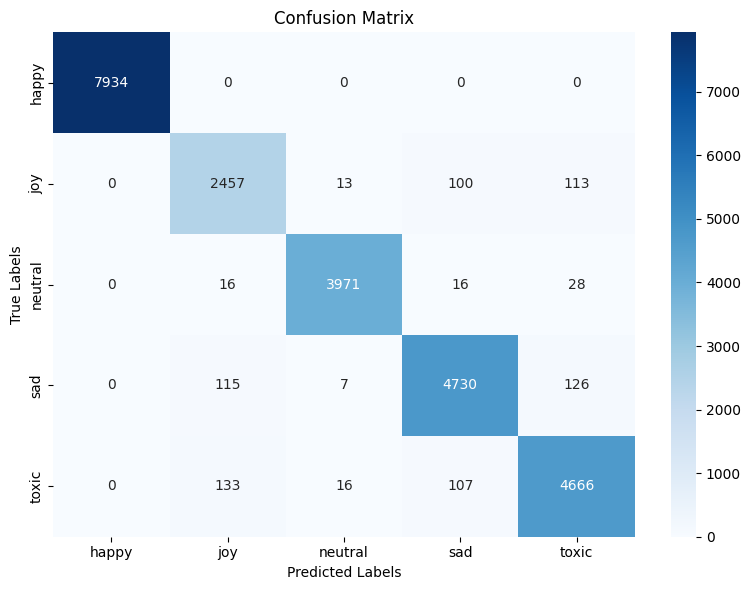

In [2]:

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

report = classification_report(
    labels, predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print(" Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
